In [2]:
#libraries and main functions

In [3]:
import skimage
import numpy as np
import czifile
from czifile import CziFile
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
import numpy as np
from skimage.measure import regionprops
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.measure import label, regionprops
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.filters import try_all_threshold
import czifile as czi
import pandas as pd
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage import exposure
from skimage import morphology
from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage import color, filters, feature, transform
from skimage.morphology import binary_dilation, disk, binary_erosion
from skimage import color, filters, feature, transform, draw
from os import listdir
from os.path import isfile, join
from cellpose import io, models, plot
from skimage import io, filters, feature, measure, color
from IPython.display import clear_output
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt
model = models.Cellpose(model_type='cyto')

def classify():
    while True:
        user_input = input("Please decide if you want to include this cell.").strip().lower()
        
        if user_input == 'y':
            return 'y'
        elif user_input == 'n':
            return 'n'
        else:
            print("Invalid input. Please enter r, c, e, or u.")

def detect_circular(green_channel):

    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.4)

    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())

    # Detect edges using the Canny edge detector
    edges = feature.canny(confocal_img, sigma=3, low_threshold=0.1, high_threshold=0.3) # Fine-tune thresholds

    # Distance Transform and Watershed Segmentation
    distance = distance_transform_edt(np.invert(edges))
    local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=np.invert(edges))

    # Create marker image
    markers_image = np.zeros_like(distance, dtype=bool)
    markers_image[tuple(local_maxi.T)] = True  # Mark the coordinates in local_maxi
    markers = morphology.label(markers_image)  # Label the markers

    labels = watershed(-distance, markers, mask=np.invert(edges))
    # Find and Plot Circular Contours
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(confocal_img, cmap=plt.cm.viridis)
    for label in np.unique(labels):
        if label == 0:  # Background
            continue
        mask = (labels == label)
        contour = measure.find_contours(mask, level=0.5)[0]  # Get the largest contour for each label
        if len(contour) > 100: 
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    plt.title('Detected Circular Regions')
    plt.axis('off')
    plt.show()

def combined_mask(red_channel, threshold_red):
    """Creates a combined mask based on overlap and threshold conditions.

    Args:
        red_channel: NumPy array representing the red channel of the image.
        mask1: Boolean mask (NumPy array).
        mask2: Boolean mask (NumPy array) with the same shape as mask1.

    Returns:
        Combined boolean mask.
    """
    # Create a mask where both input masks are True
    overlap_mask = red_channel > 0

    # Apply Gaussian filter to the red channel
    blurred_red = gaussian(red_channel)  # Adjust sigma as needed

    # Create threshold masks
    threshold_mask1 = blurred_red < threshold_red
    threshold_mask2 = blurred_red > 0.01

    # Combine all conditions
    combined_mask = overlap_mask & threshold_mask1 & threshold_mask2
    return combined_mask


def mean_at_indices(val, str_list, int_list):
  """Calculates the mean of values in int_list at indices where str_list has 'swiss'.

  Args:
    str_list: A list of strings.
    int_list: A list of integers with the same length as str_list.

  Returns:
    The mean of the values in int_list at the indices where str_list has 'swiss'.
  """
  swiss_indices = []
  for i, value in enumerate(str_list):
    if value == val:
      swiss_indices.append(i)

  values_at_swiss_indices = np.array(int_list)[swiss_indices]
  return np.mean(values_at_swiss_indices)

def analyze_image(image_path, basename):
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    red_channel = image_squeezed[0,:,:]
    threshold_red = threshold_otsu(gaussian(red_channel))
    red_channel_thresholded = gaussian(red_channel) > threshold_red
    red_channel_mid_thresh = combined_mask(red_channel, threshold_red)
    red_channel_low_thresh = gaussian(red_channel) < threshold_red
    green_channel = image_squeezed[1,:,:]
    blue_channel = image_squeezed[2,:,:]
    blue_channel_thresholded = blue_channel > threshold_otsu(blue_channel)
    # detect_circular(green_channel)
    masks, flows, styles, diams = model.eval(green_channel, diameter=280, channels = [0,0])
    labeled_cells = label(masks)
    plt.imshow(labeled_cells)
    plt.show()
    cell_counter = []
    cell_size = []
    num_inclusions = []
    avg_inclusion_area = []
    num_lipids = []
    avg_lipid_area = []
    avg_swiss_inclusion_area_list = []
    avg_solid_inclusion_area_list = []
    swiss_counter = []
    solid_counter = []
    red_green_intersection_divby_red_list = []
    red_green_intersection_divby_green_list = []
    cell_diffuse_lipids_mfi = []
    percent_overlap_diffuse_list = []
    percent_overlap_droplets_list = []
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 300:
            continue
        mask = labeled_cells == cell.label
        mask = binary_dilation(mask, disk(3))
        cell_minus_nucleus = blue_channel_thresholded & mask
        cell_minus_nucleus = mask.astype(int) - cell_minus_nucleus.astype(int)
        cell_diffuse_lipids = red_channel_low_thresh * cell_minus_nucleus
        cell_diffuse_lipids = np.mean(cell_diffuse_lipids[cell_minus_nucleus > 0])
        percent_overlap_diffuse = red_channel_mid_thresh & cell_minus_nucleus
        percent_overlap_droplets = red_channel_thresholded & cell_minus_nucleus
        cell_minus_nucleus_count = np.count_nonzero(cell_minus_nucleus)
        diffuse_count = np.count_nonzero(percent_overlap_diffuse)
        droplet_count = np.count_nonzero(percent_overlap_droplets)
        percent_overlap_diffuse = diffuse_count / cell_minus_nucleus_count
        percent_overlap_droplets = droplet_count / cell_minus_nucleus_count
        applied_mask = gaussian(green_channel) * mask
        applied_mask_thresholded = applied_mask > 0.65
        lipids_in_cell = mask * red_channel_thresholded
        red_green_intersection_area = applied_mask_thresholded & lipids_in_cell
        red_green_intersection_area = np.count_nonzero(red_green_intersection_area)
        red_area = np.count_nonzero(lipids_in_cell)
        green_area = np.count_nonzero(applied_mask_thresholded)
        if green_area == 0:
            red_green_intersection_divby_green = 0
        else:
            red_green_intersection_divby_green = red_green_intersection_area / green_area
        if red_area == 0:
            red_green_intersection_divby_red = 0
        else:
            red_green_intersection_divby_red = red_green_intersection_area / red_area
        # plt.imshow(applied_mask)
        # plt.colorbar
        # plt.show()
        mean_cell = np.mean(applied_mask[mask > 0])
        threshold = 0.55
        inclusions = applied_mask > threshold
        # inclusions = binary_dilation(inclusions, disk(4))
        inclusions_labeled = label(inclusions)
        # plt.imshow(inclusions_labeled)
        # plt.show()
        swiss_or_solid = []
        append = 'solid'
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        for inclusion in regionprops(inclusions_labeled):
            if inclusion.area > 10:
                inclusion_mask = inclusions_labeled == inclusion.label
                lipids_in_inclusions = inclusion_mask * gaussian(red_channel)
                lipids_in_inclusions = lipids_in_inclusions > 0.5
                lipids_in_inclusions_nonzeros = inclusion_mask & red_channel_thresholded
                if np.any(lipids_in_inclusions_nonzeros):
                    append = 'swiss'
                    print(inclusion.area)
                    plt.imshow(inclusion_mask)
                    plt.show()
                else:
                    append = 'solid'
                swiss_or_solid.append(append)
        # if len(inclusion_areas) > 30: #usually, this means the threshold was bad, so I just exclude these cells
        #     continue
        
        confocal_img = exposure.adjust_sigmoid(red_channel, cutoff=0.4)
        confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
        lipids_cell = mask * confocal_img
        lipids_thresholded = lipids_cell > 0.5
        labeled_lipids = label(lipids_thresholded)
        lipid_areas = [lipid.area for lipid in regionprops(labeled_lipids)]
        # else:
        cell_counter.append(i)
        cell_size.append(cell.area)
        num_inclusions.append(len(inclusion_areas))
        avg_inclusion_area.append(np.mean(inclusion_areas))
        num_lipids.append(len(lipid_areas))
        avg_lipid_area.append(np.mean(lipid_areas))
        avg_swiss_inclusion_area = mean_at_indices('swiss', swiss_or_solid, inclusion_areas)
        avg_solid_inclusion_area = mean_at_indices('solid', swiss_or_solid, inclusion_areas)
        avg_swiss_inclusion_area_list.append(avg_swiss_inclusion_area)
        avg_solid_inclusion_area_list.append(avg_solid_inclusion_area)
        swiss_counter.append(swiss_or_solid.count("swiss"))
        solid_counter.append(swiss_or_solid.count("solid"))
        red_green_intersection_divby_red_list.append(red_green_intersection_divby_red)
        red_green_intersection_divby_green_list.append(red_green_intersection_divby_green)
        cell_diffuse_lipids_mfi.append(cell_diffuse_lipids)
        percent_overlap_diffuse_list.append(percent_overlap_diffuse)
        percent_overlap_droplets_list.append(percent_overlap_droplets)

    df = pd.DataFrame({
            "Filename": [basename] * len(cell_counter),
            "Cell": cell_counter,
            "Cell_Size": cell_size,
            "Num_Inclusions": num_inclusions,
            "Solid_Inclusion_Count": solid_counter,
            "Swiss_Inclusion_Count": swiss_counter,
            "Average_Inclusion_Area": avg_inclusion_area,
            "Average_Swiss_Inclusion_Area": avg_swiss_inclusion_area_list,
            "Average_Solid_Inclusion_Area": avg_solid_inclusion_area_list,
            "Portion of Lipids Associated with Inclusions": red_green_intersection_divby_red_list,
            "Portion of Inclusions Associated with Lipids": red_green_intersection_divby_green_list,
            "MFI Lipids in Cytoplasm": cell_diffuse_lipids,
            "Portion of Cytoplasm Surface Area occupied by Diffuse Lipids": percent_overlap_diffuse_list,
            "Portion of Cytoplasm Surface Area occupied by Droplet Lipids": percent_overlap_droplets_list,
            "Num_Lipids": num_lipids,
            "Average_Lipid_Area" : avg_lipid_area
            })
    return df


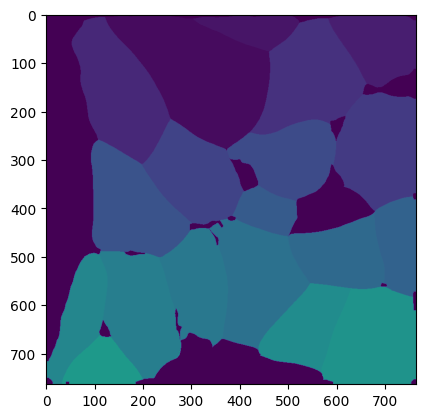

C:\Users\jm2503\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jm2503\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


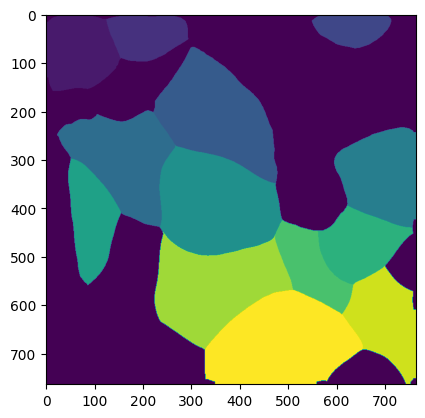

148.0


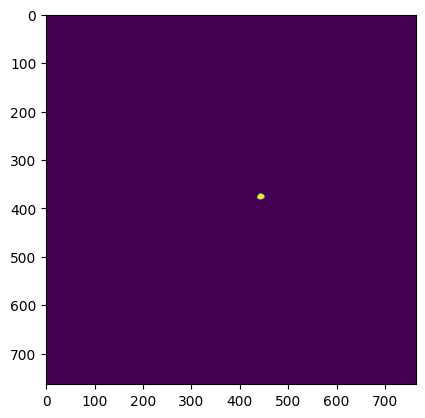

248.0


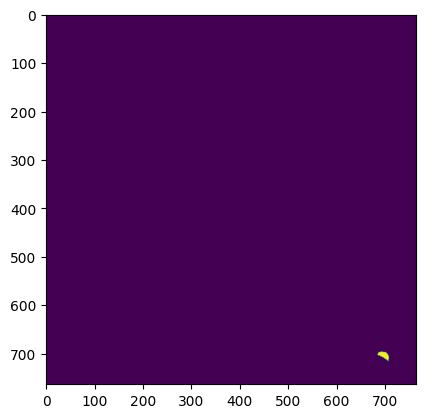

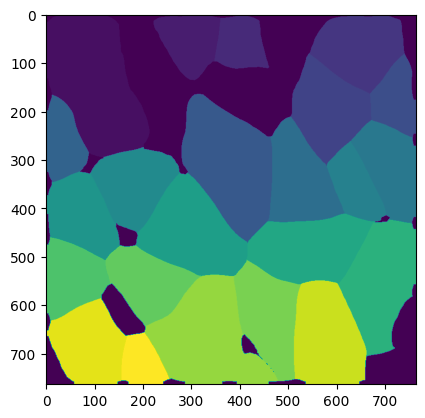

56.0


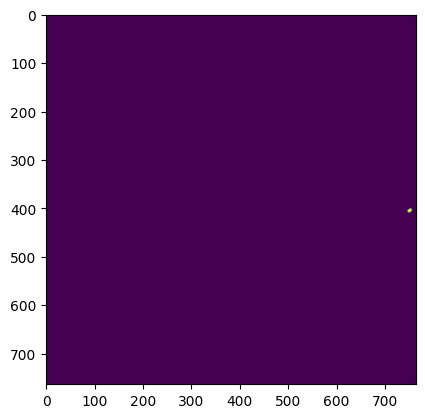

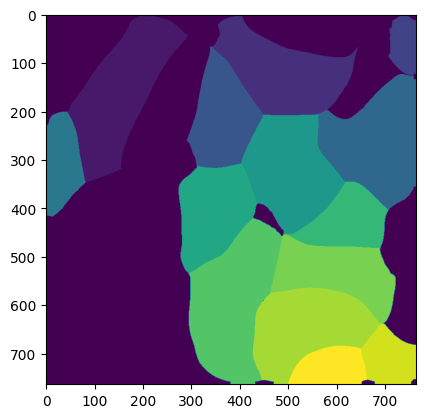

23.0


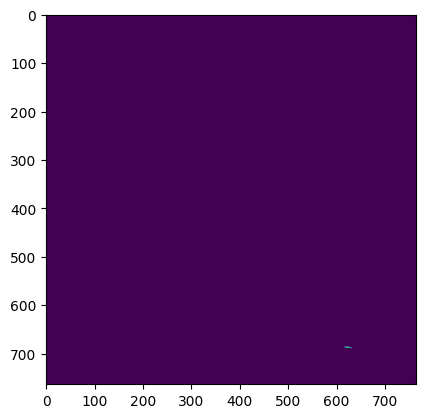

248.0


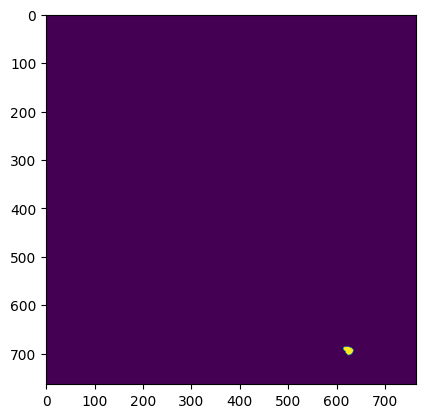

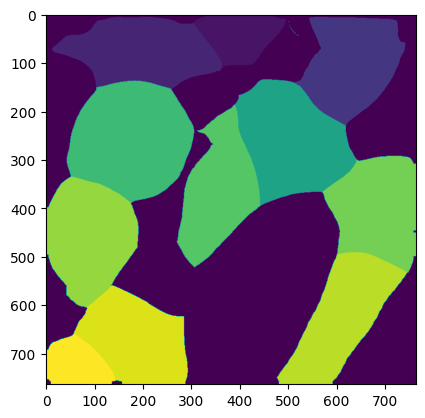

102.0


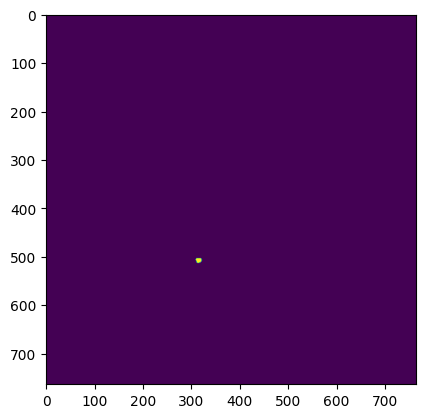

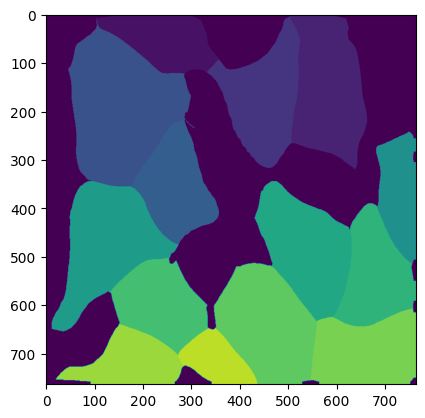

64.0


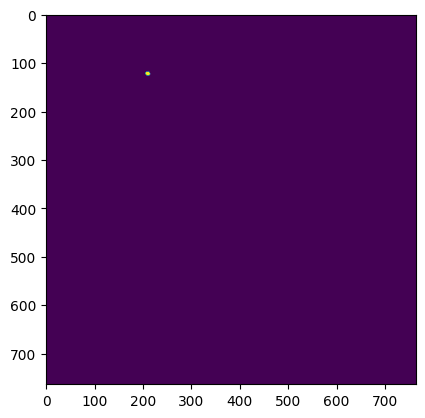

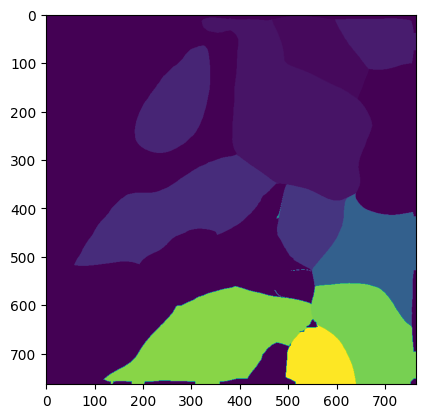

34.0


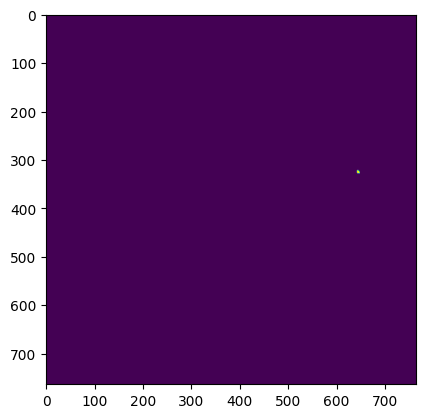

38.0


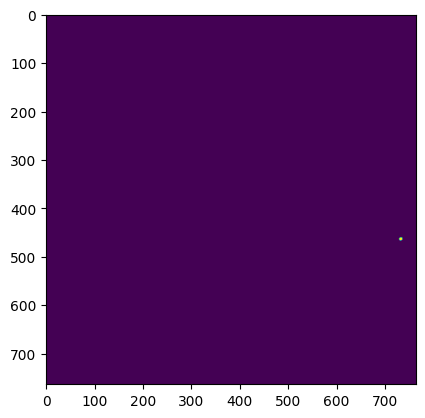

328.0


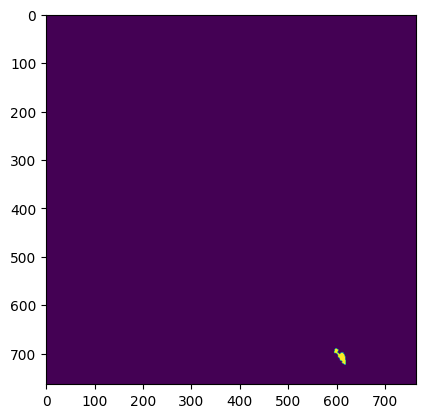

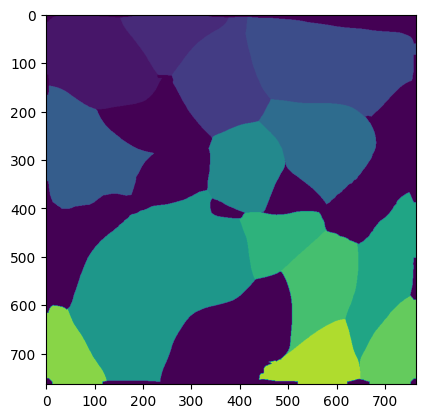

66.0


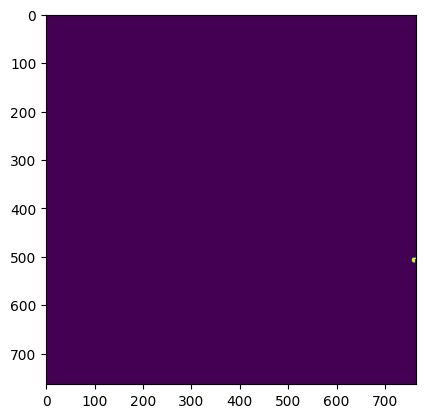

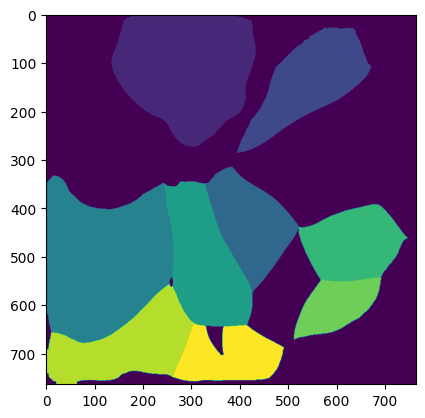

30.0


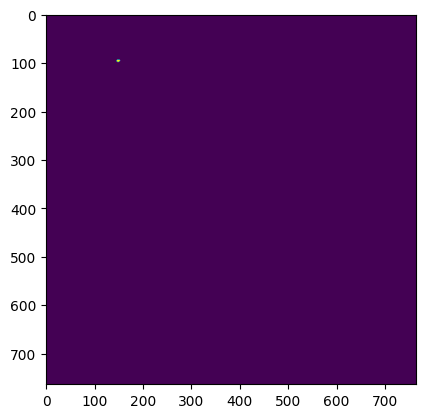

74.0


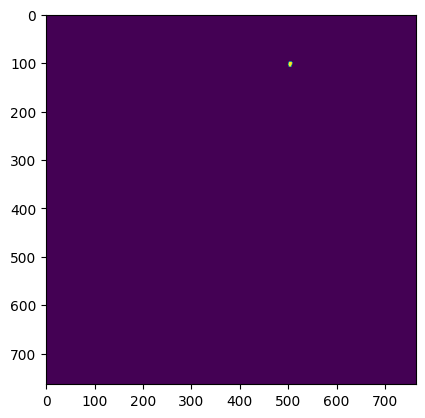

1413.0


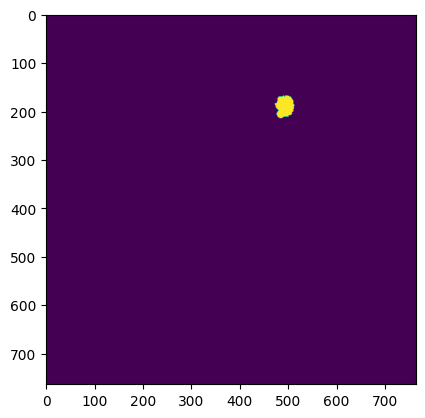

94.0


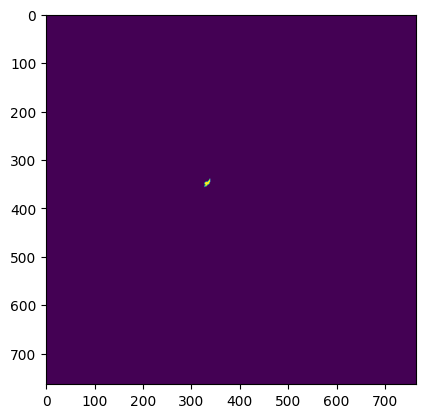

224.0


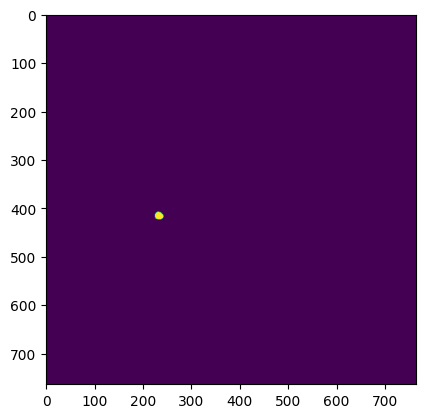

287.0


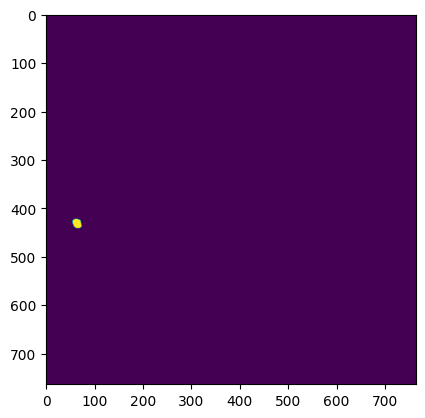

682.0


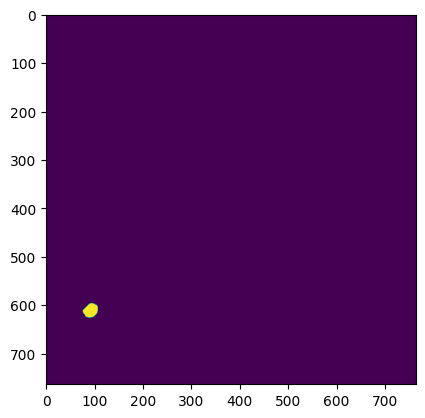

418.0


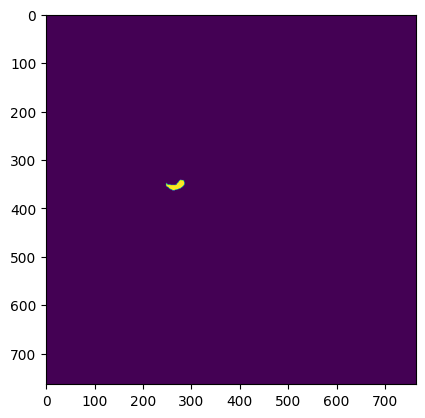

56.0


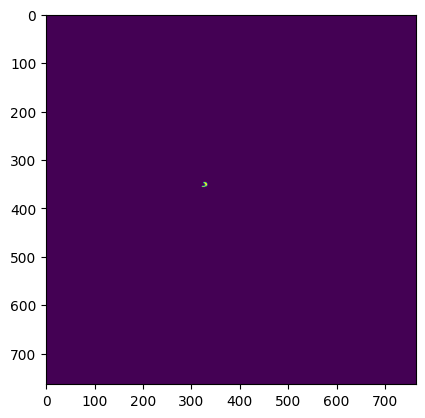

585.0


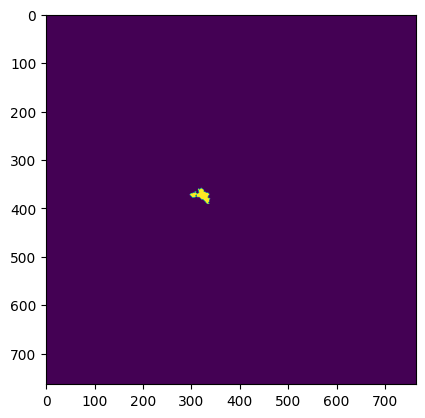

335.0


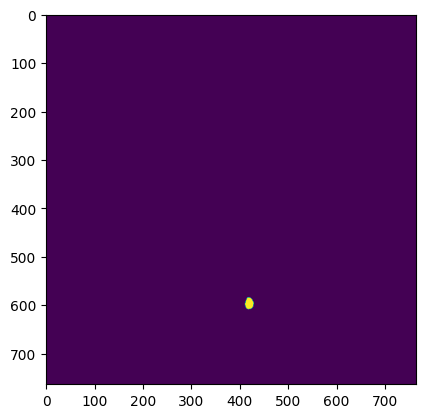

2511.0


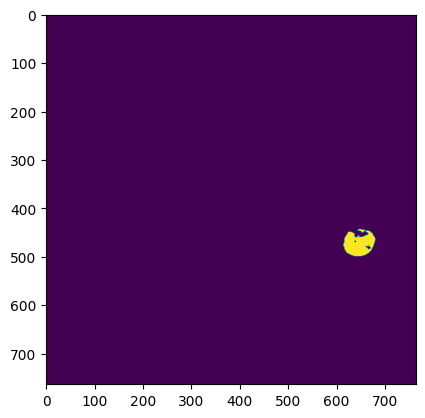

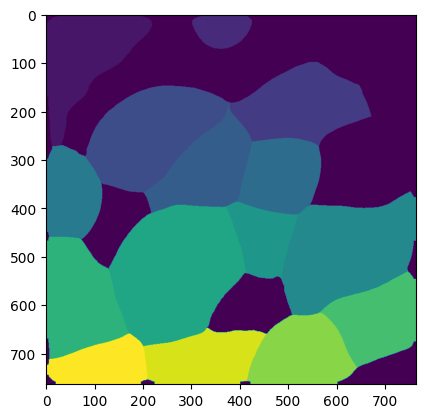

35.0


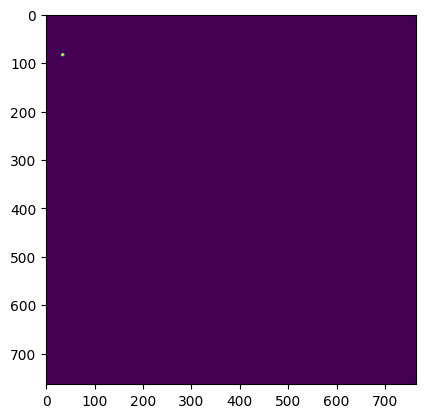

123.0


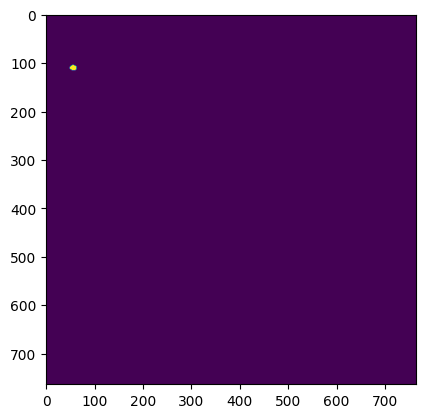

4043.0


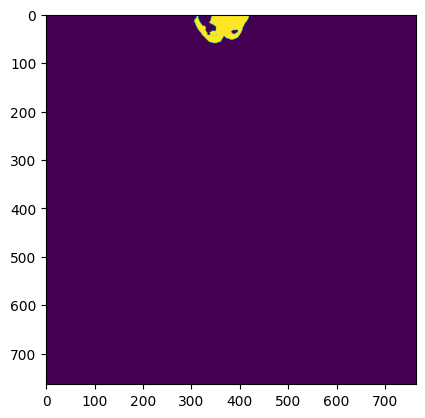

257.0


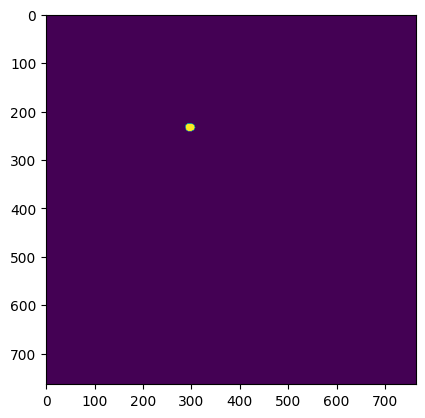

104.0


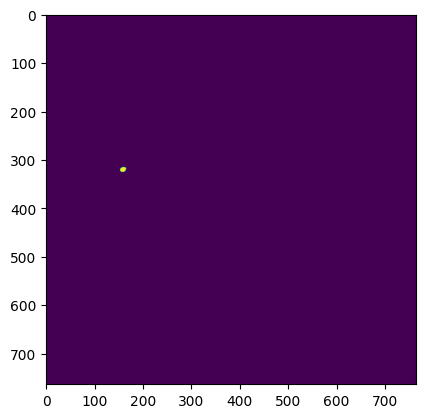

515.0


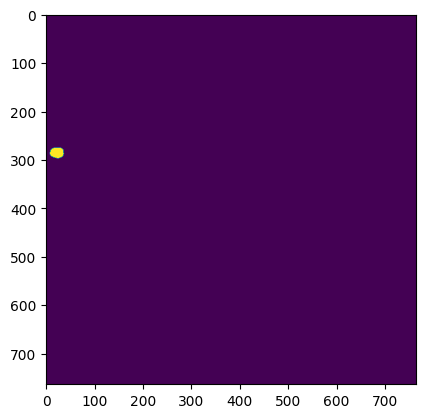

46.0


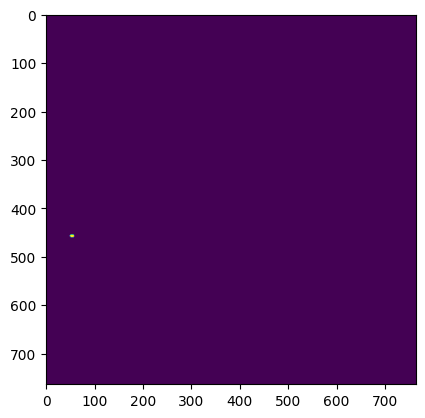

832.0


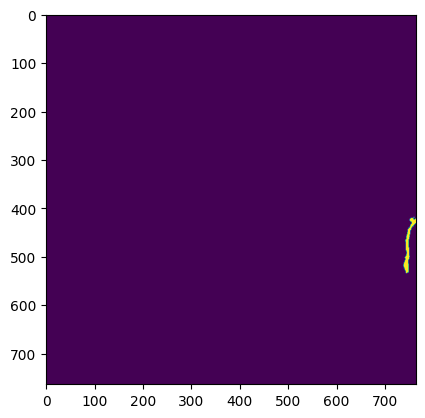

164.0


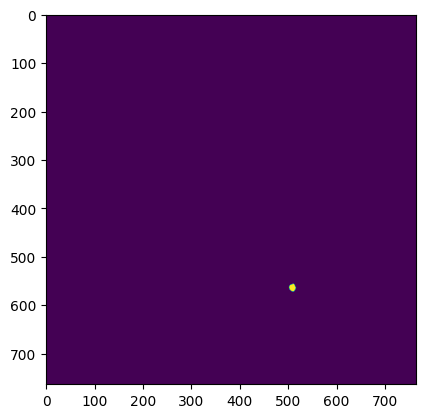

108.0


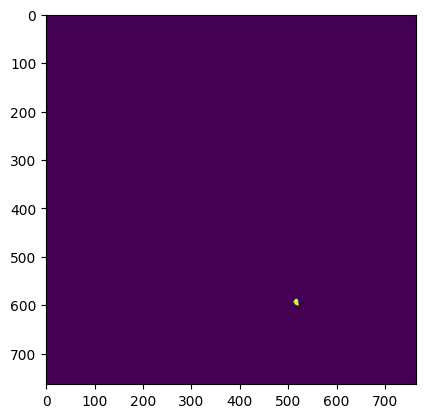

80.0


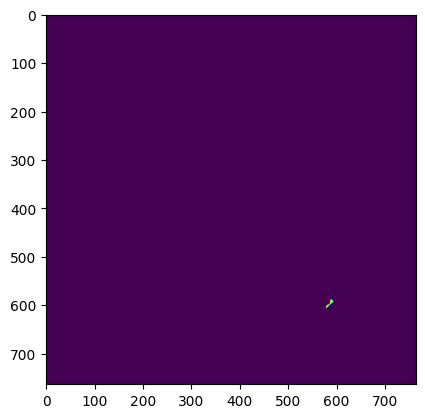

10329.0


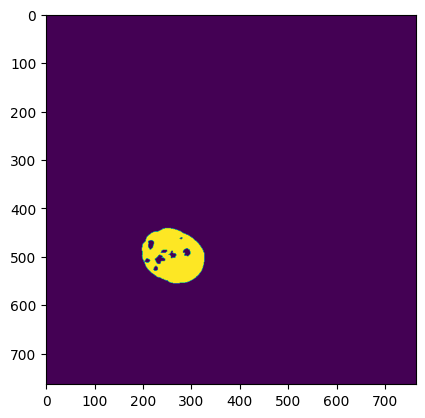

23.0


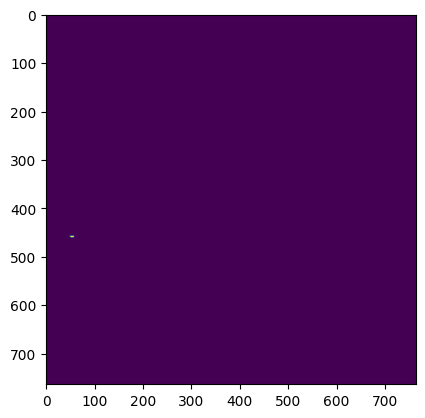

69.0


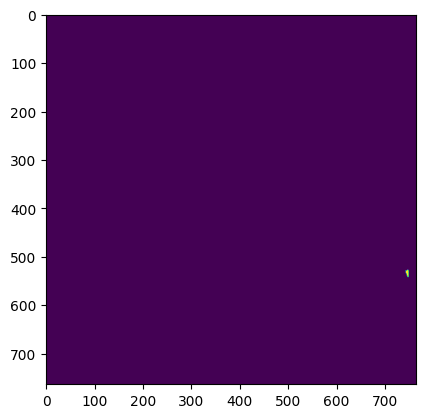

87.0


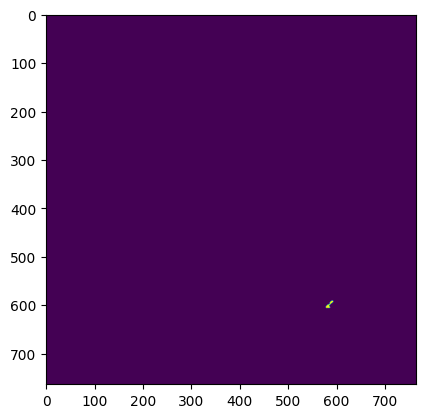

129.0


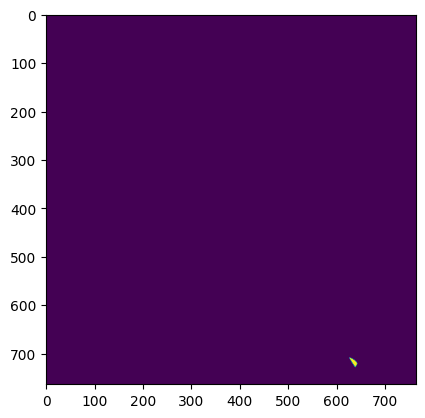

756.0


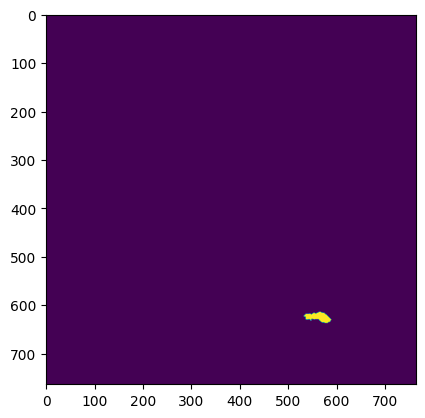

33.0


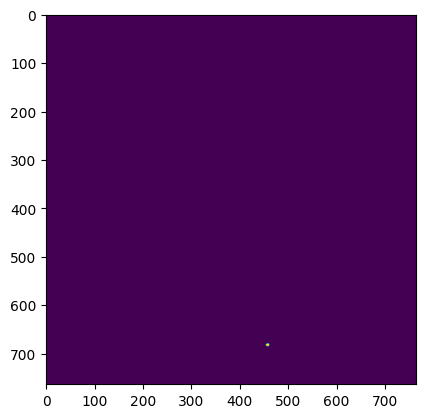

156.0


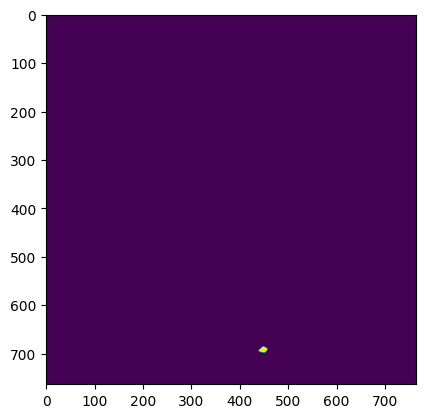

1671.0


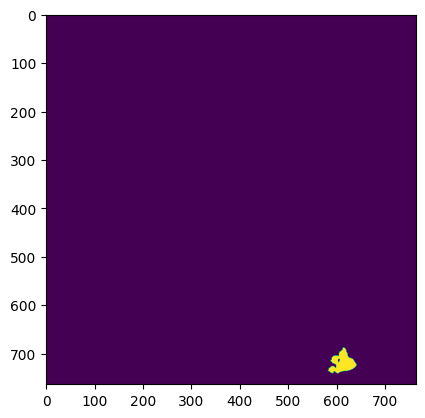

91.0


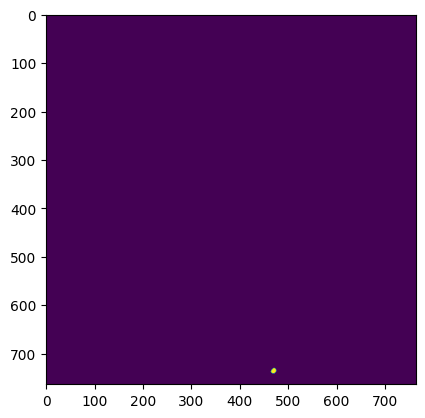

16.0


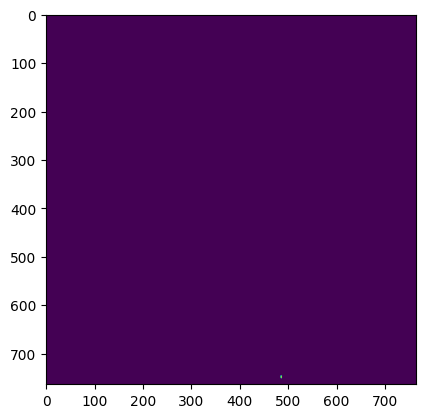

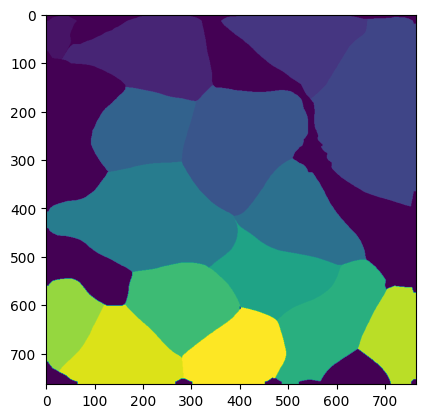

194.0


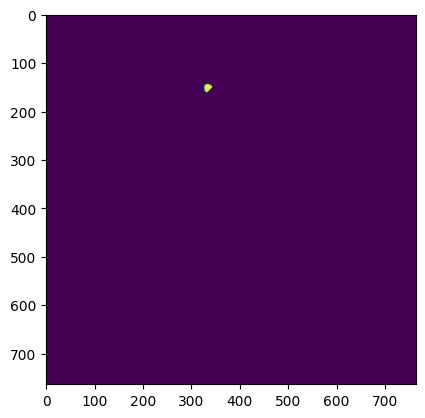

177.0


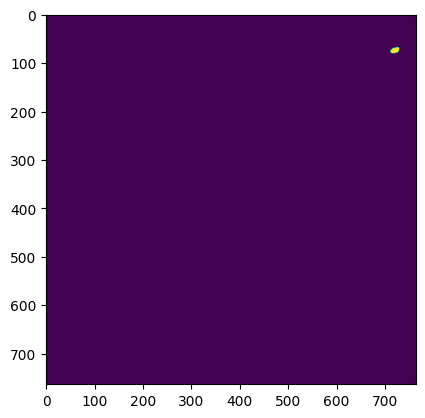

147.0


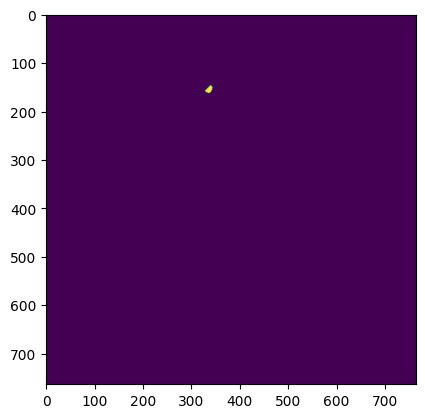

50.0


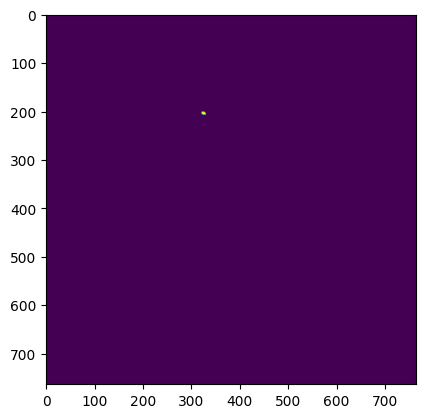

14.0


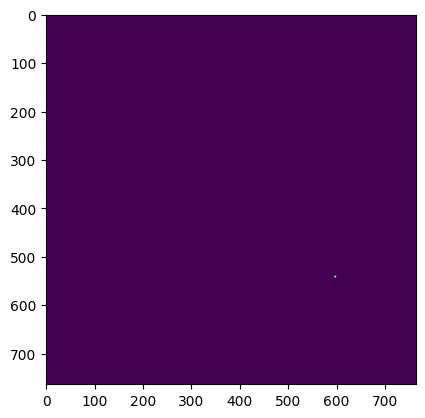

165.0


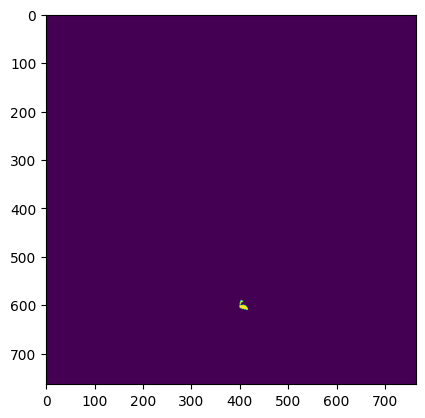

170.0


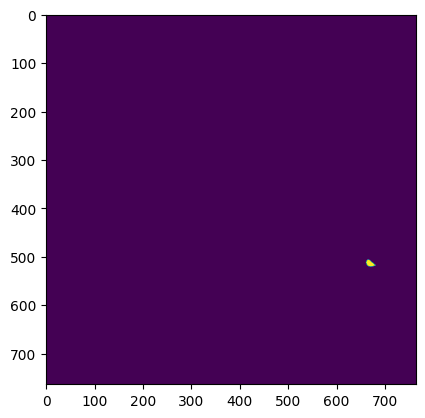

57.0


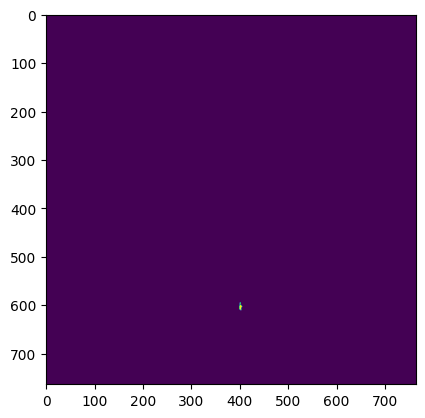

145.0


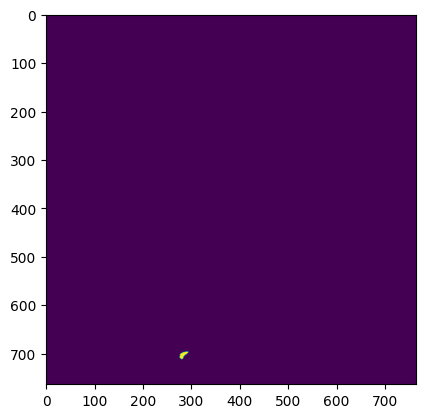

163.0


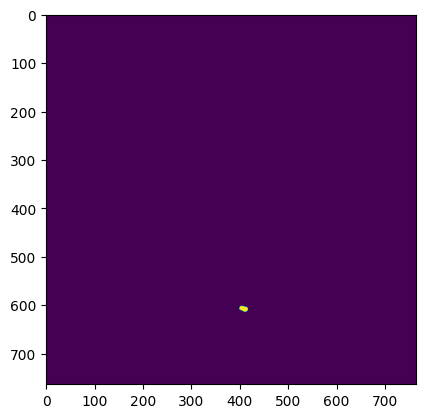

280.0


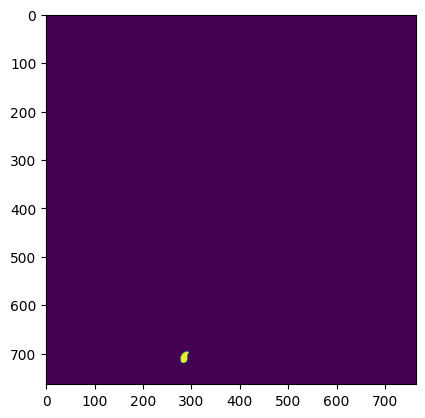

50.0


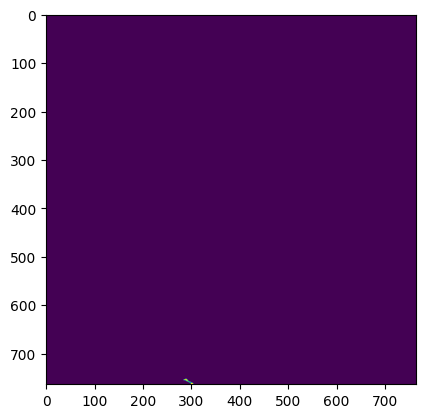

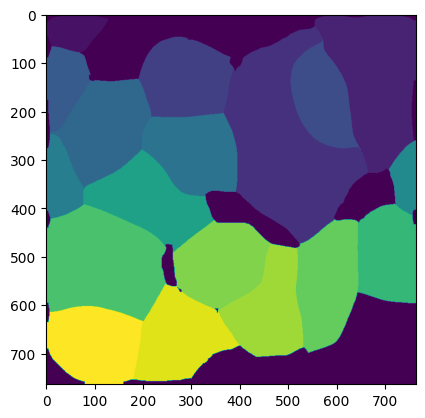

228.0


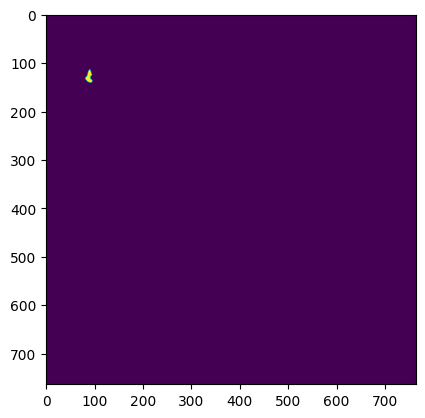

307.0


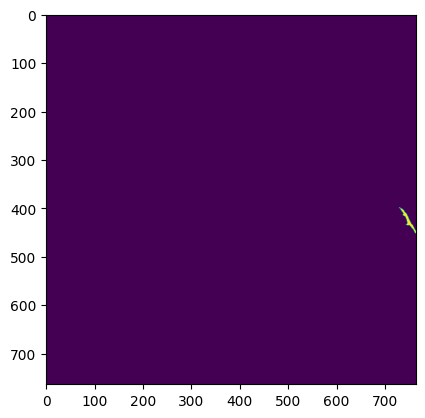

397.0


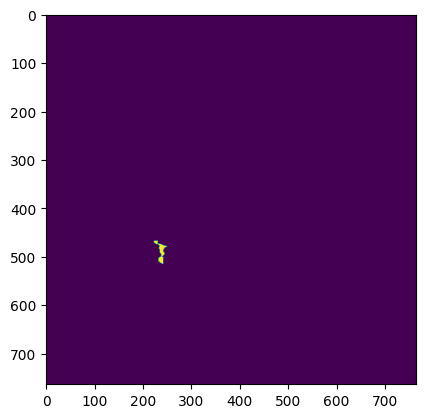

278.0


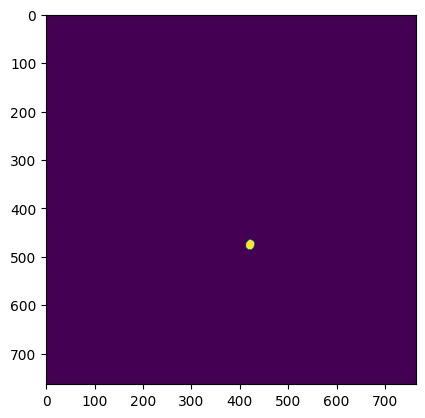

538.0


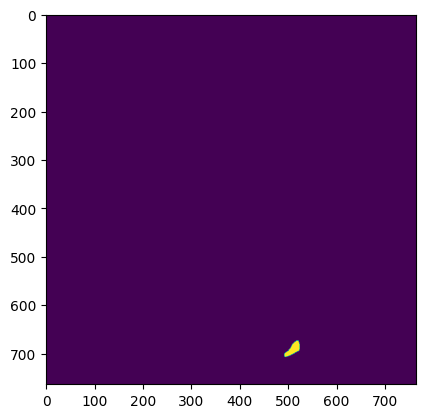

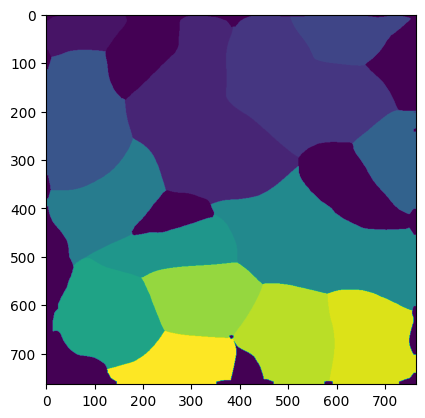

277.0


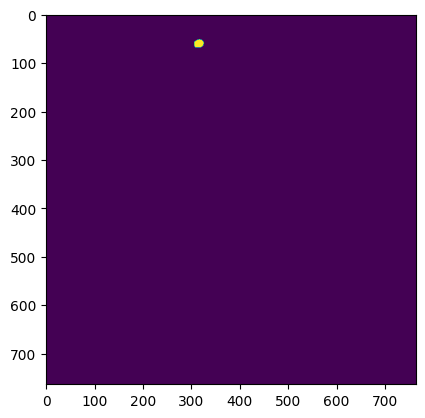

79.0


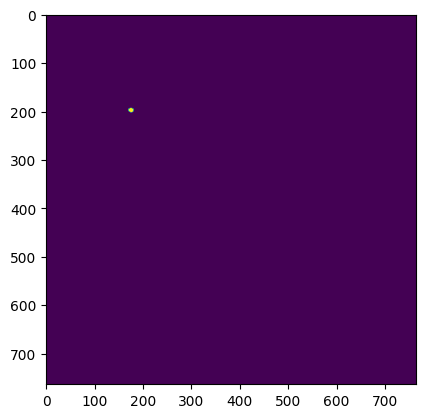

245.0


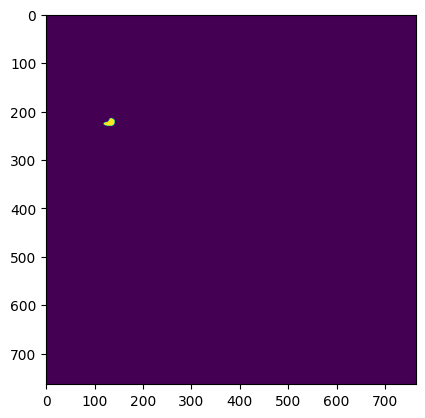

159.0


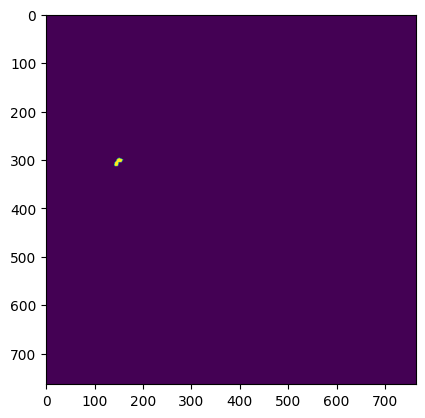

97.0


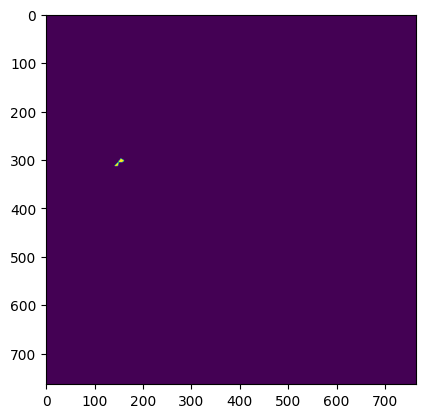

120.0


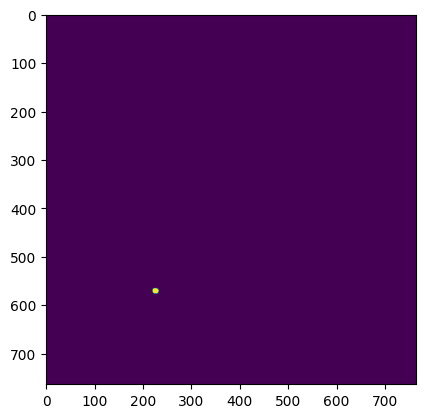

66.0


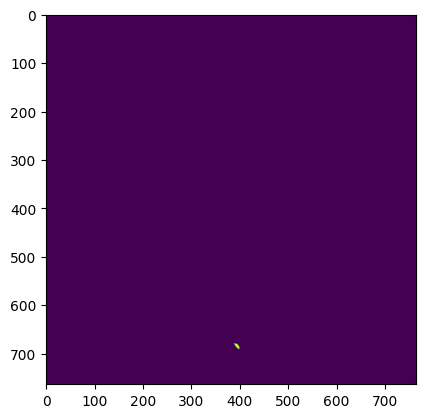

56.0


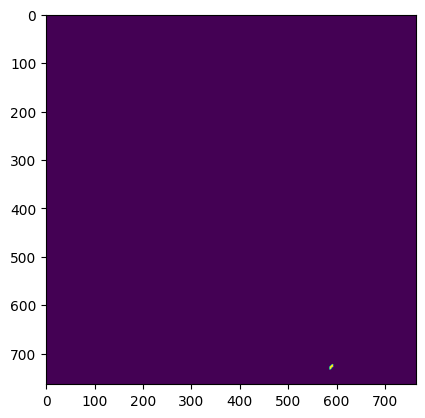

42.0


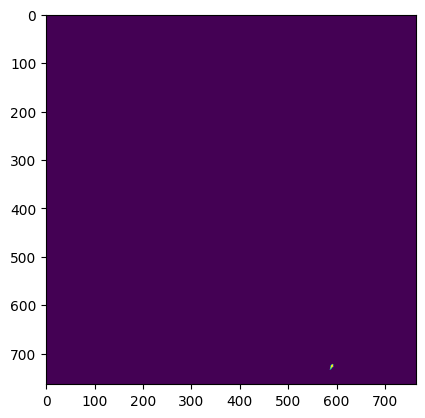

212.0


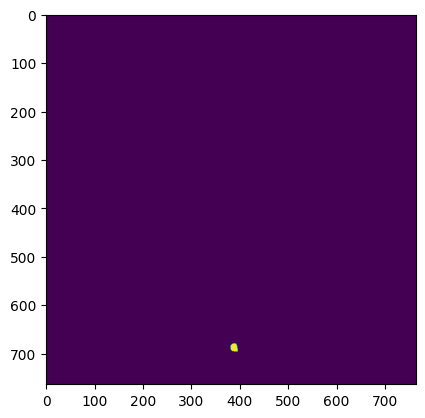

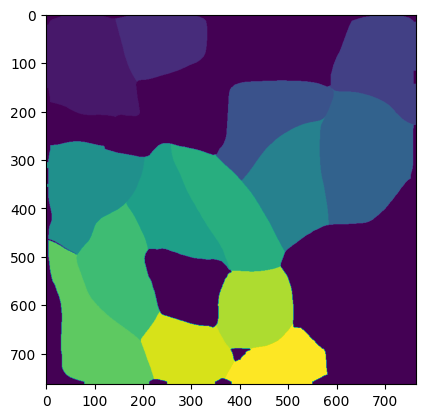

43.0


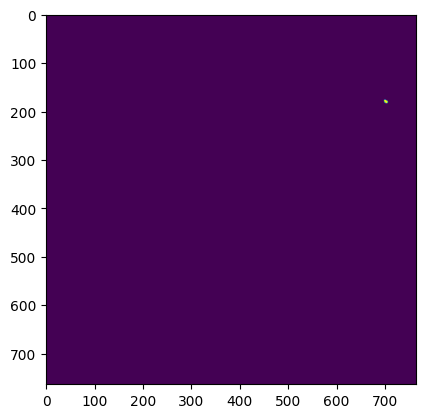

11.0


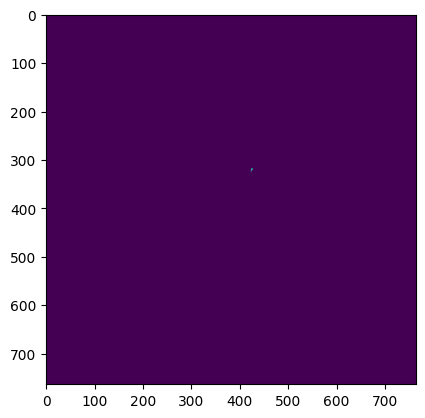

23.0


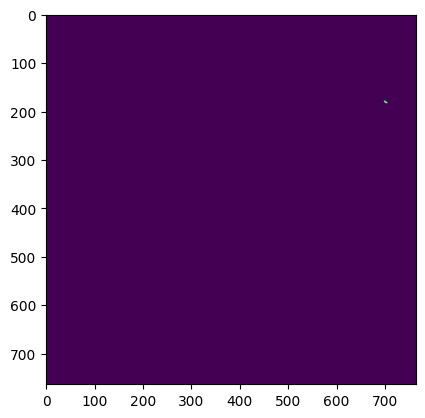

398.0


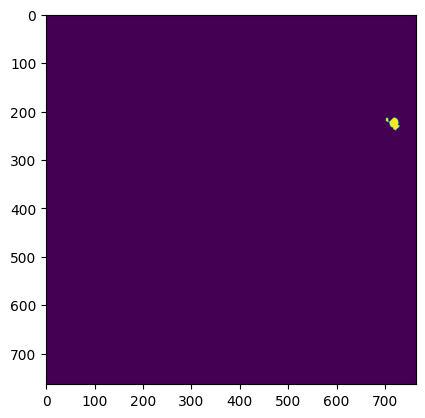

489.0


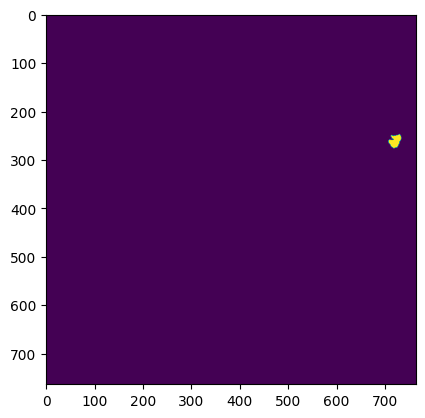

152.0


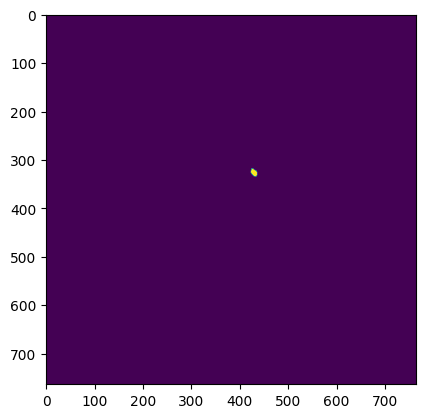

445.0


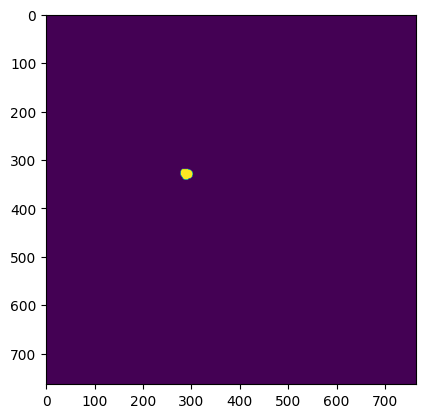

128.0


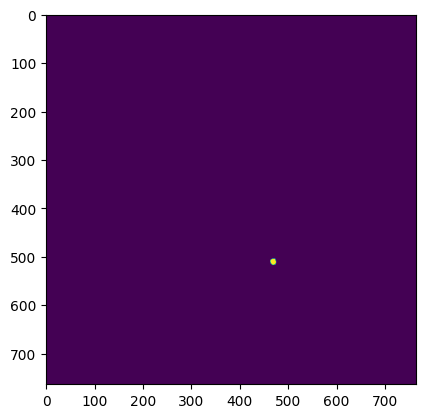

20.0


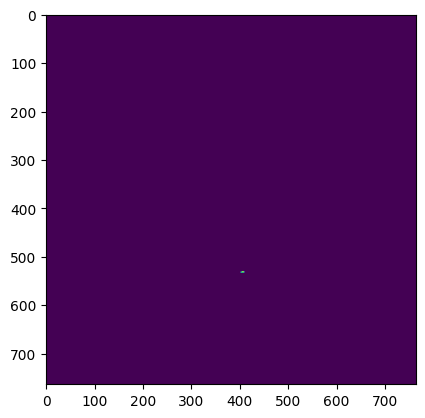

39.0


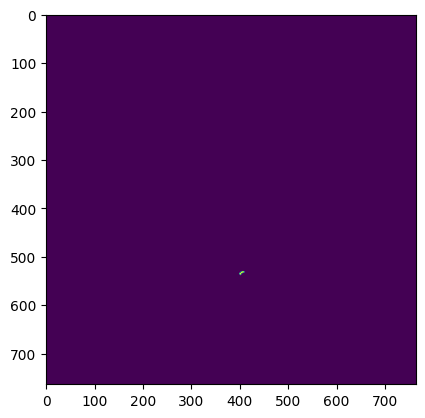

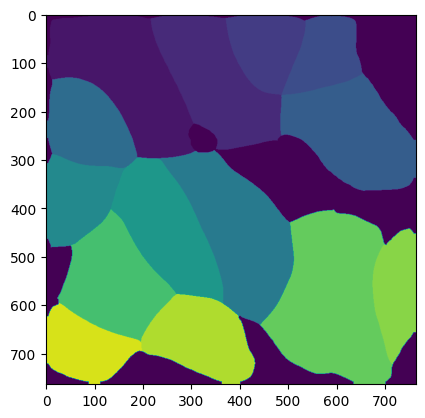

534.0


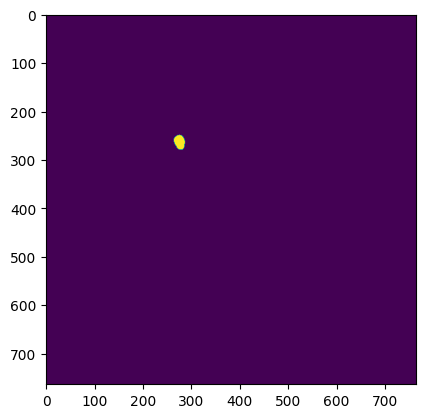

104.0


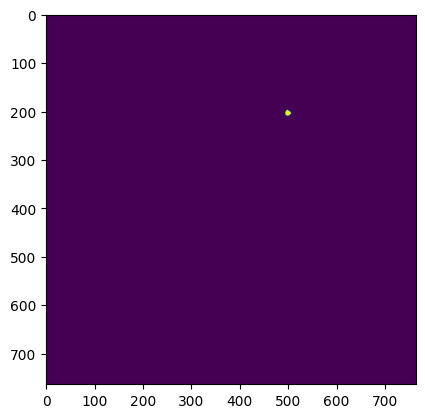

750.0


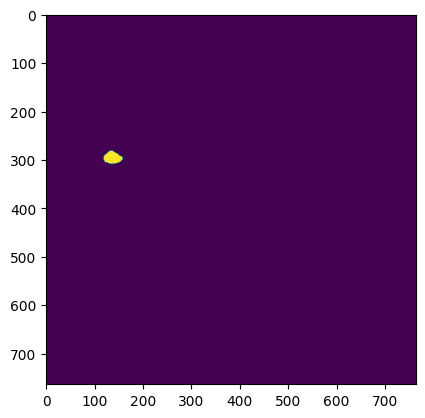

178.0


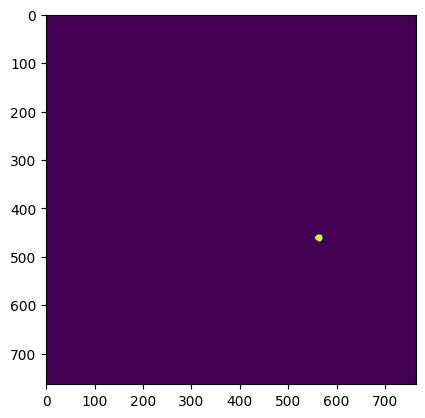

132.0


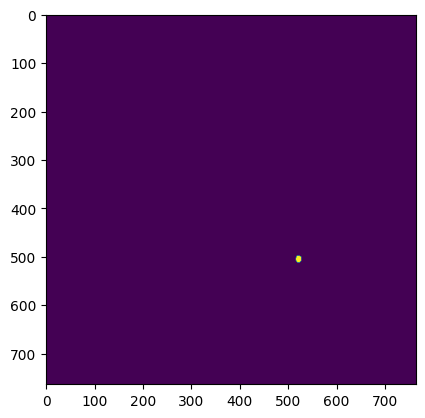

207.0


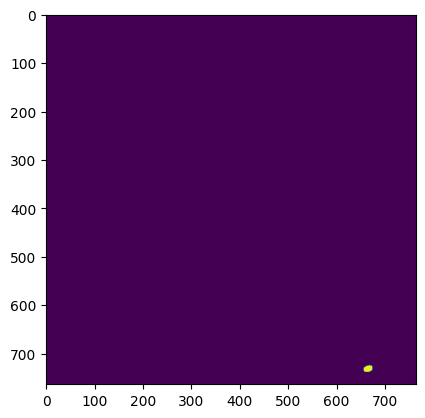

12.0


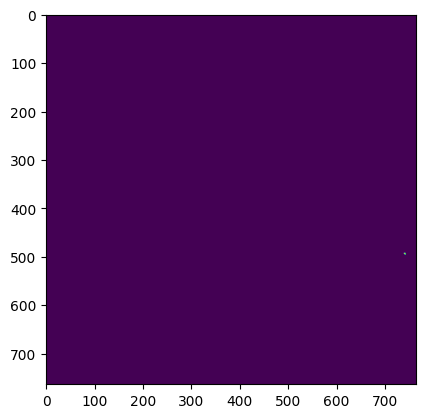

68.0


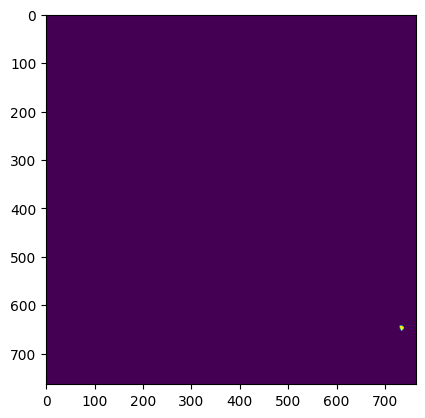

55.0


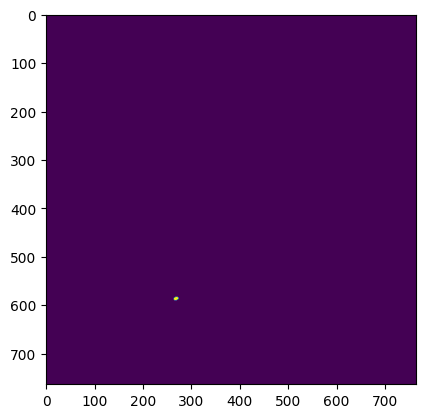

116.0


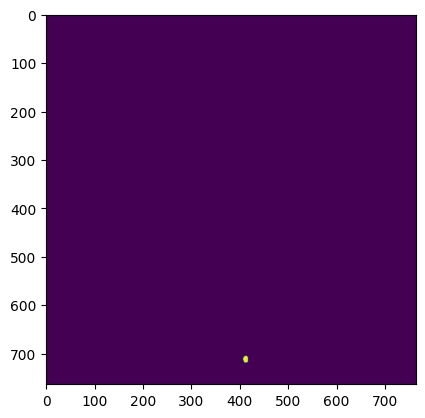

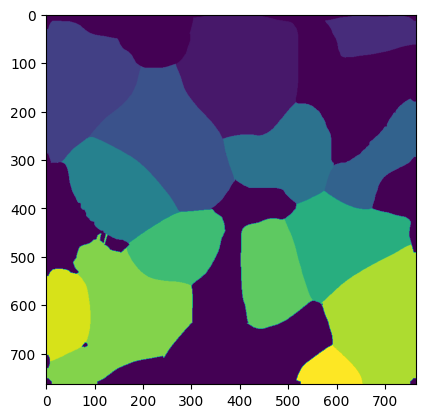

20.0


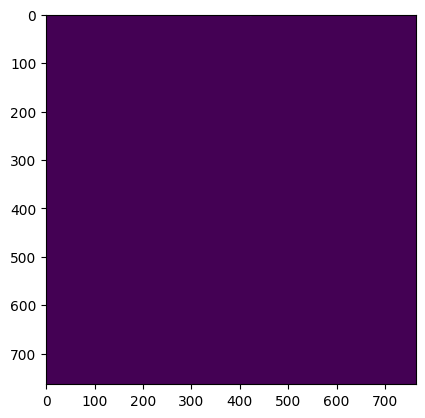

1042.0


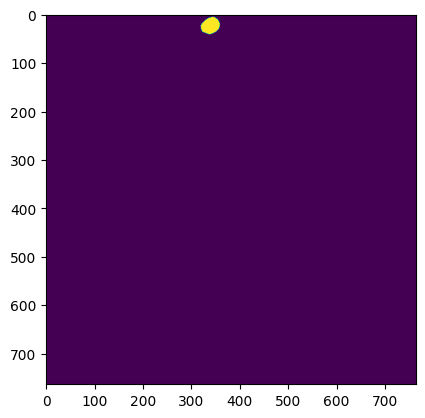

137.0


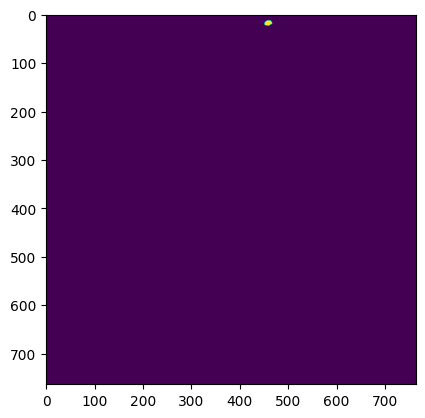

21.0


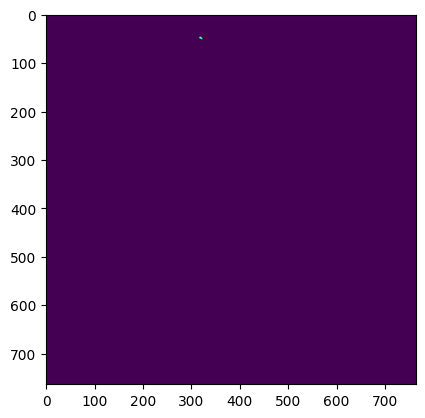

216.0


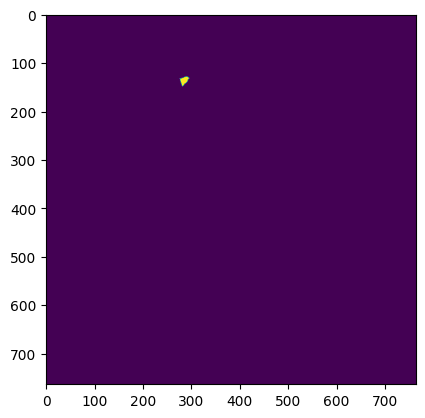

157.0


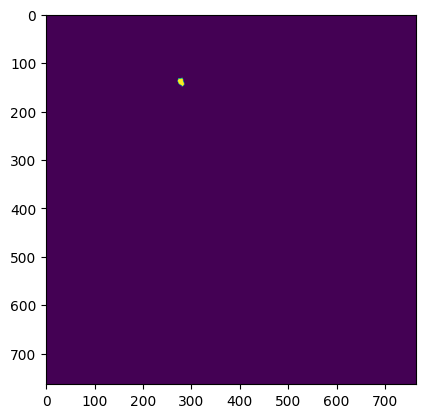

223.0


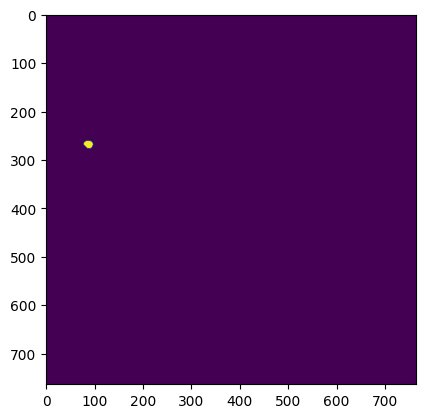

25.0


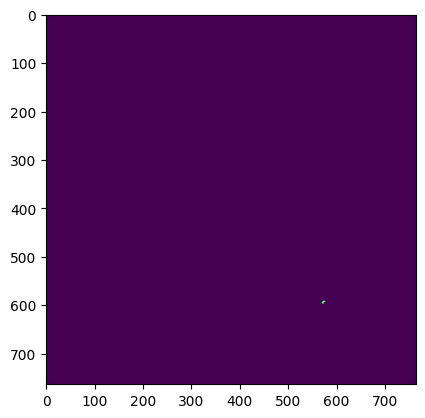

813.0


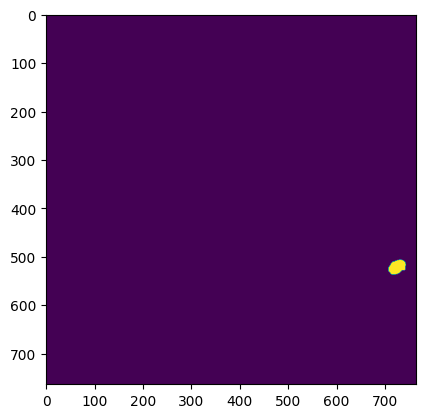

53.0


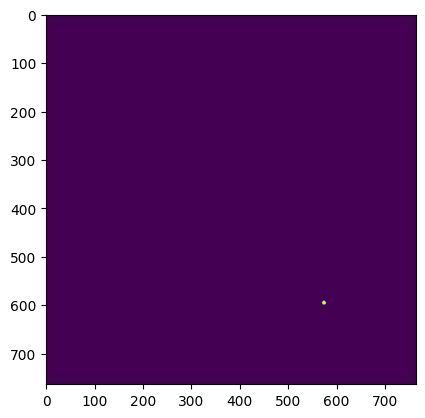

57.0


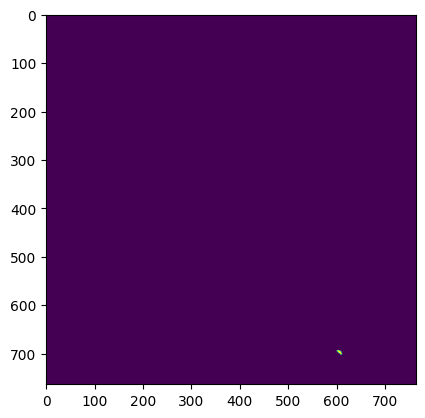

77.0


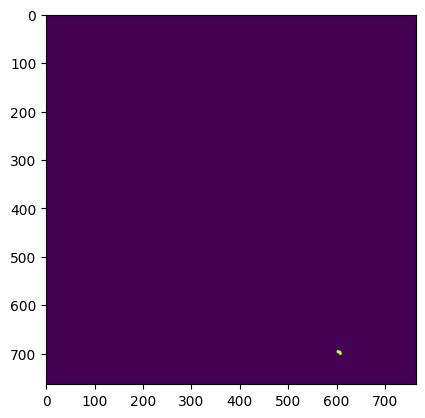

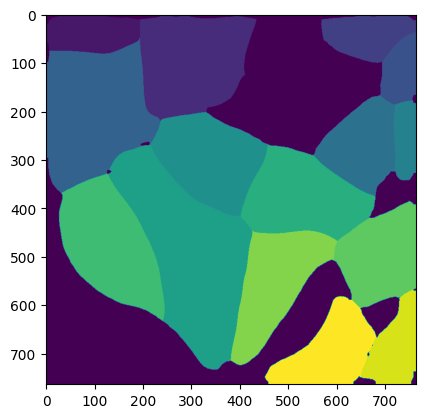

158.0


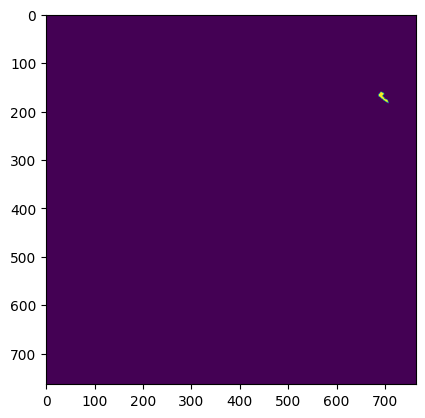

11.0


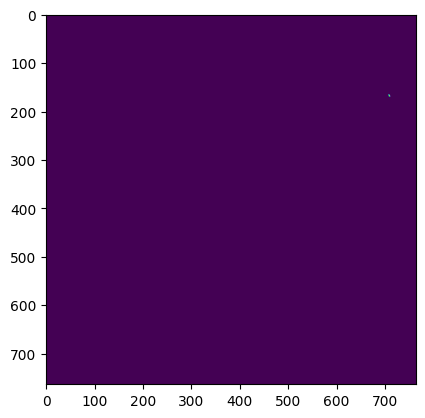

278.0


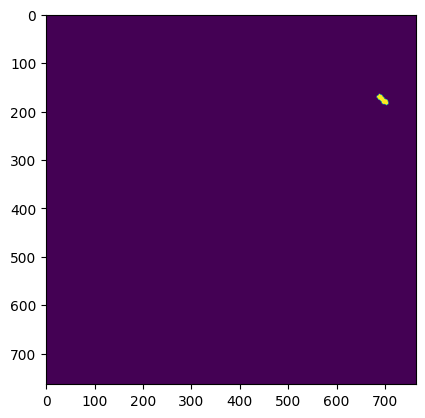

46.0


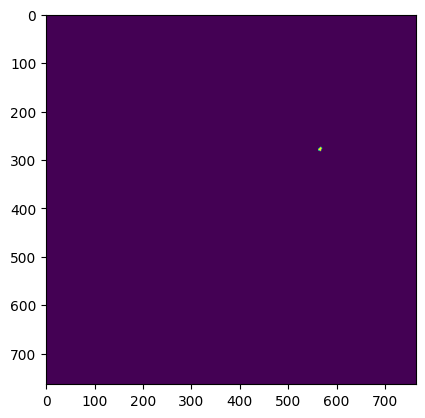

70.0


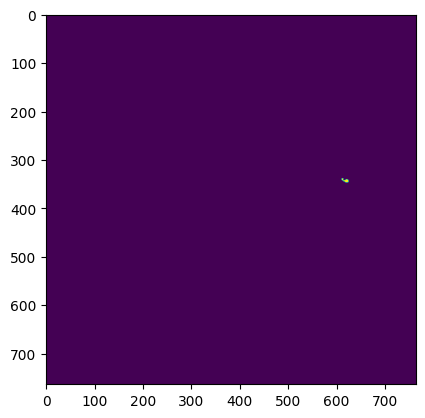

323.0


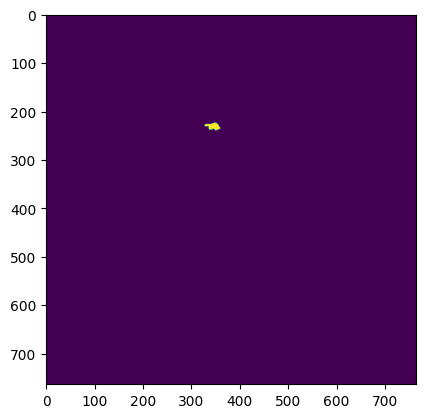

1568.0


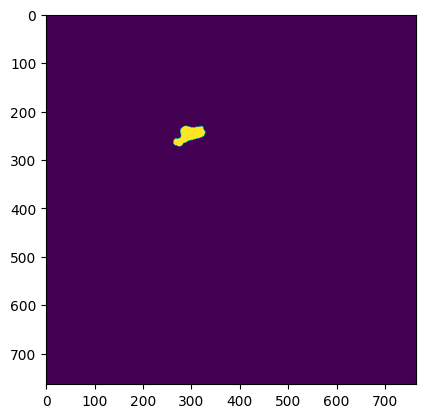

774.0


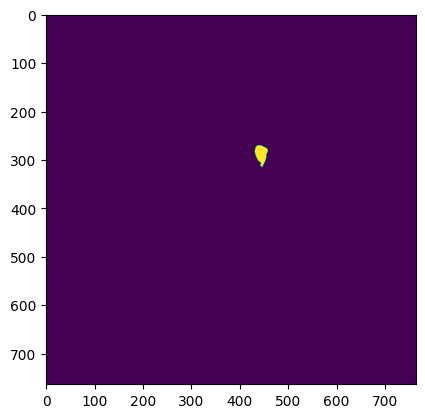

428.0


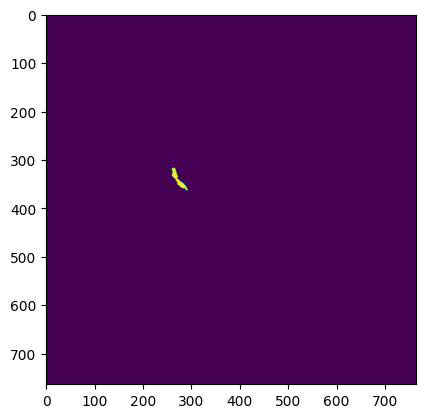

91.0


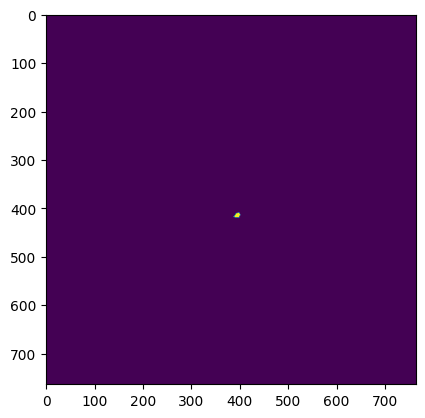

101.0


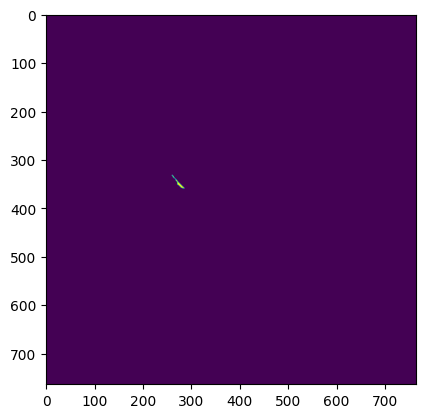

191.0


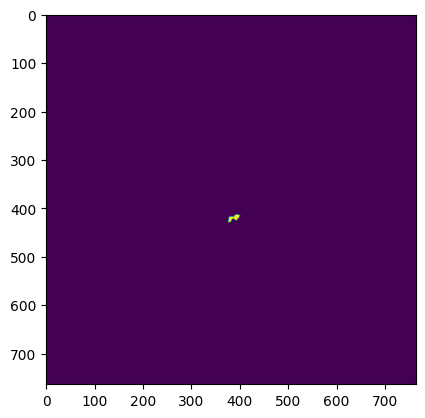

200.0


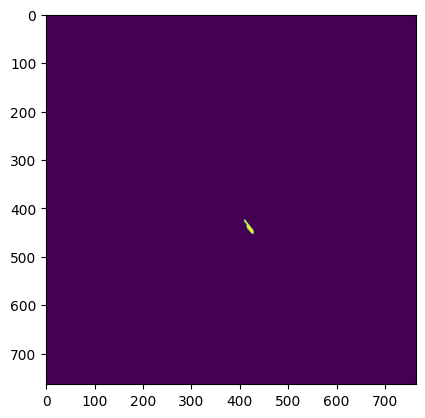

684.0


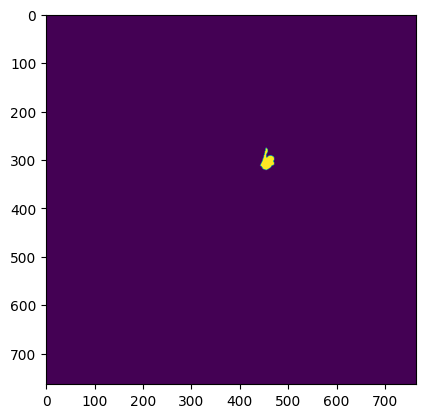

75.0


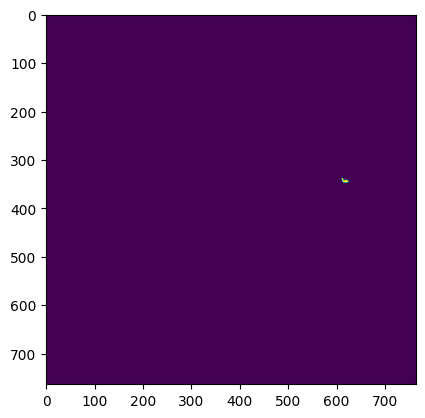

545.0


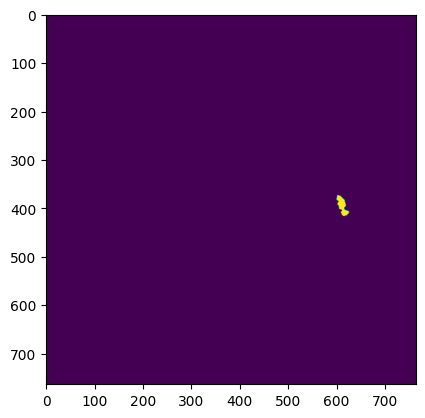

1178.0


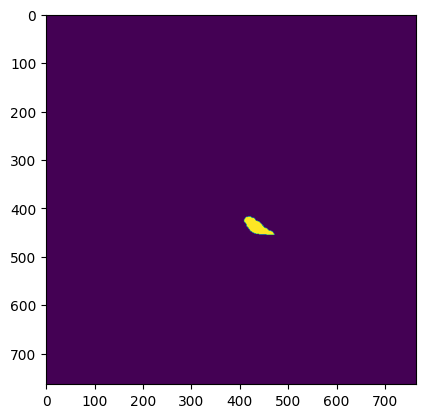

25.0


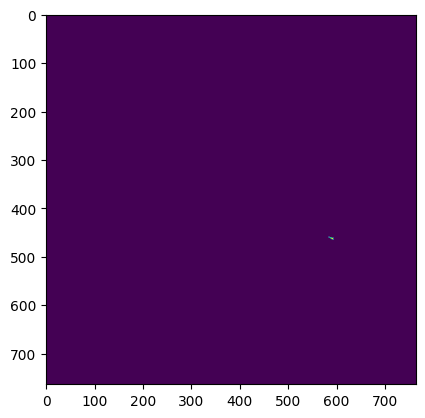

752.0


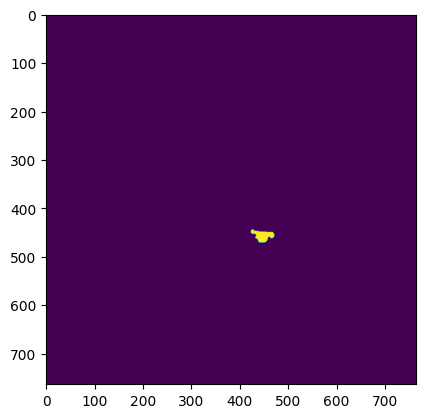

292.0


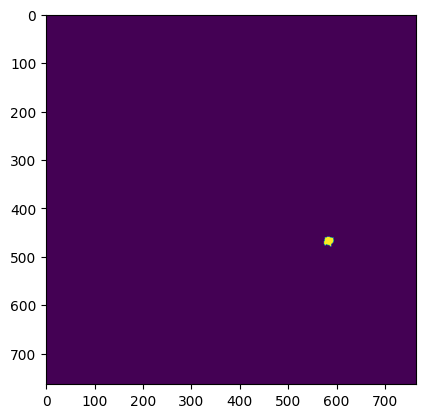

1069.0


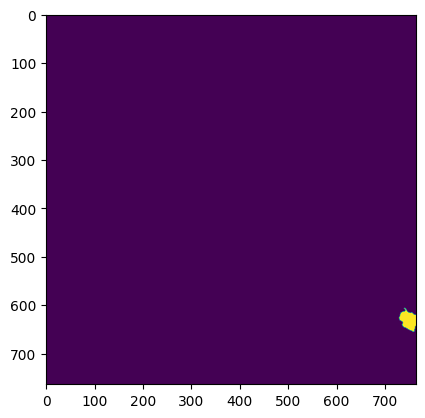

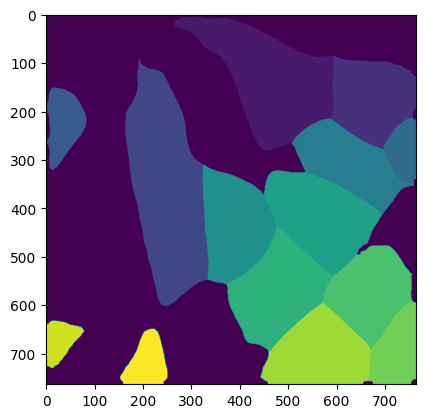

281.0


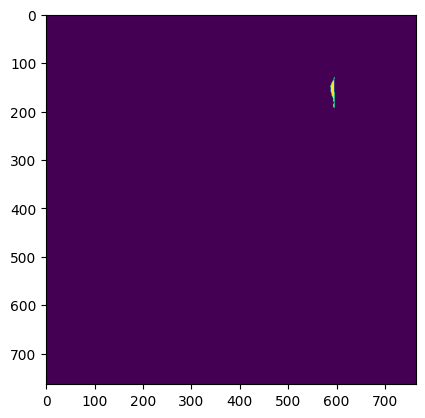

235.0


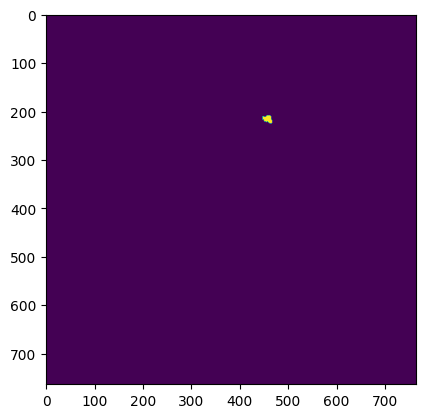

522.0


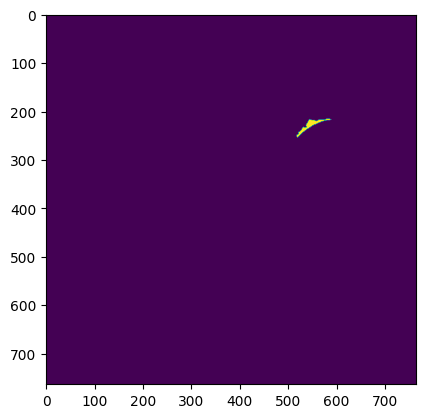

2682.0


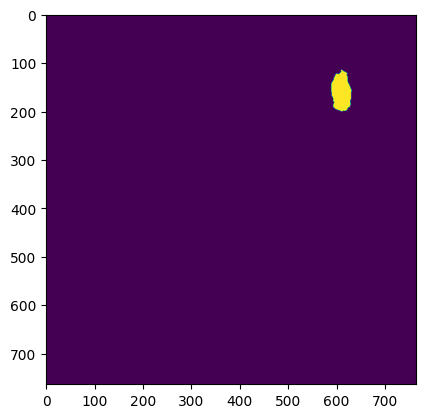

20.0


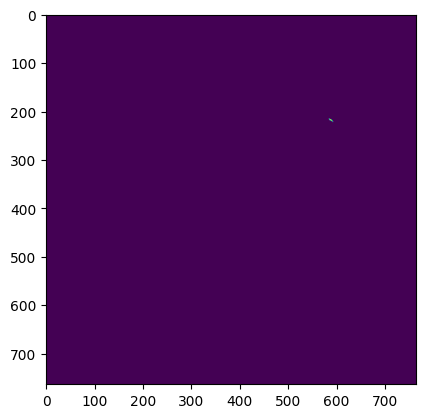

72.0


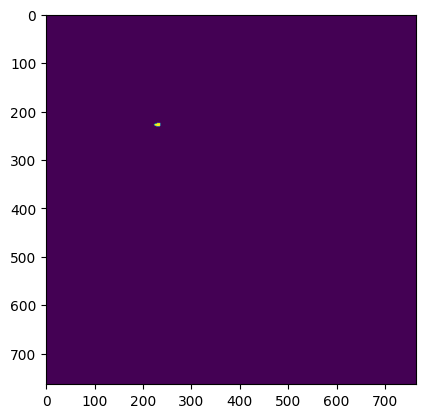

3341.0


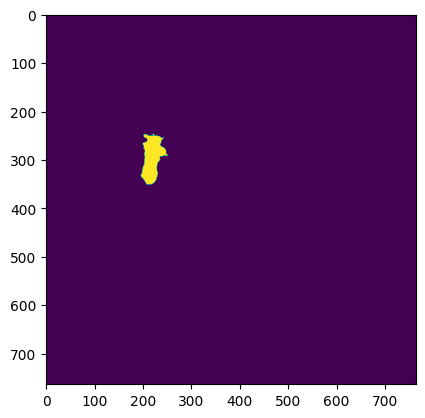

91.0


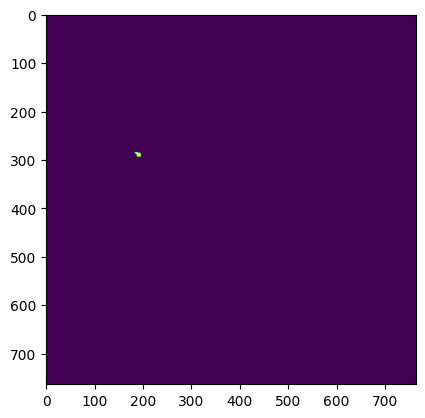

224.0


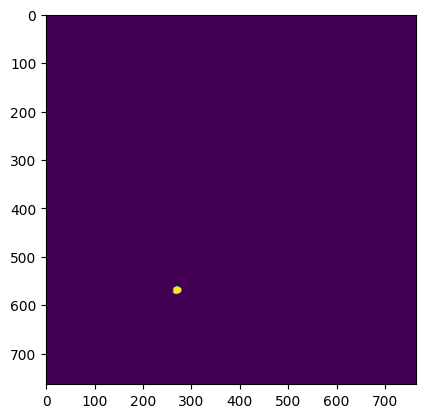

21.0


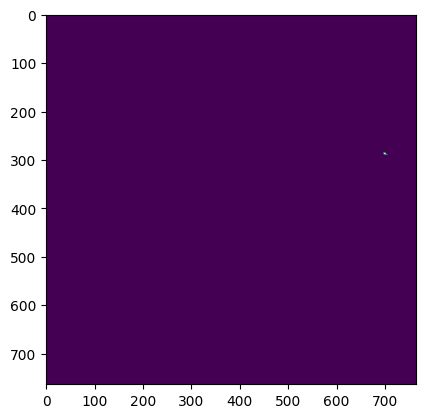

1210.0


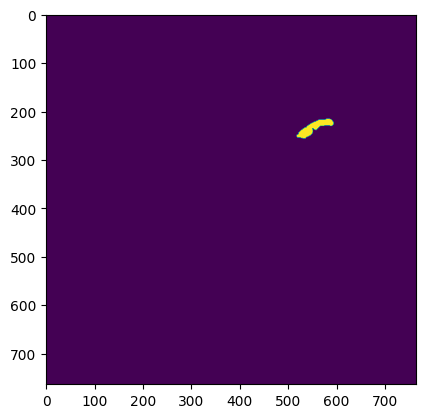

26.0


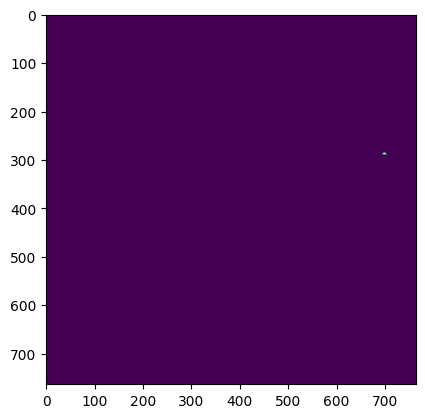

525.0


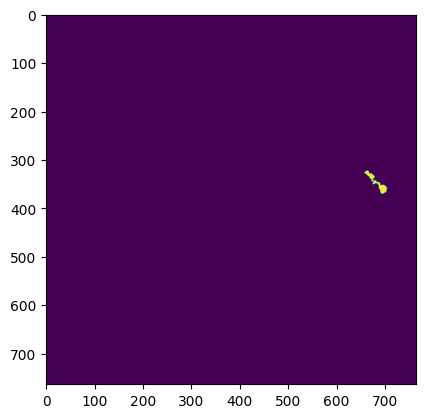

253.0


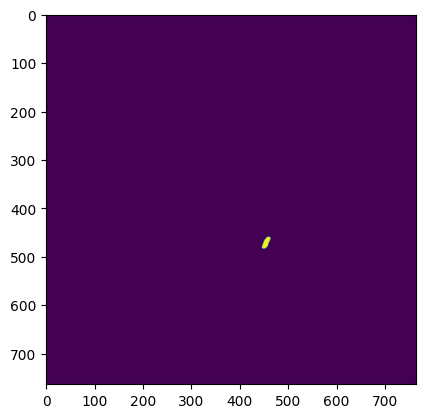

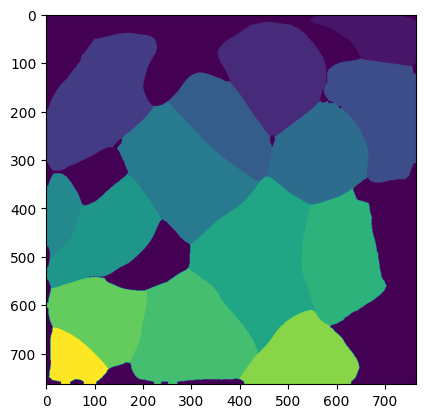

5410.0


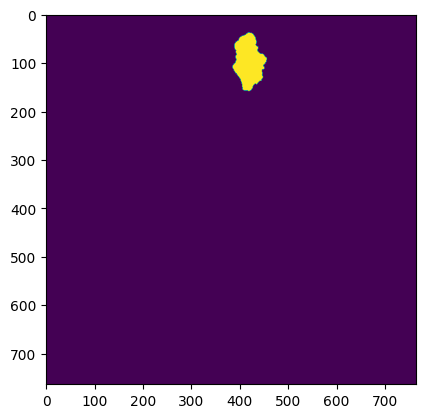

1214.0


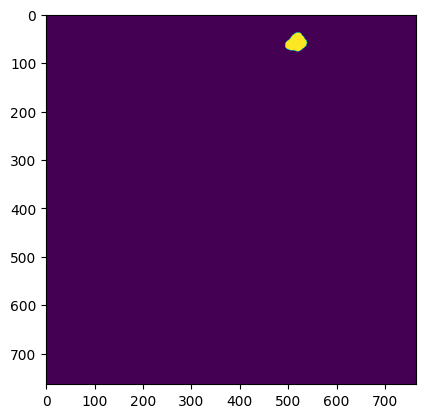

2465.0


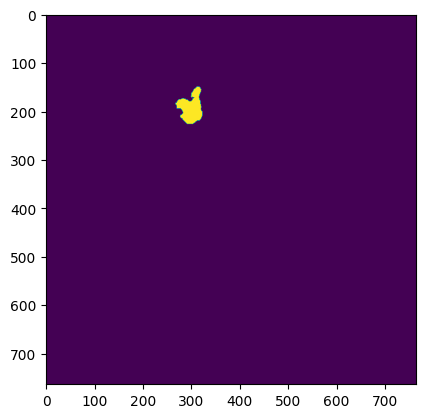

205.0


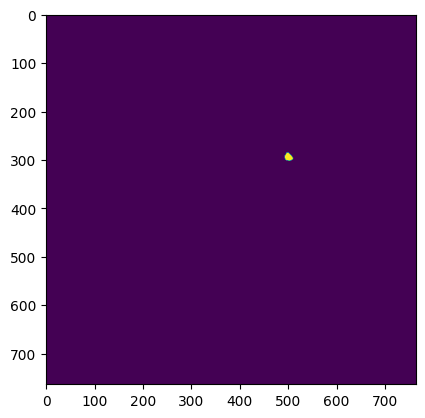

220.0


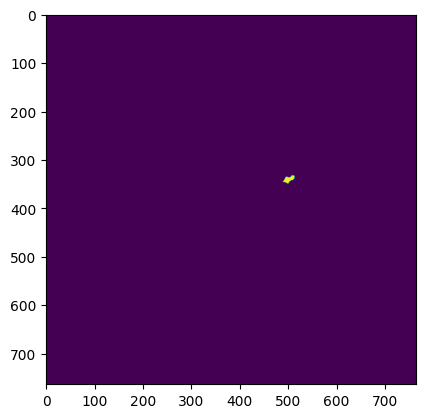

222.0


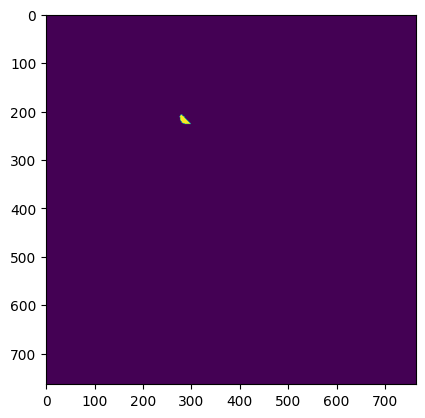

2568.0


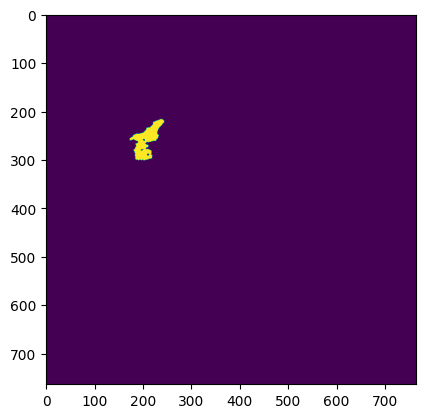

572.0


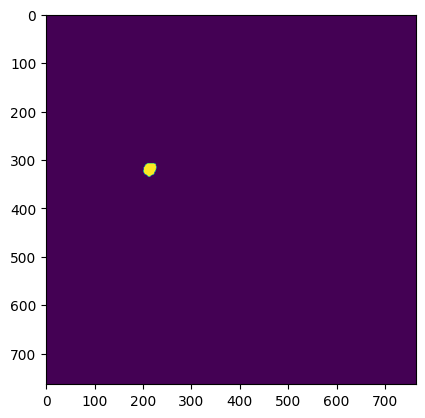

540.0


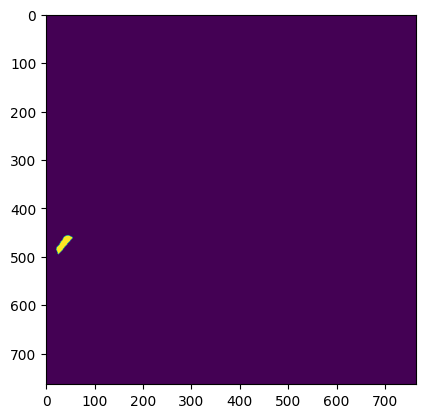

143.0


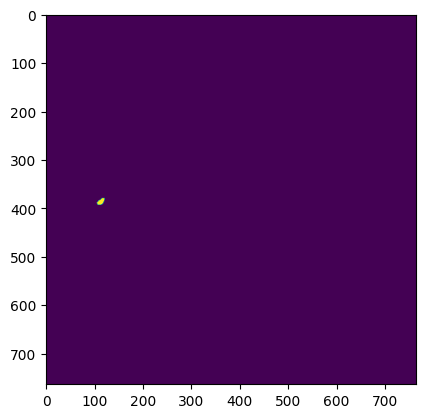

62.0


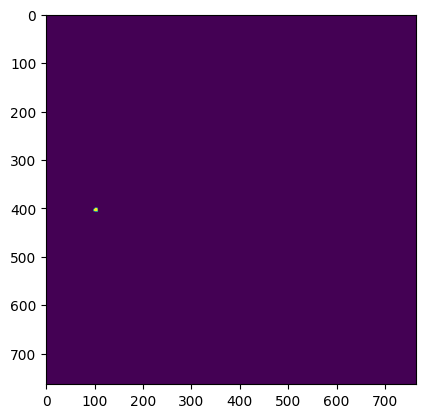

44.0


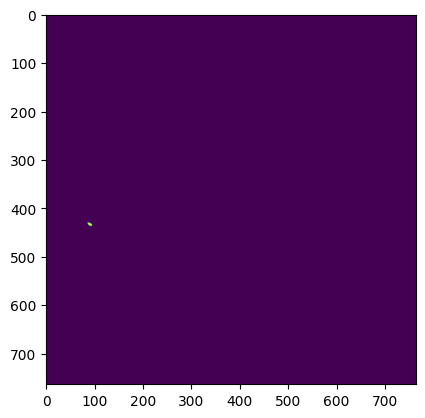

383.0


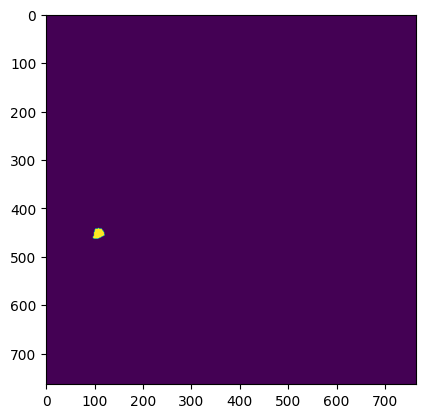

956.0


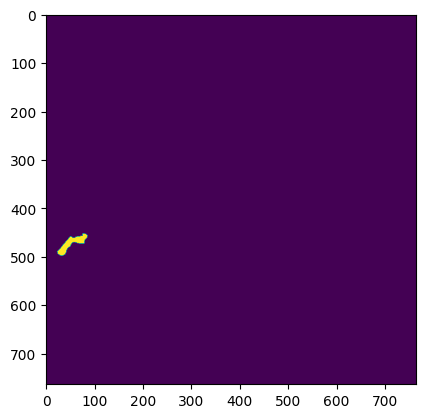

192.0


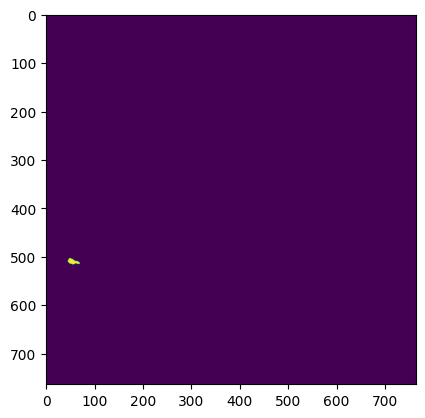

86.0


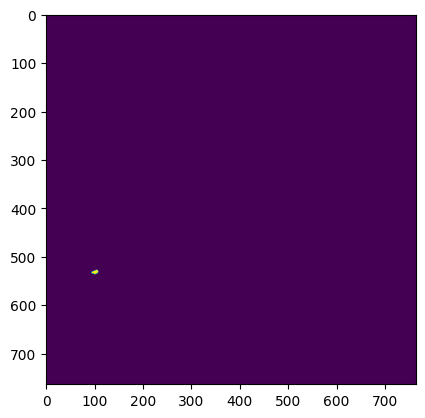

94.0


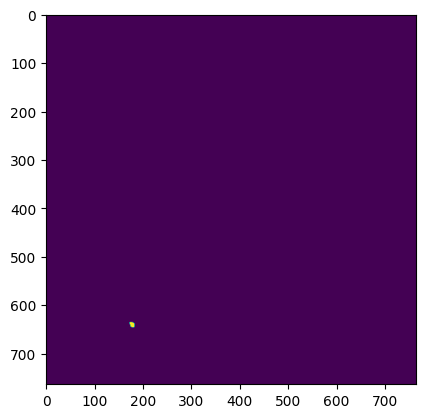

27.0


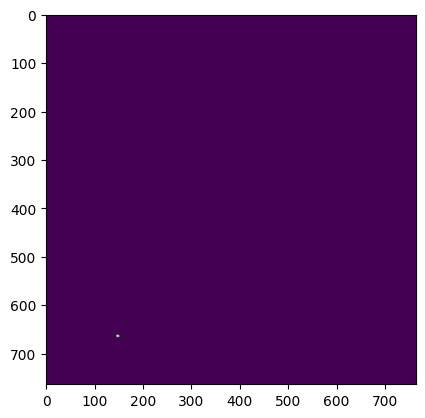

63.0


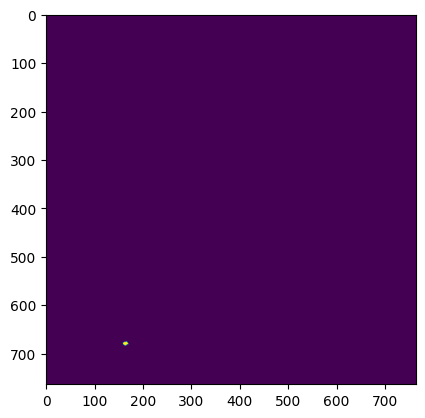

114.0


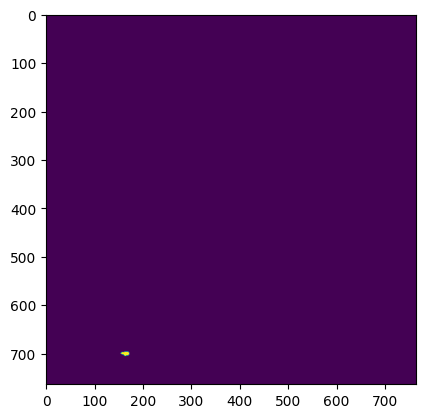

59.0


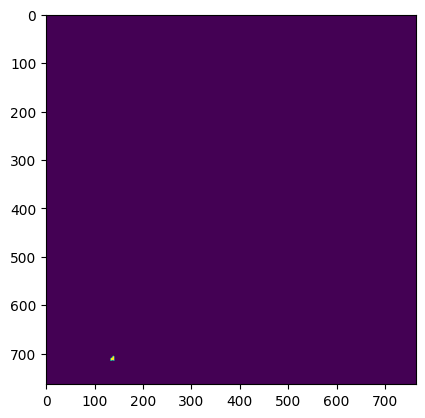

655.0


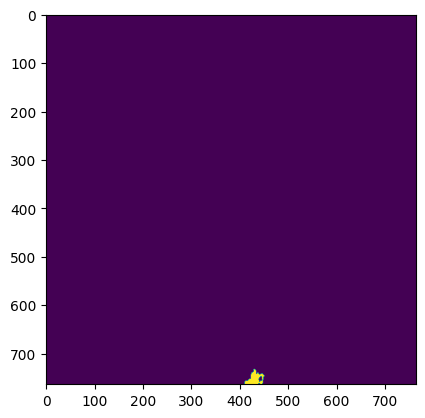

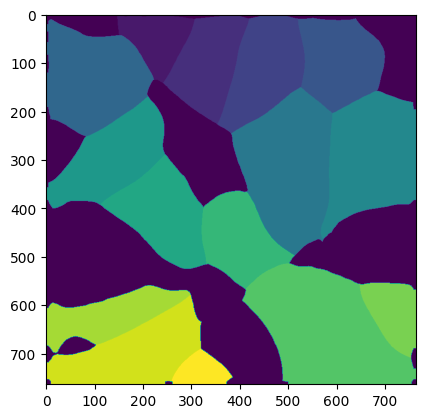

48.0


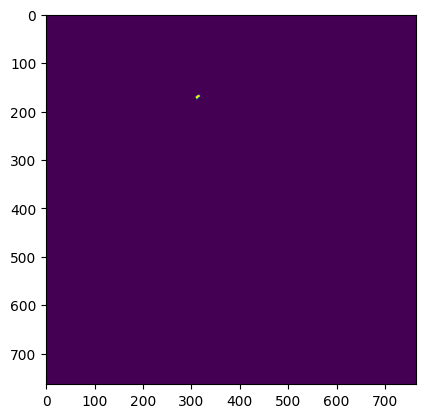

122.0


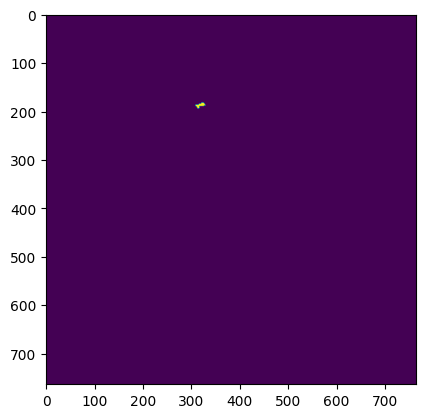

14.0


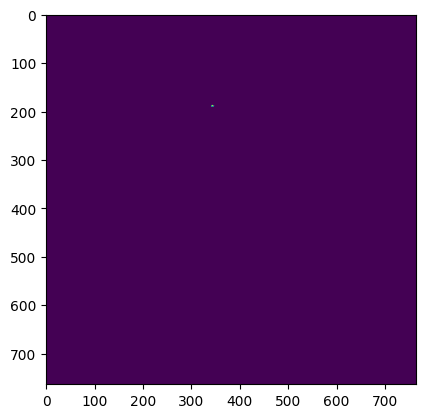

19.0


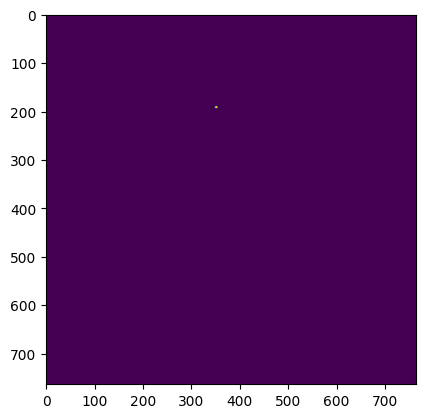

18.0


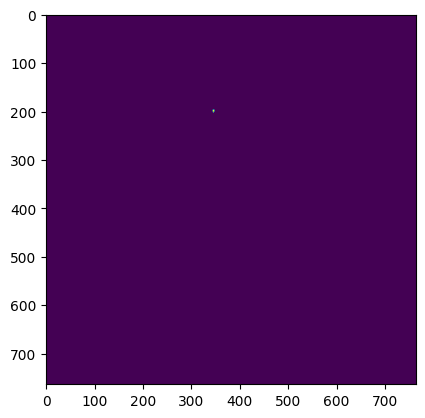

18.0


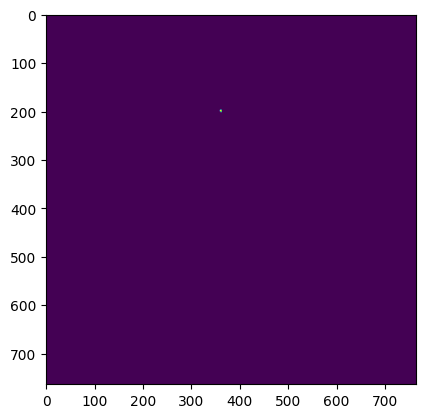

25.0


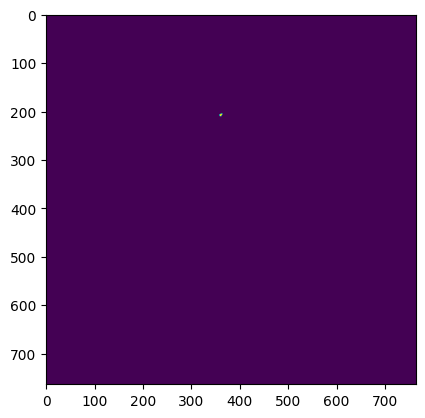

668.0


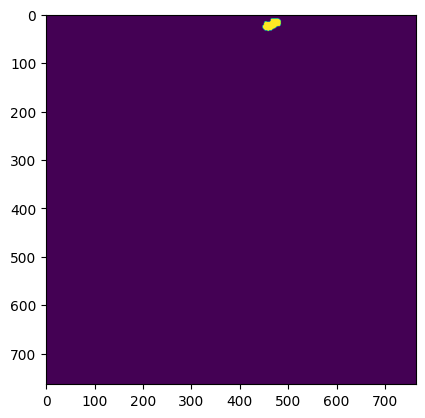

51.0


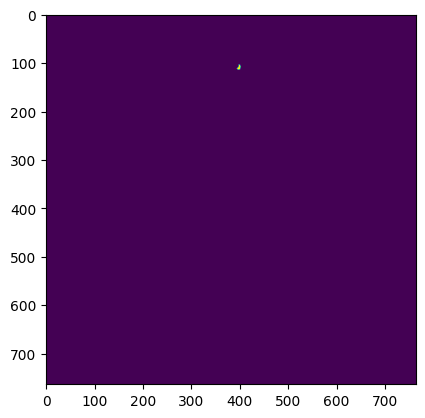

47.0


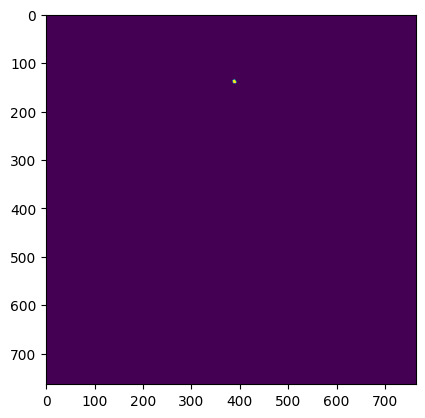

46.0


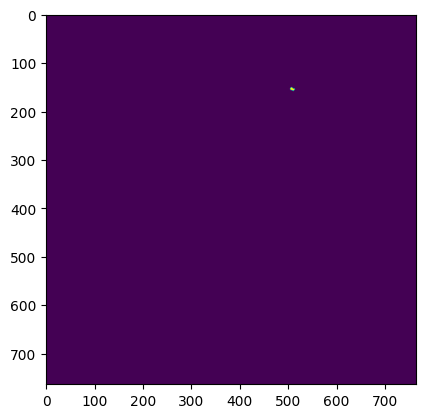

263.0


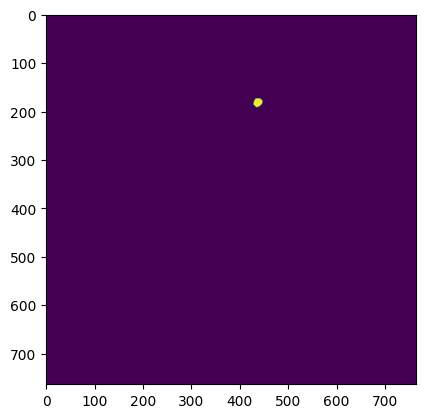

681.0


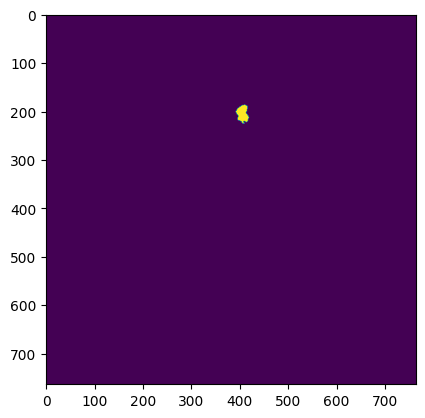

22.0


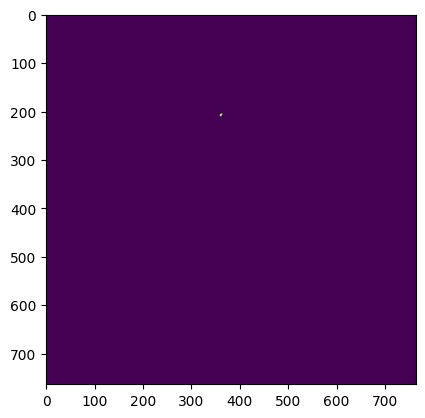

19.0


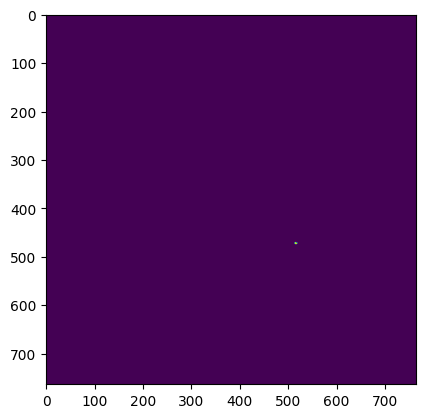

155.0


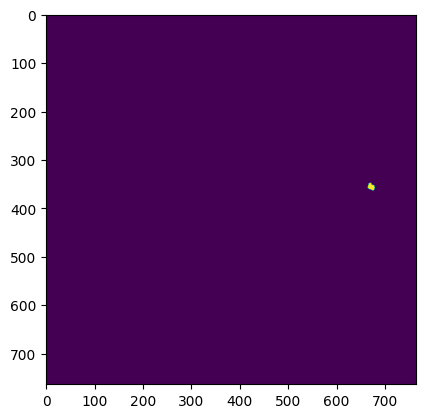

182.0


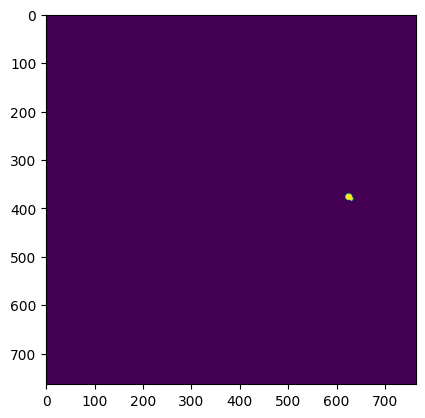

76.0


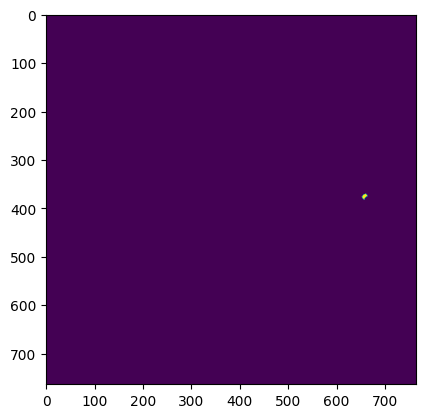

52.0


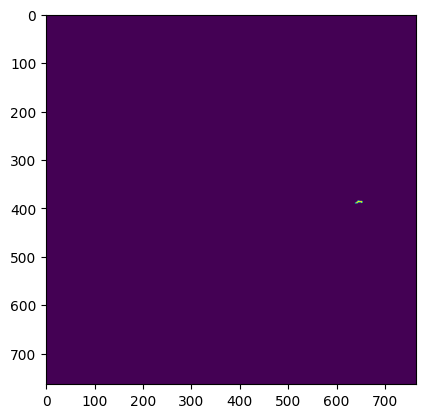

94.0


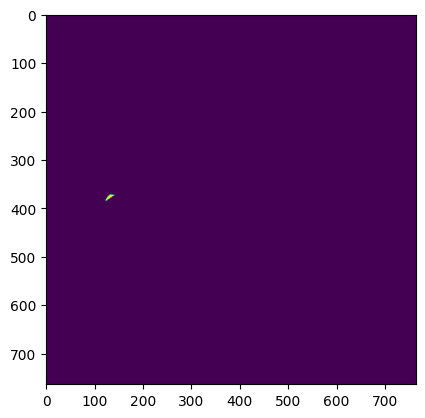

365.0


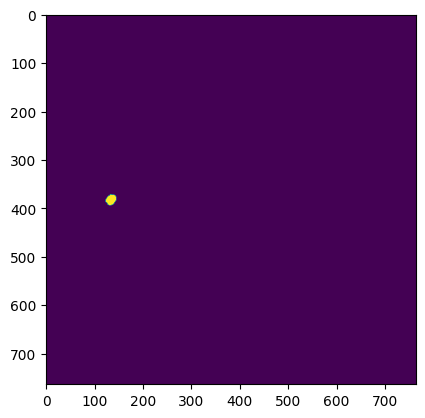

57.0


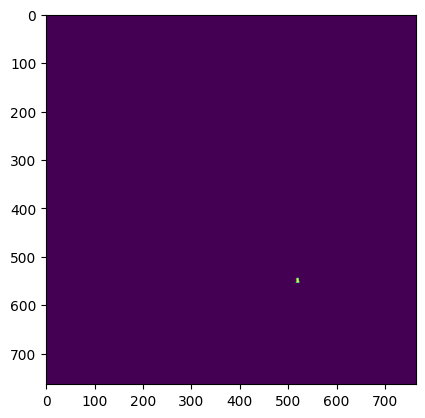

13.0


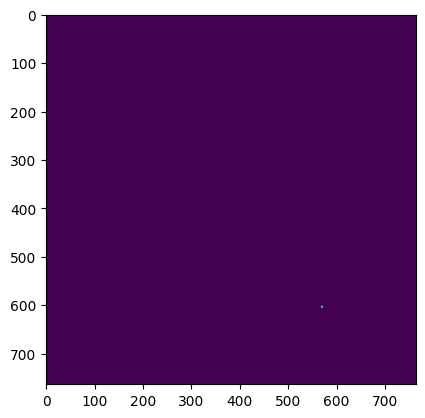

237.0


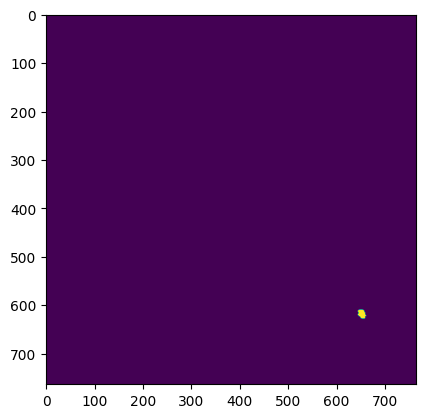

51.0


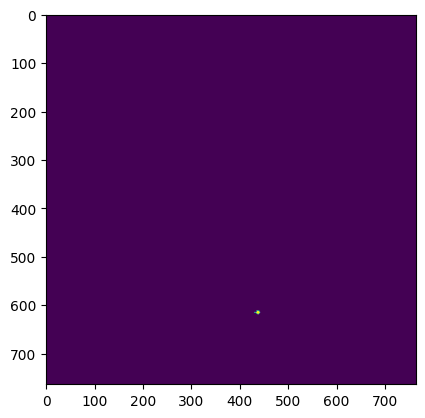

449.0


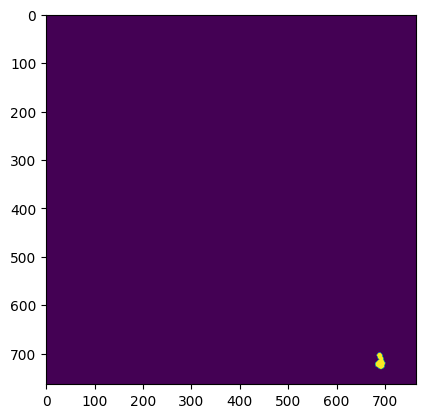

66.0


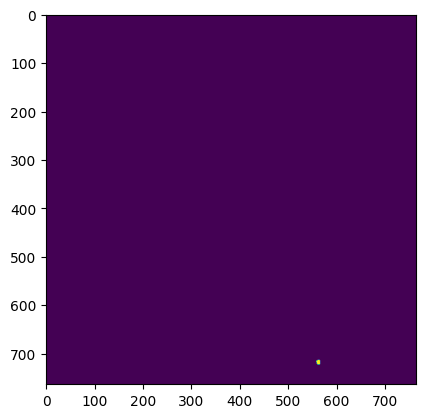

37.0


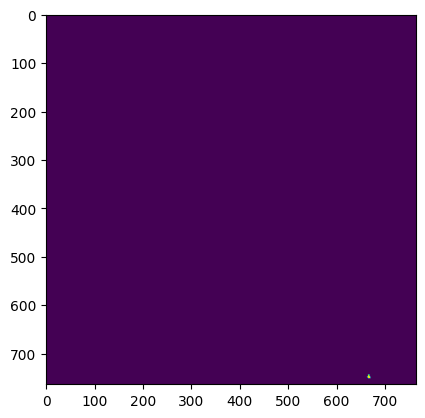

297.0


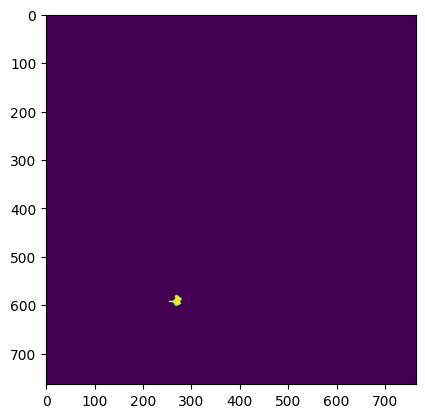

78.0


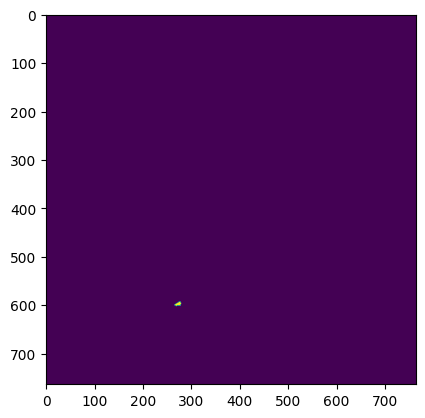

23.0


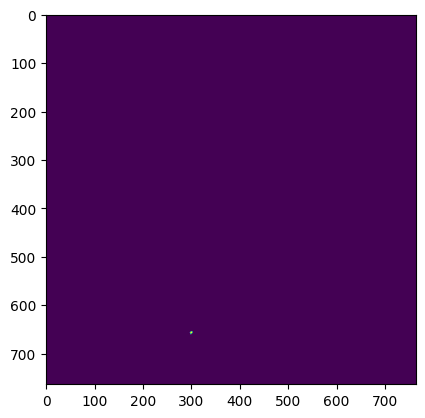

28.0


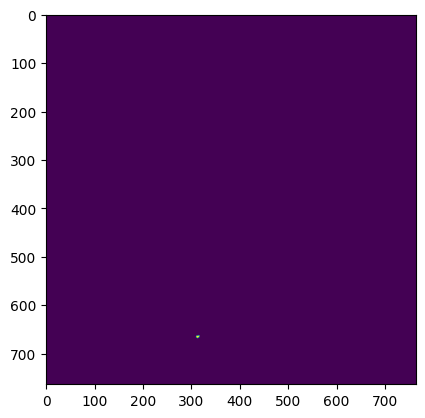

22.0


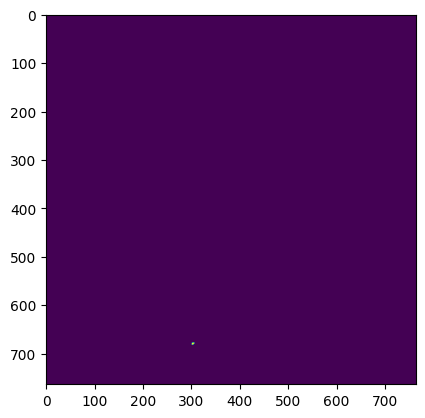

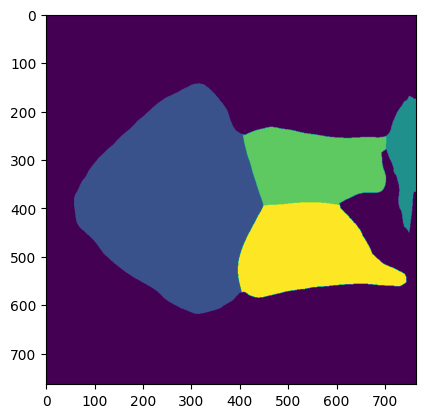

8337.0


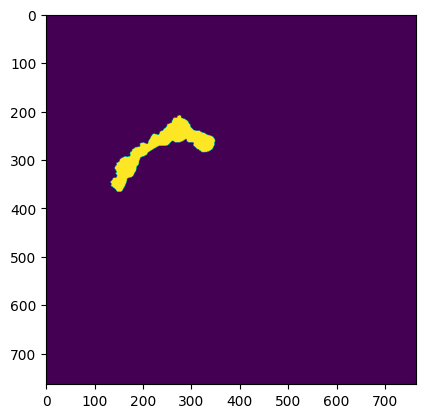

81.0


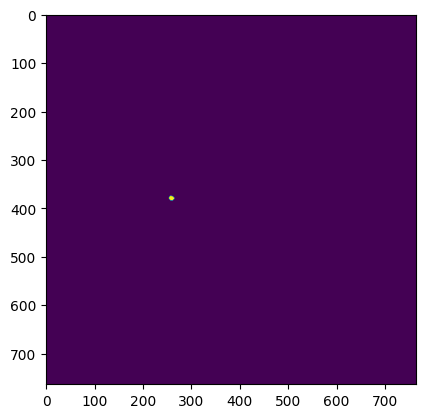

190.0


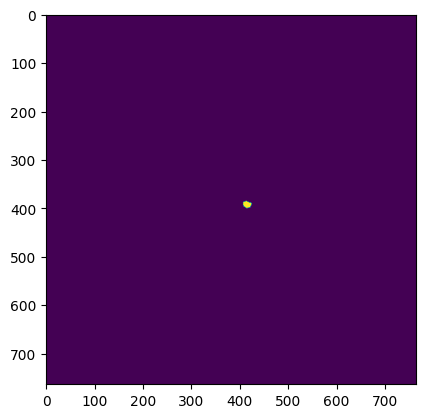

55.0


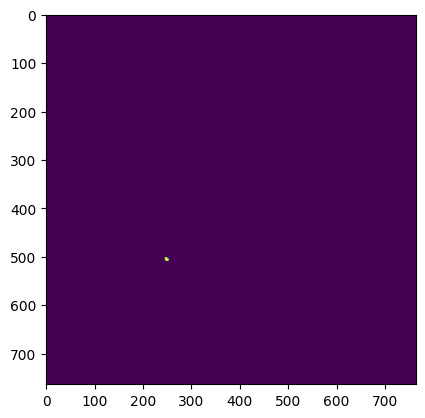

212.0


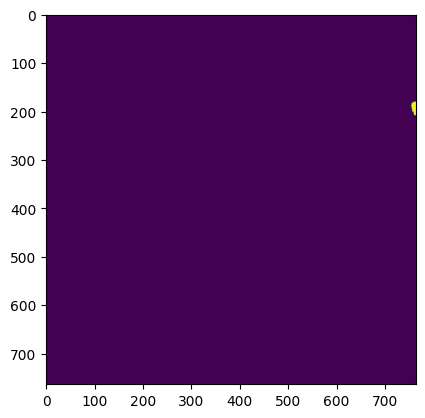

328.0


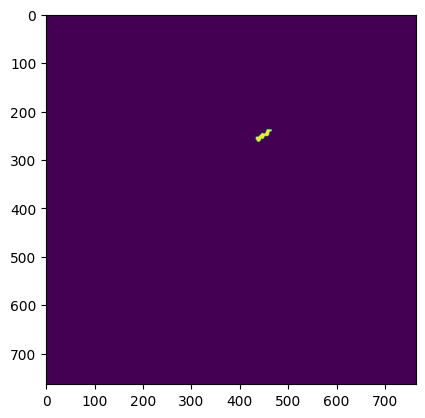

53.0


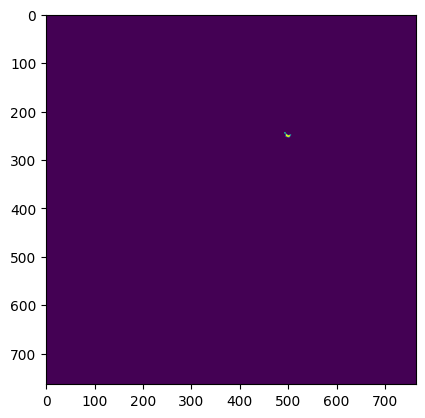

160.0


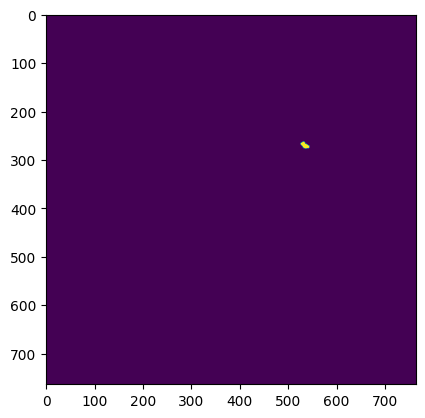

46.0


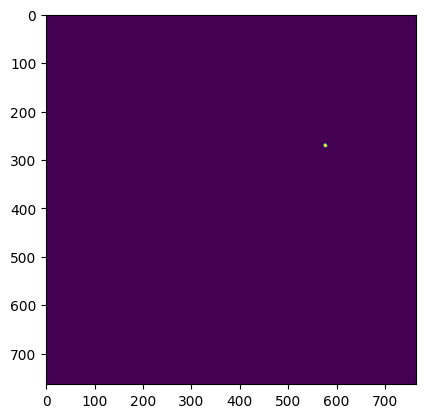

435.0


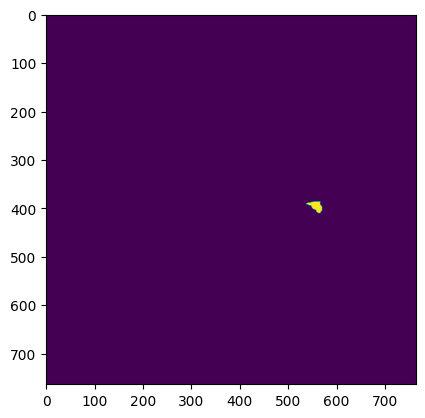

5925.0


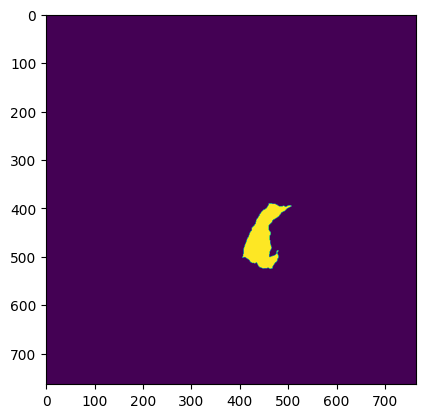

883.0


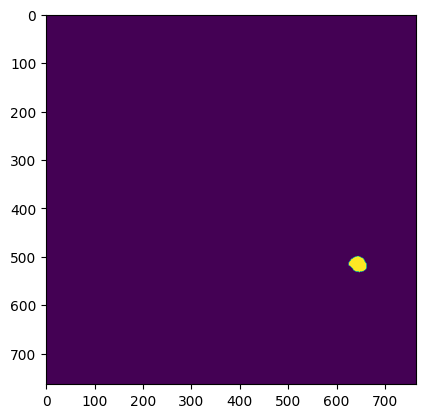

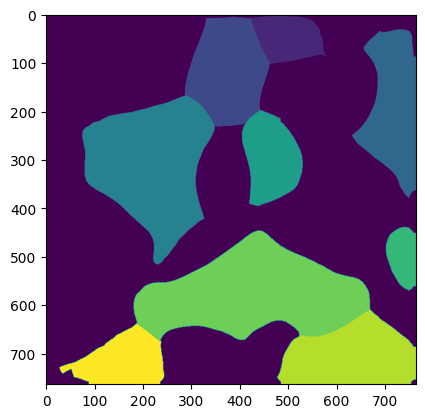

102.0


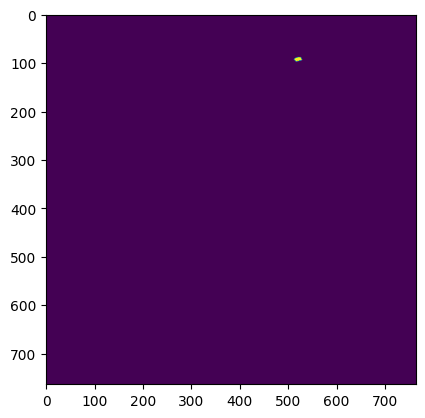

2310.0


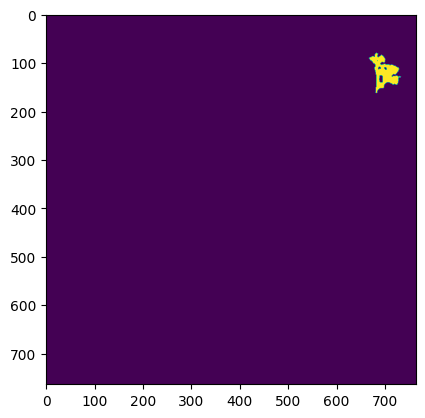

46.0


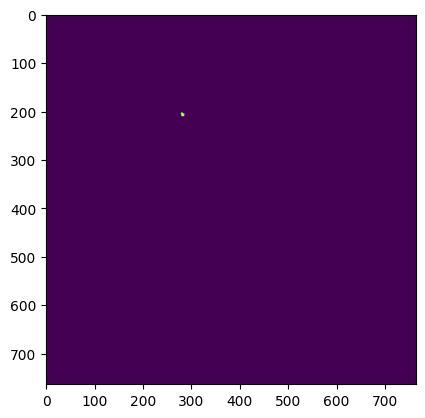

1580.0


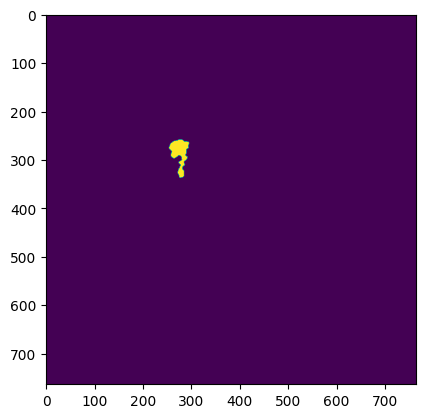

254.0


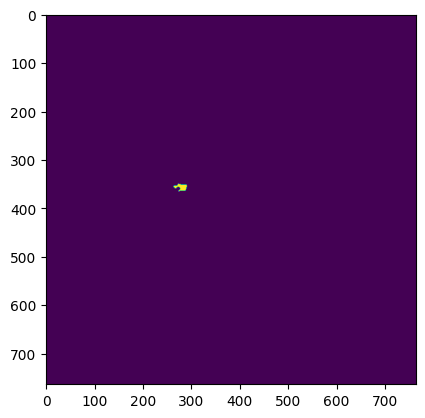

33.0


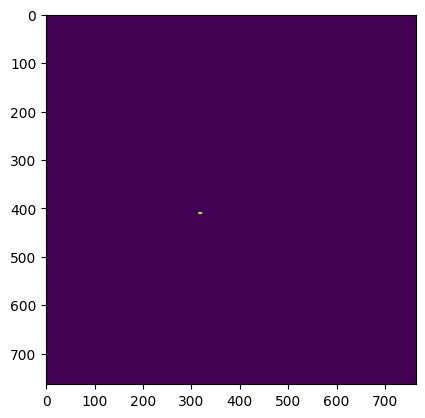

35.0


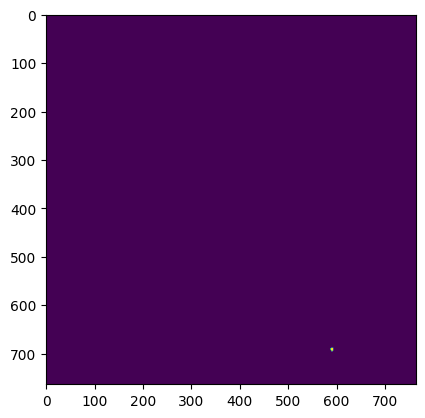

29.0


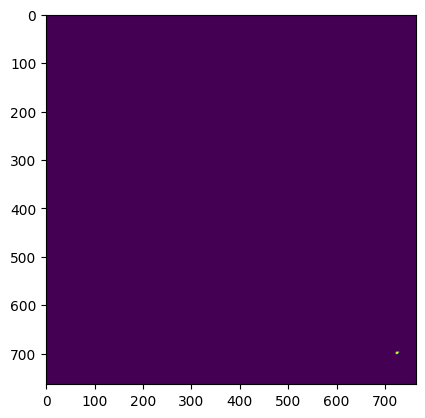

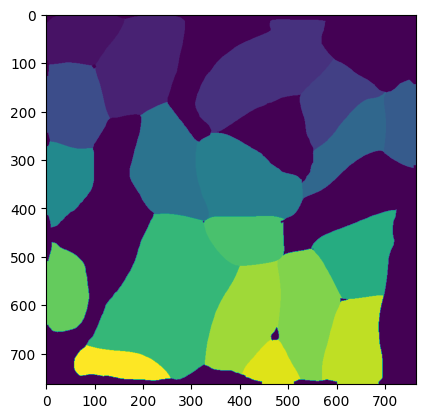

16.0


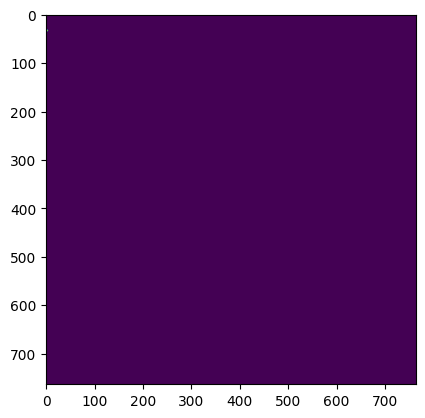

41.0


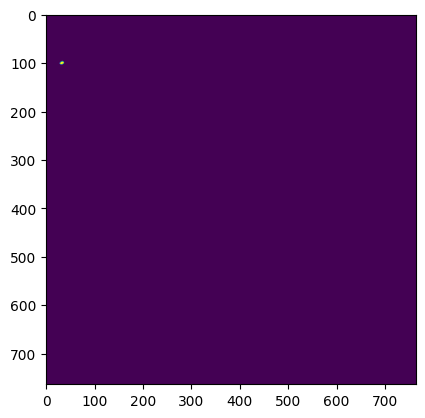

18.0


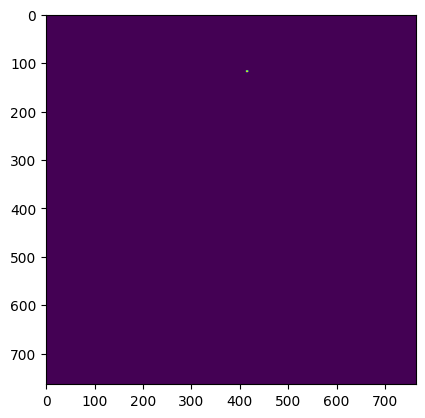

15.0


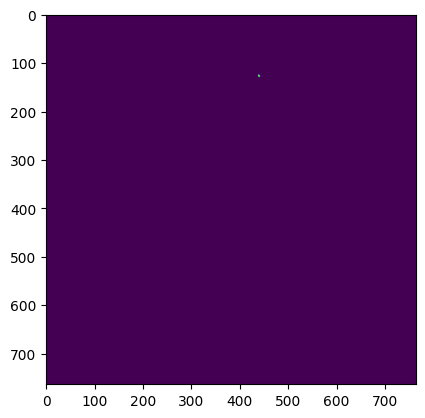

814.0


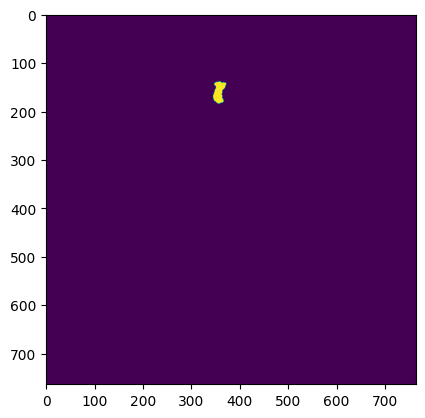

38.0


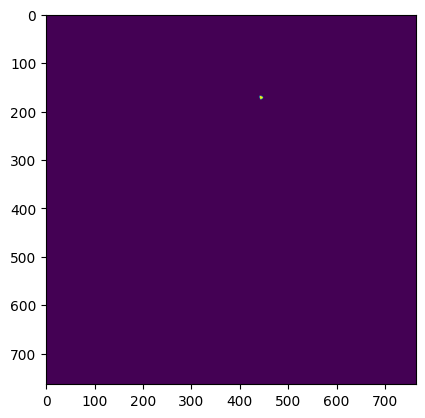

55.0


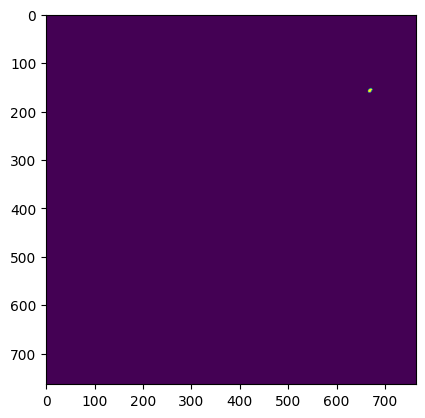

557.0


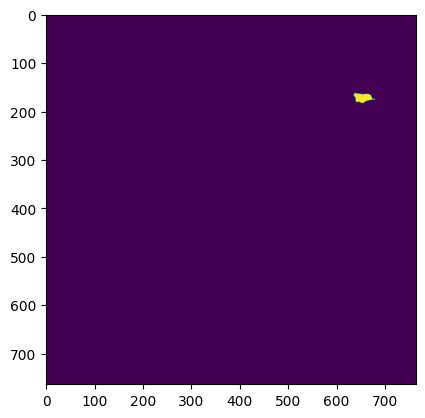

140.0


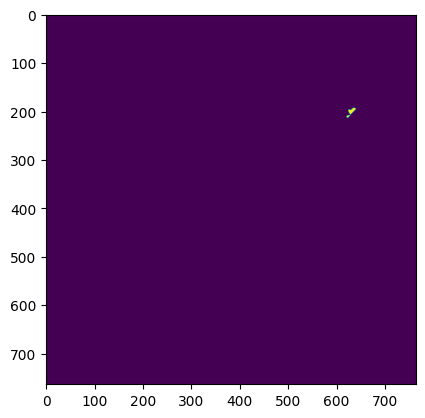

26.0


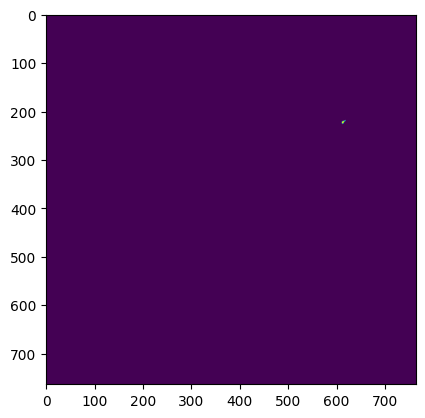

38.0


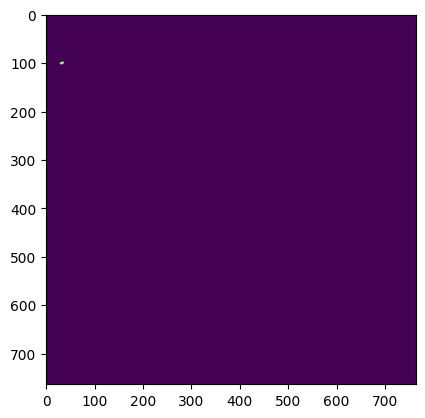

523.0


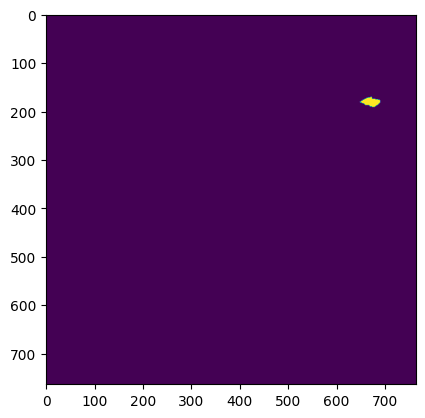

195.0


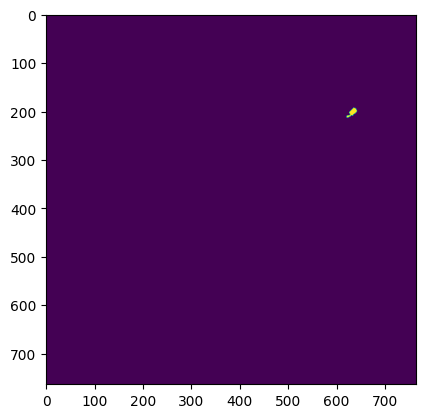

93.0


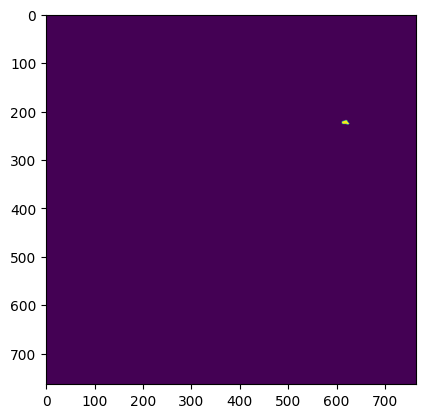

1391.0


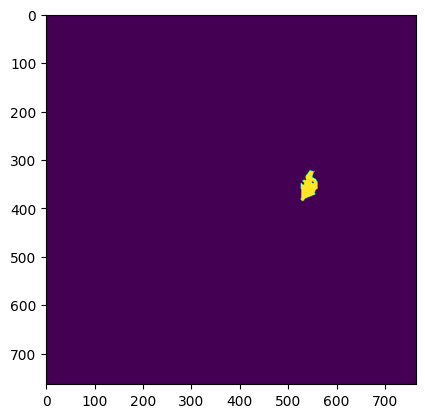

965.0


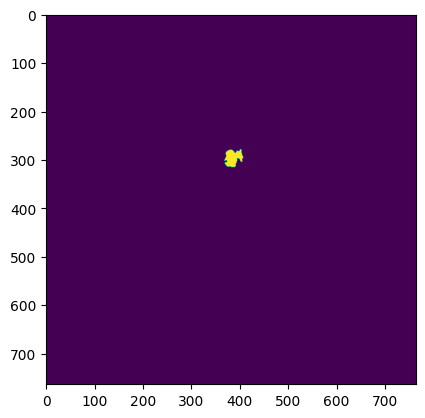

406.0


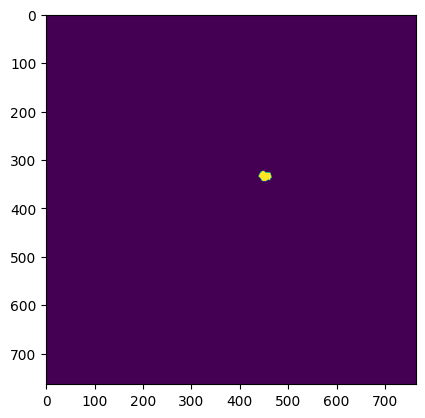

335.0


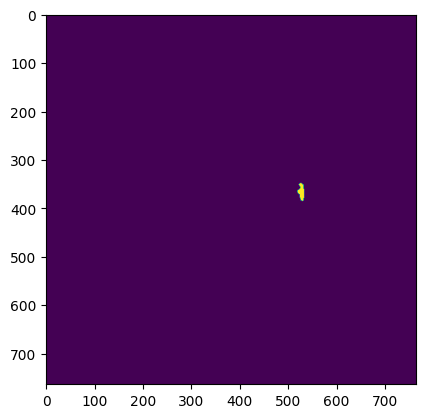

215.0


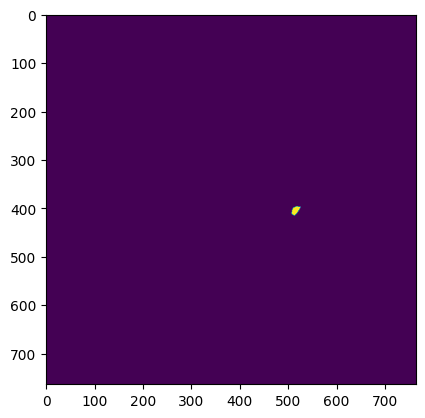

104.0


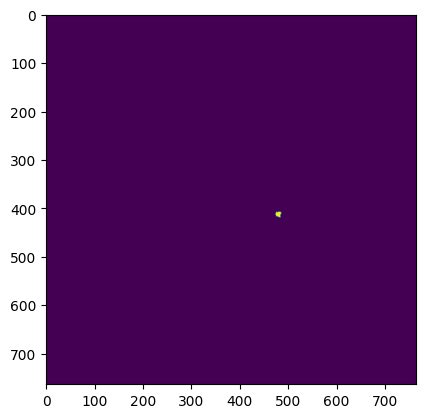

240.0


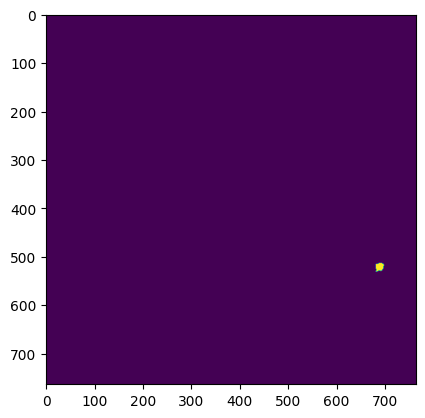

352.0


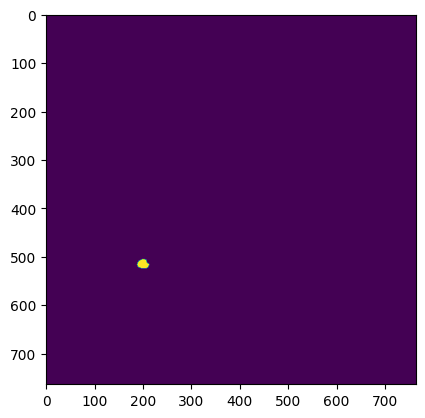

11.0


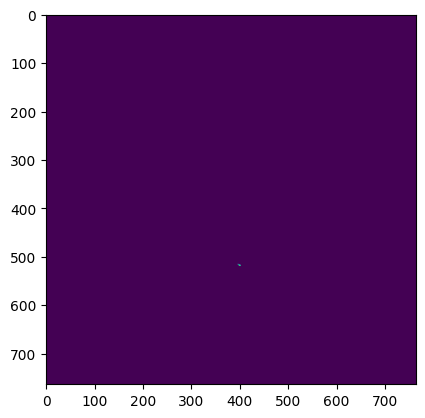

24.0


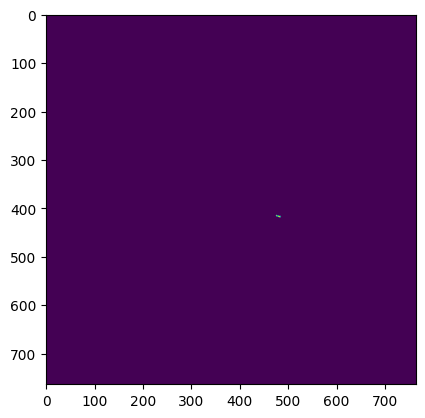

260.0


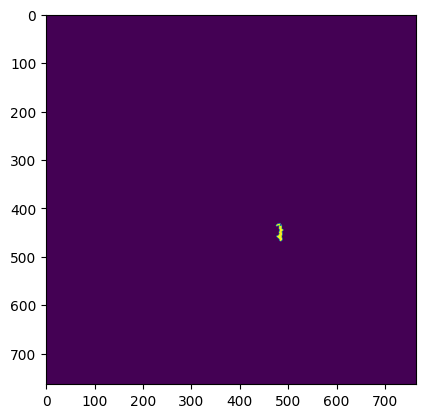

225.0


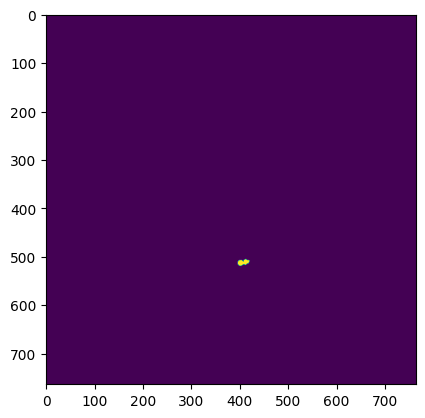

1159.0


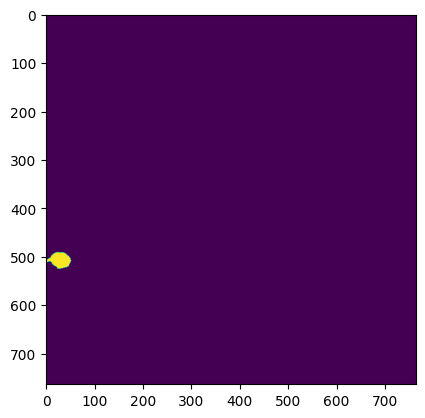

220.0


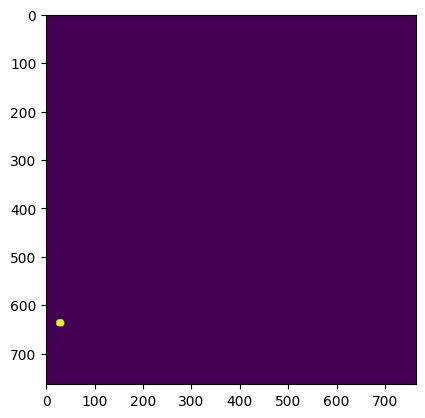

19.0


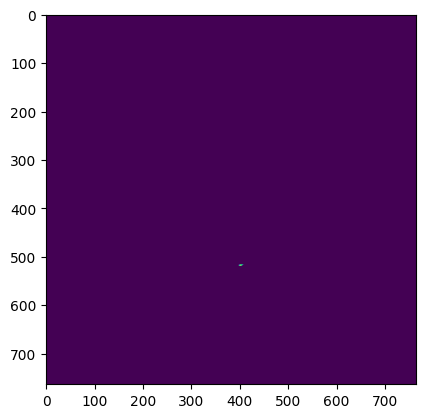

78.0


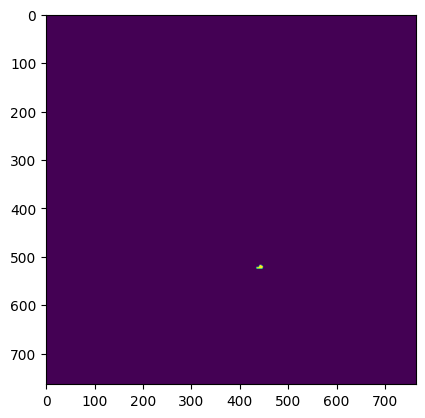

42.0


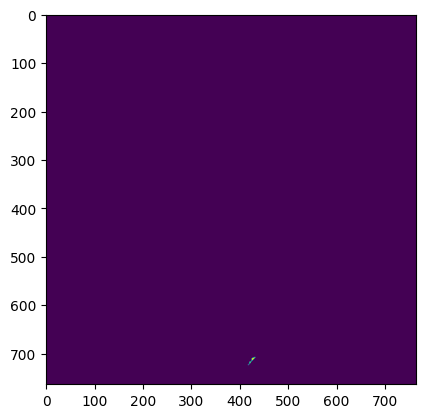

382.0


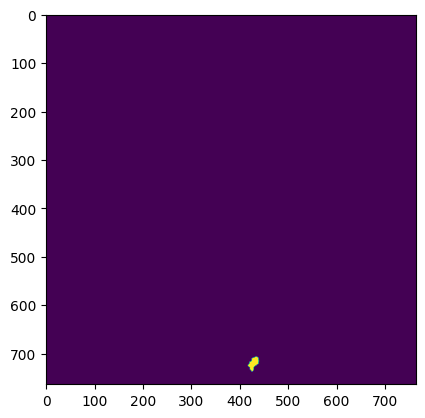

45.0


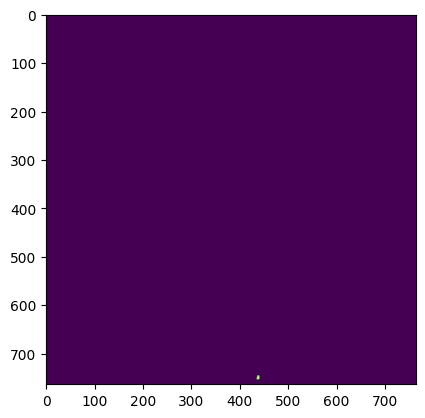

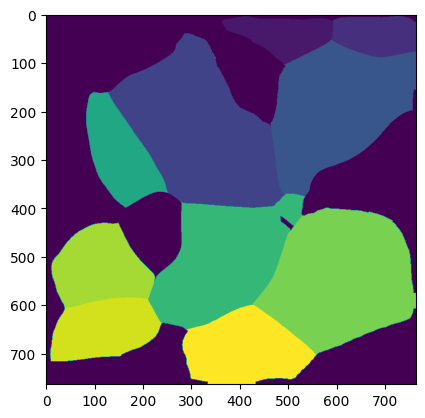

46.0


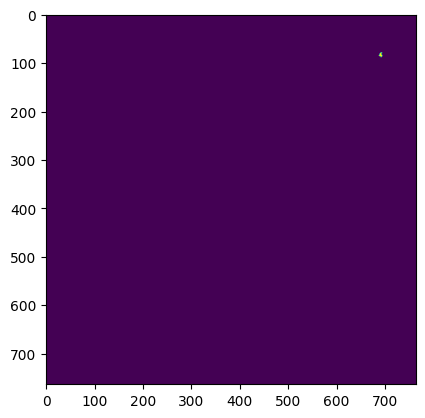

26.0


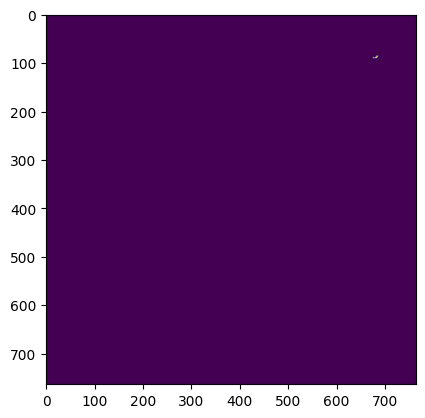

4761.0


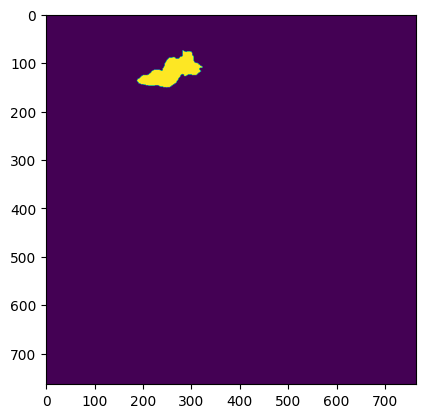

3443.0


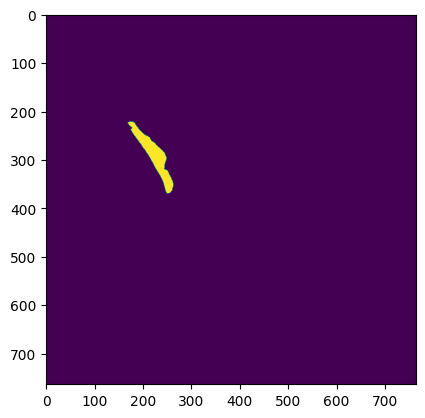

338.0


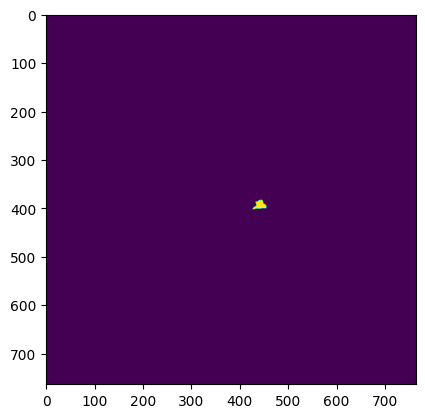

172.0


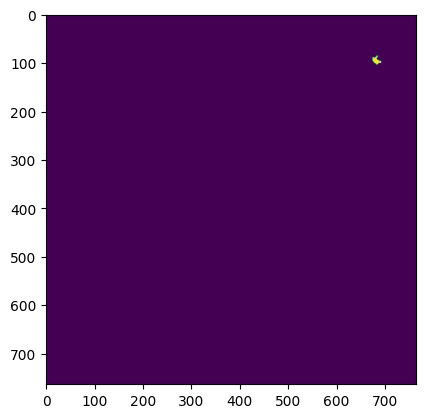

12.0


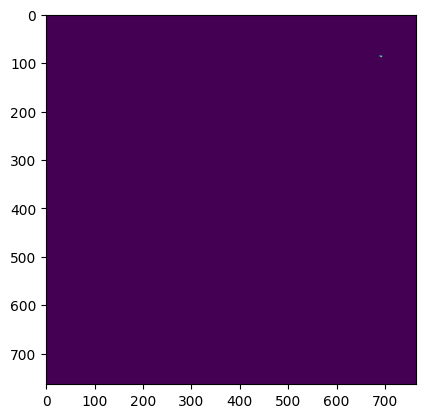

207.0


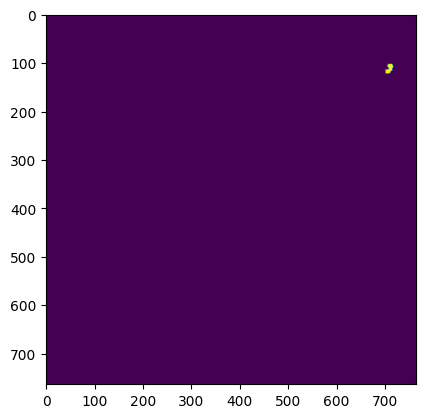

299.0


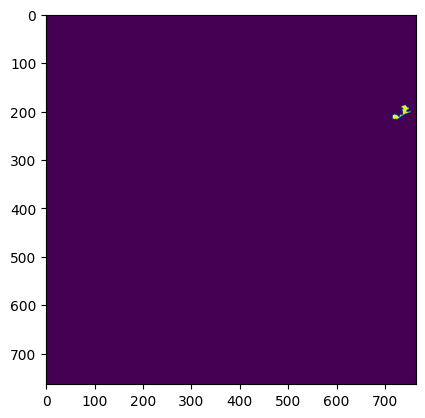

73.0


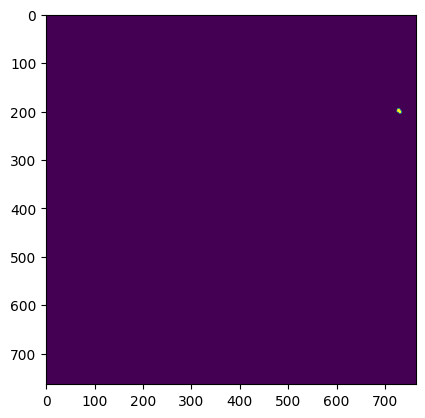

3938.0


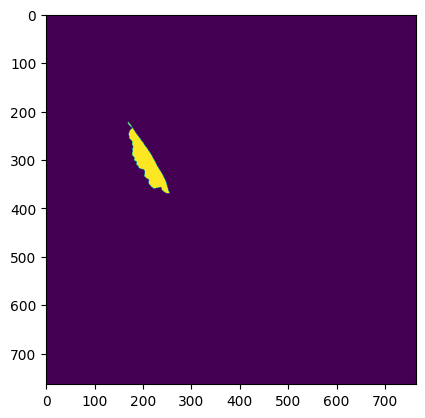

1969.0


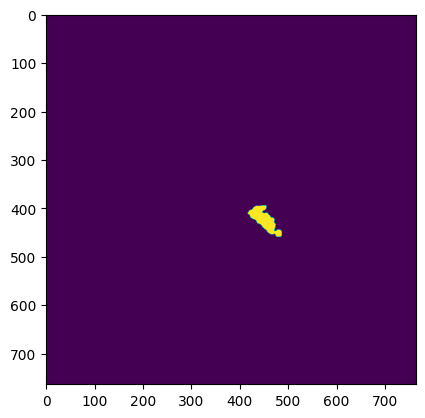

2409.0


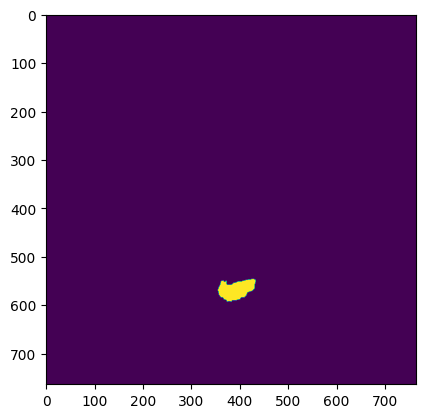

227.0


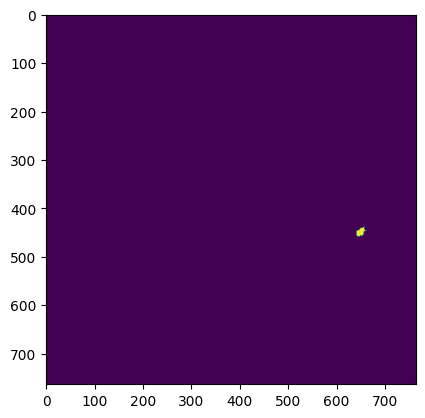

1819.0


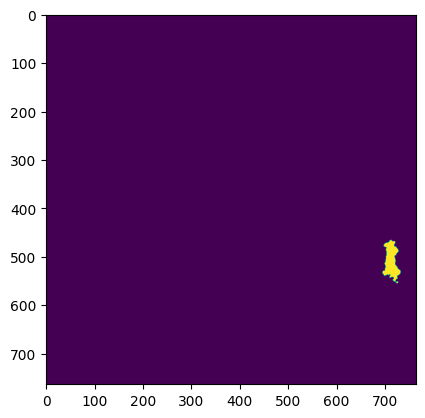

64.0


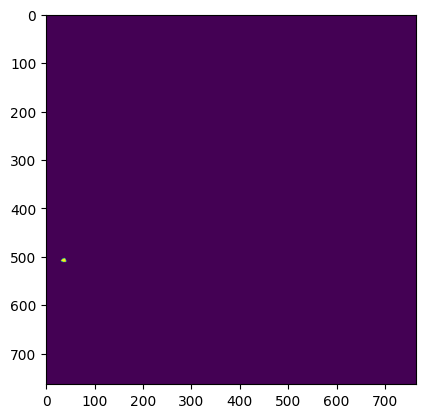

73.0


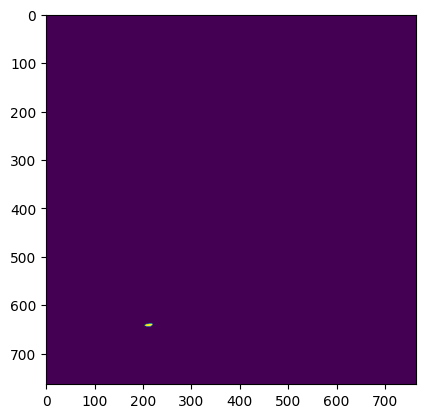

39.0


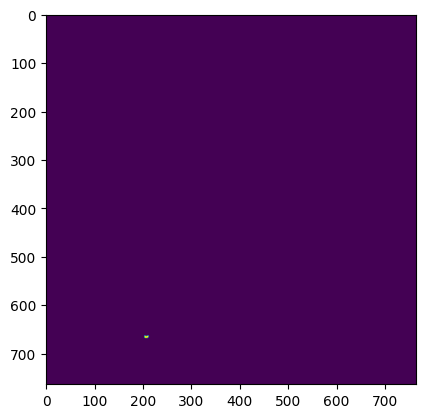

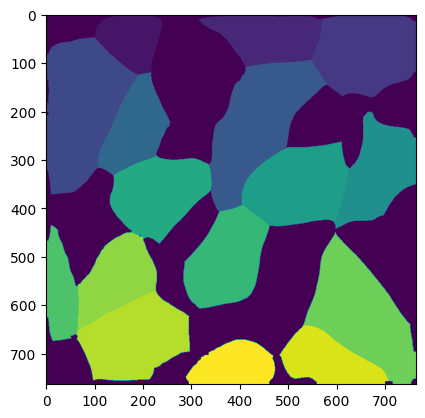

165.0


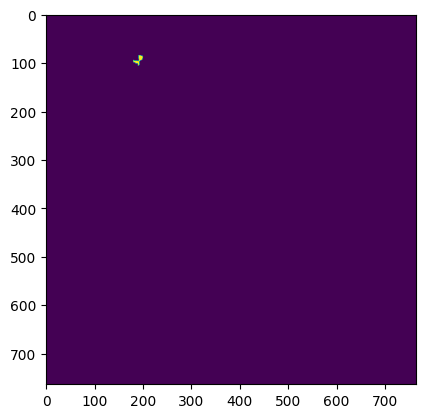

21.0


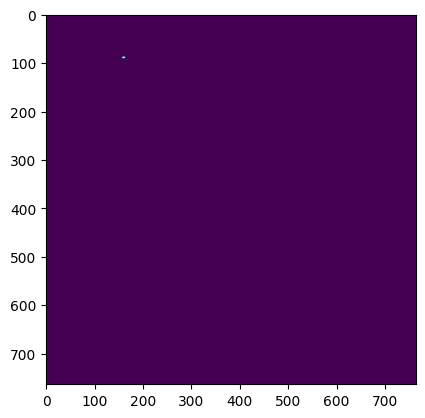

18.0


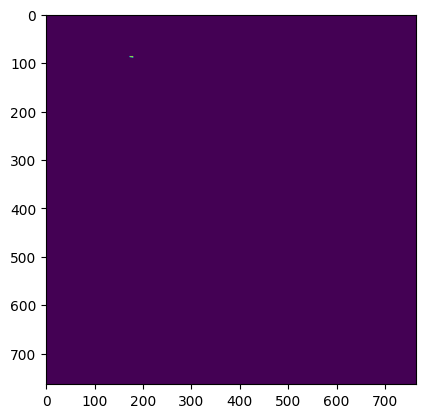

15.0


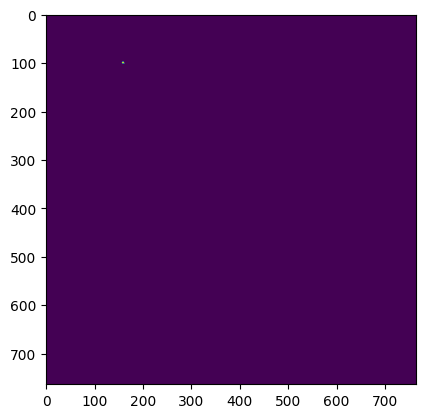

140.0


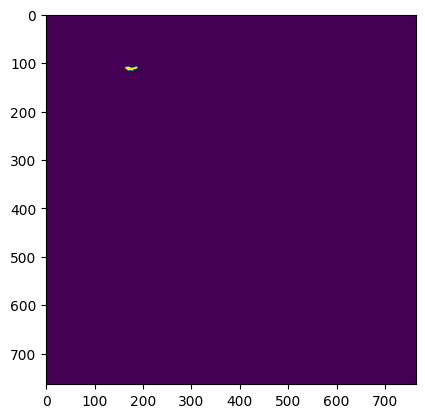

145.0


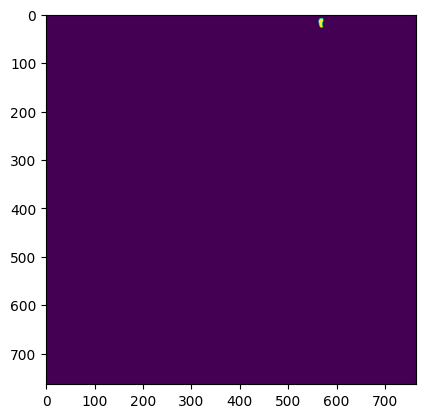

15.0


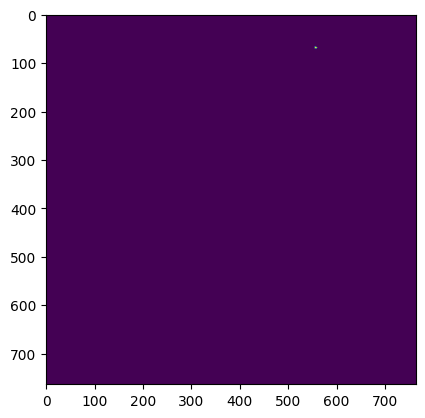

125.0


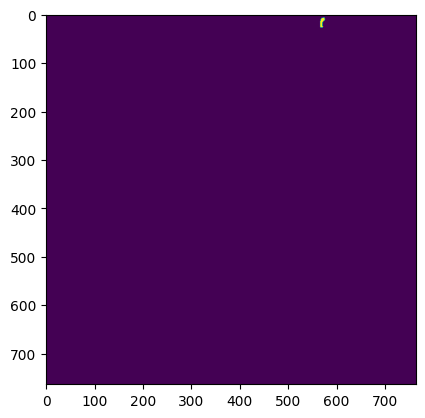

19.0


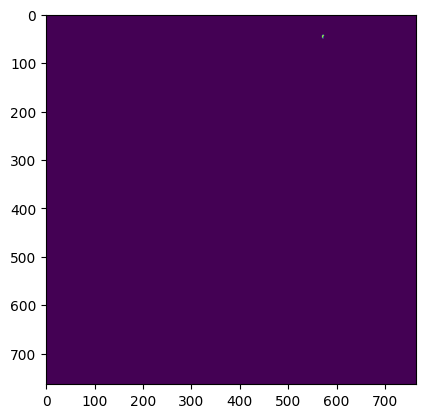

12.0


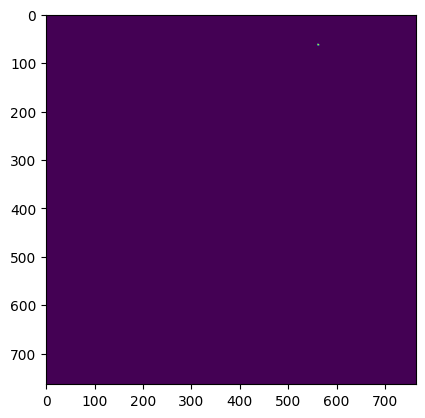

15.0


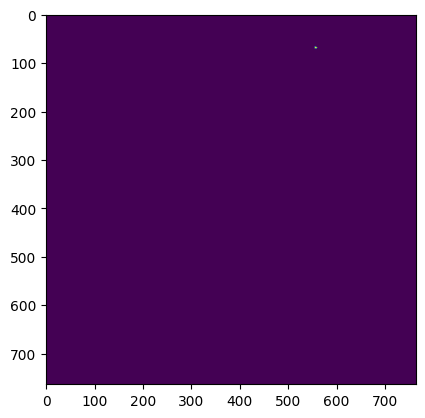

207.0


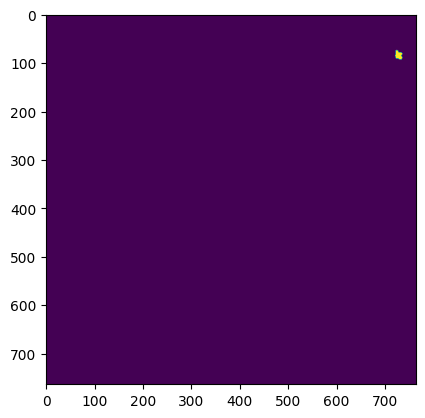

19.0


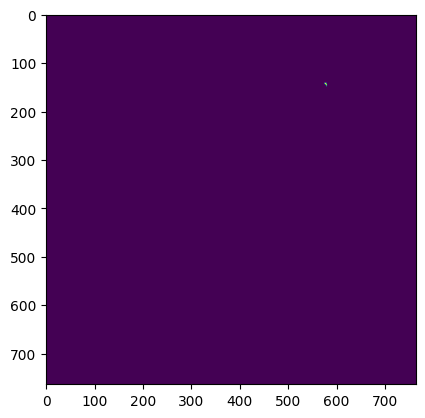

68.0


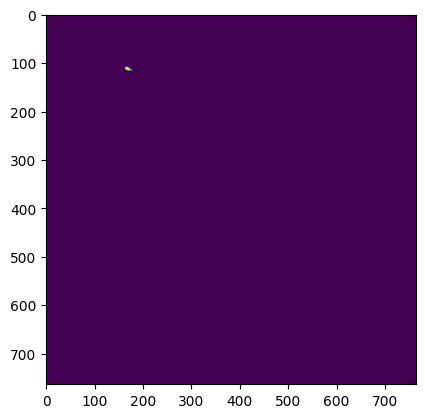

237.0


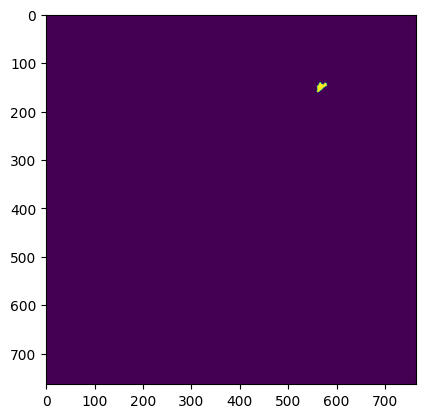

161.0


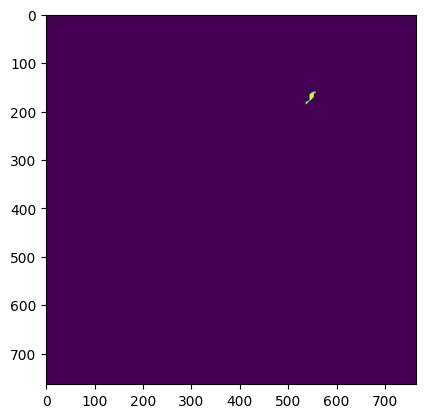

415.0


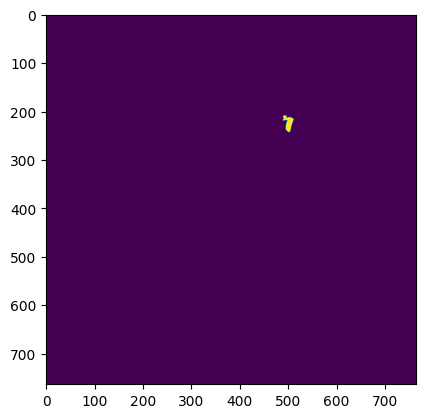

49.0


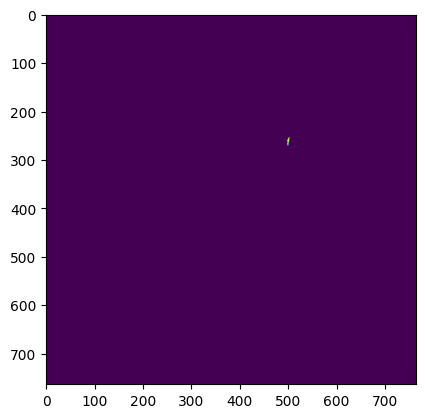

11.0


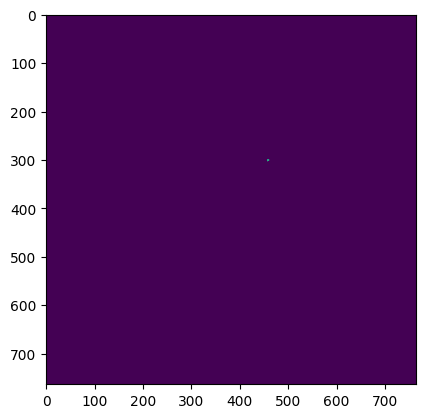

178.0


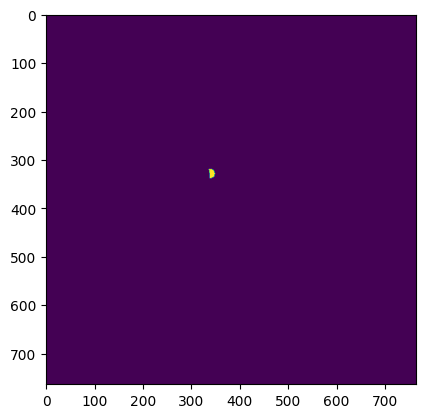

145.0


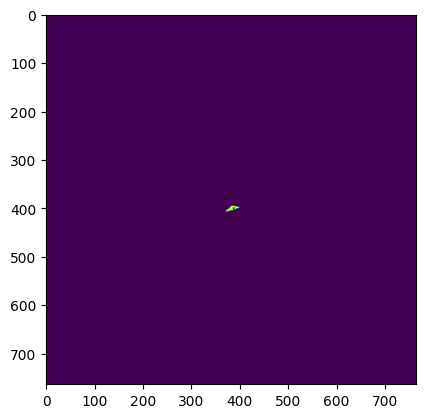

17.0


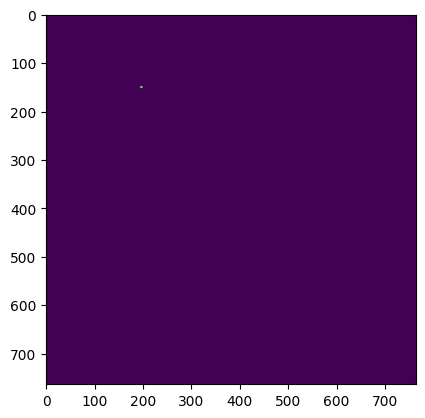

92.0


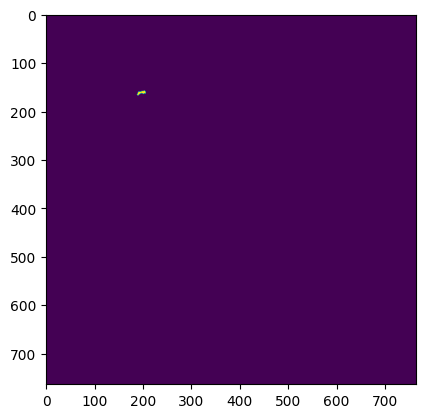

45.0


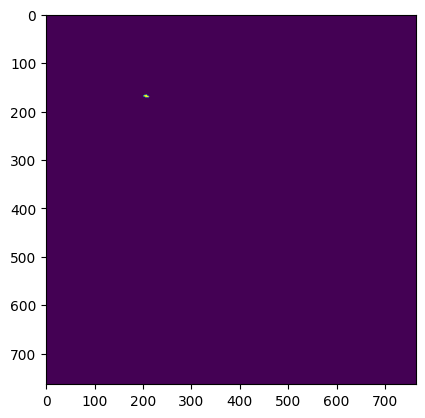

22.0


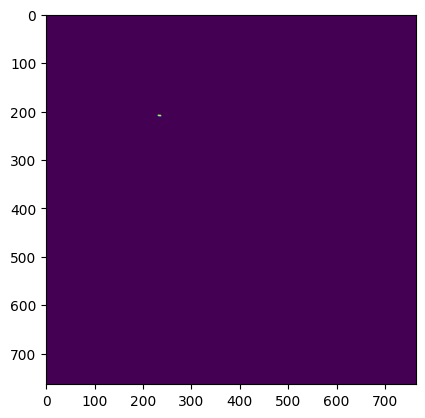

287.0


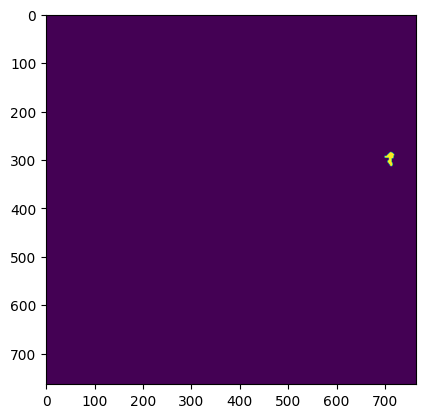

649.0


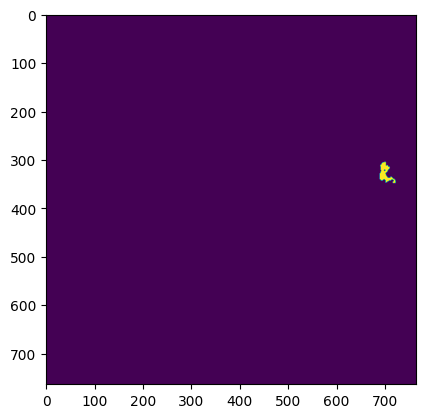

58.0


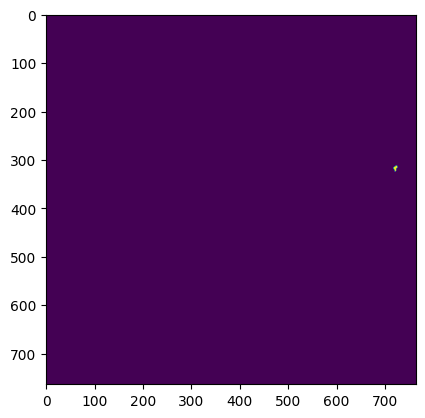

663.0


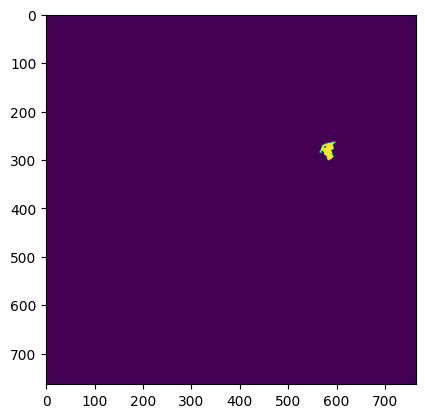

56.0


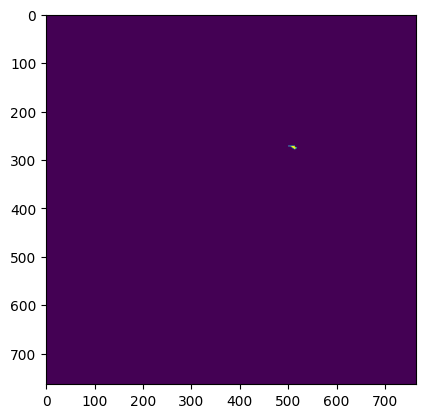

116.0


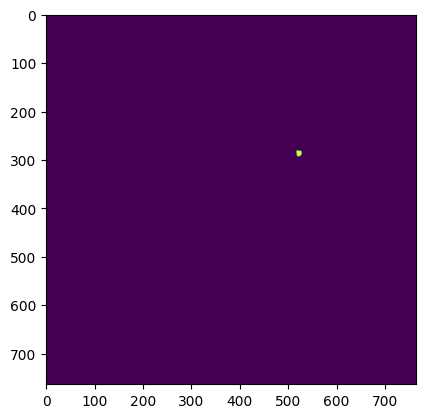

158.0


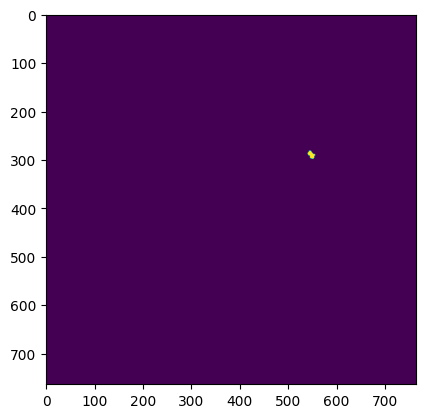

55.0


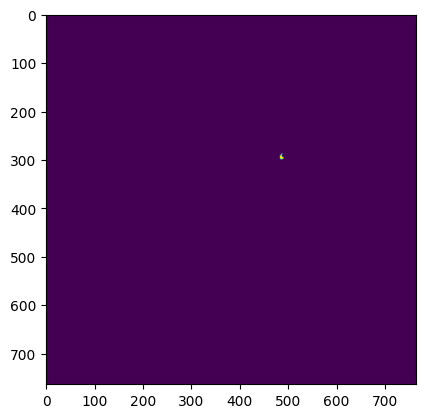

184.0


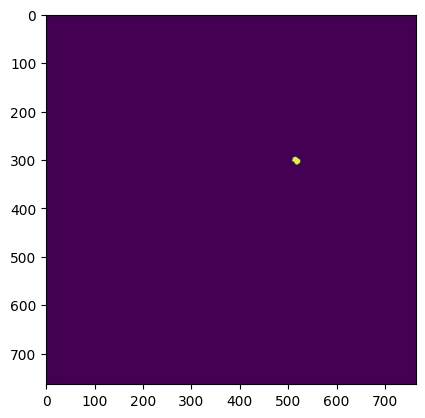

200.0


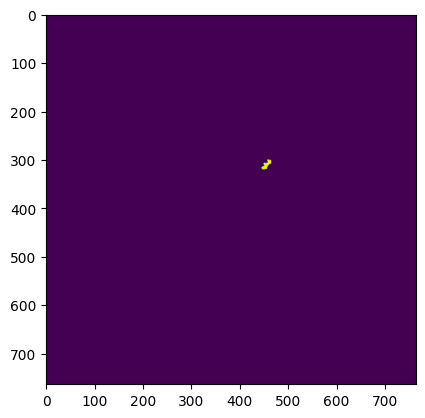

61.0


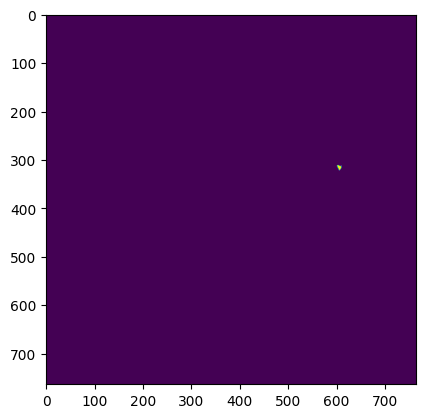

133.0


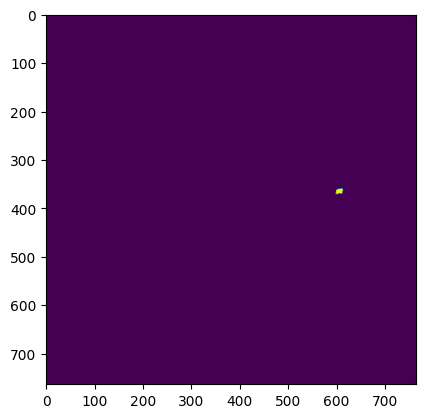

48.0


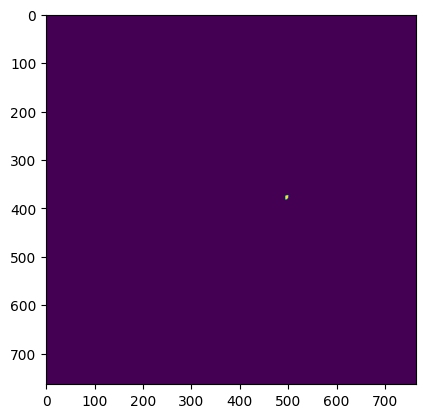

88.0


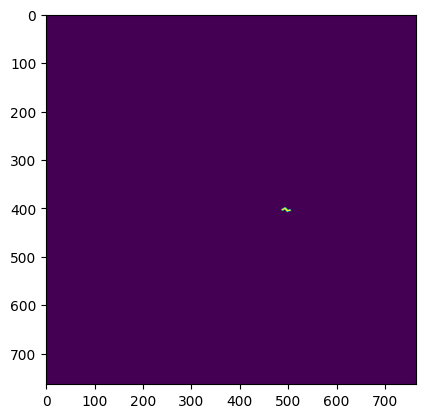

74.0


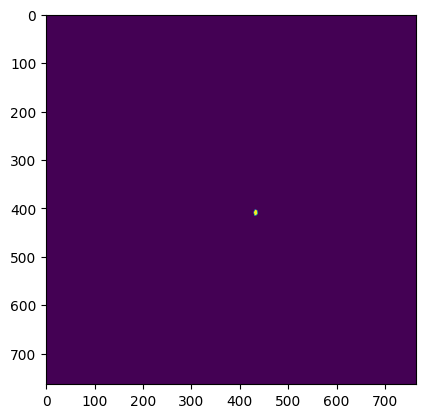

72.0


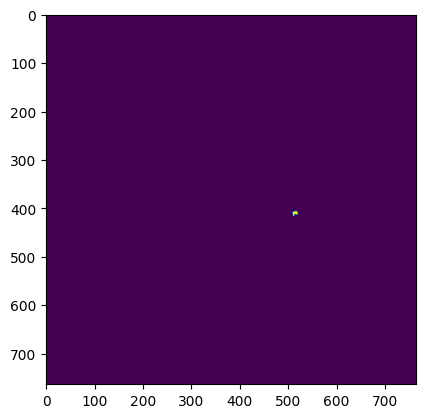

60.0


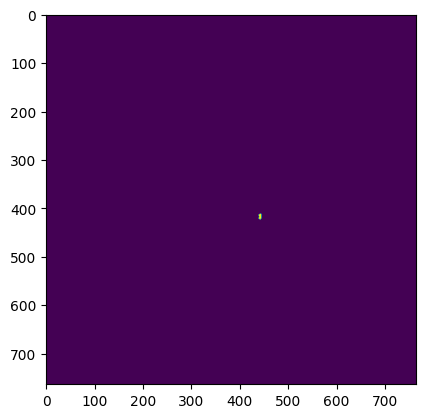

228.0


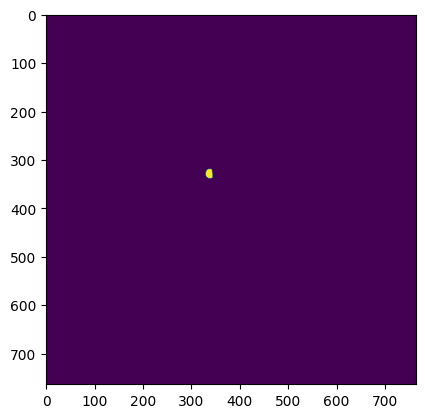

1754.0


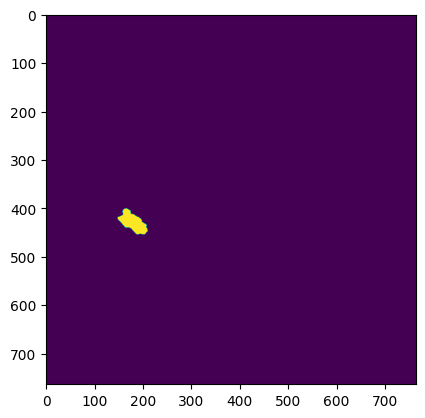

1017.0


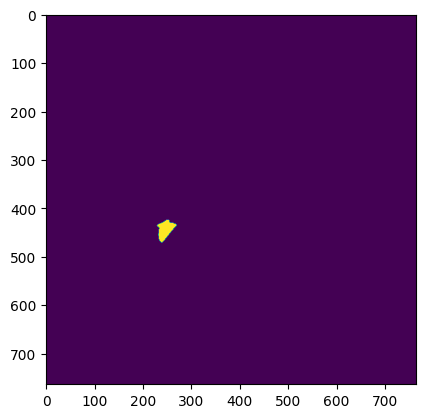

786.0


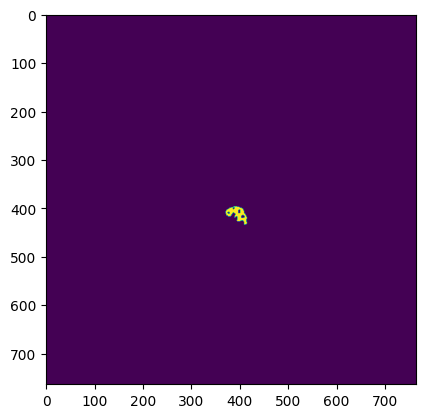

29.0


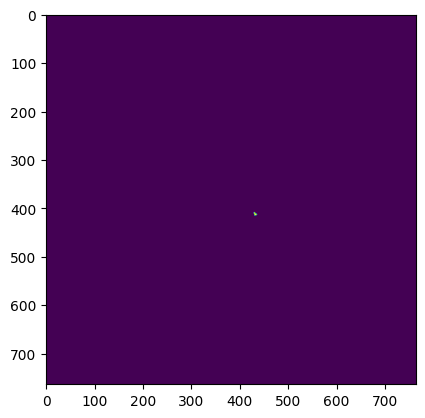

411.0


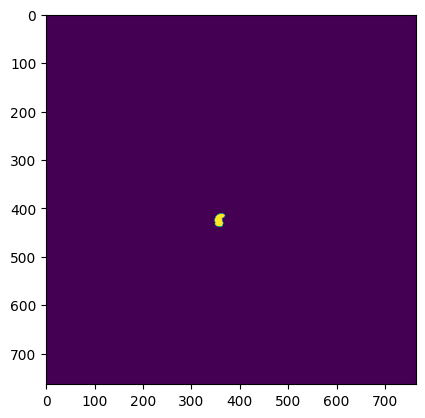

40.0


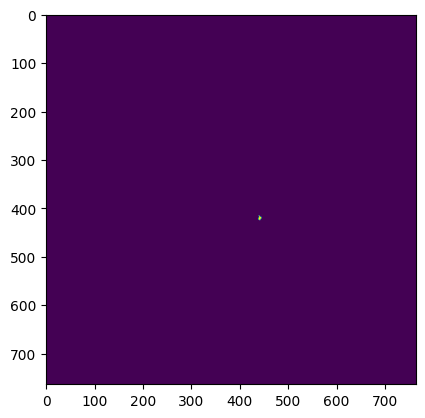

135.0


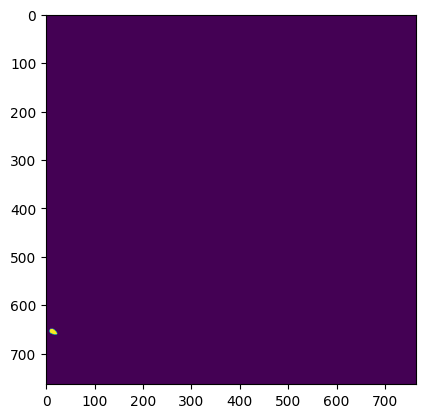

224.0


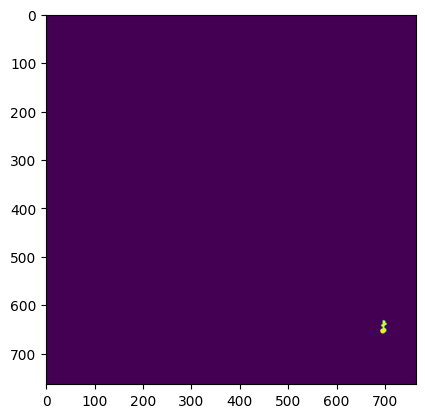

441.0


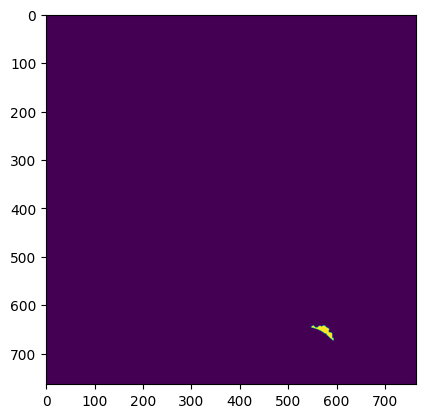

13.0


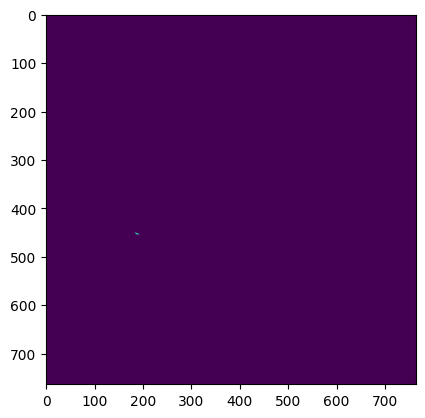

1267.0


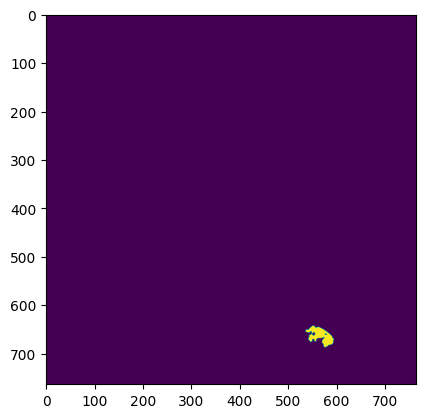

28.0


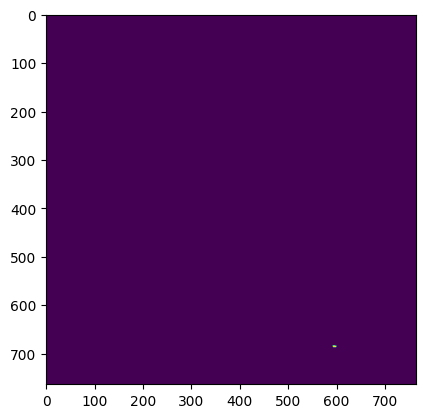

22.0


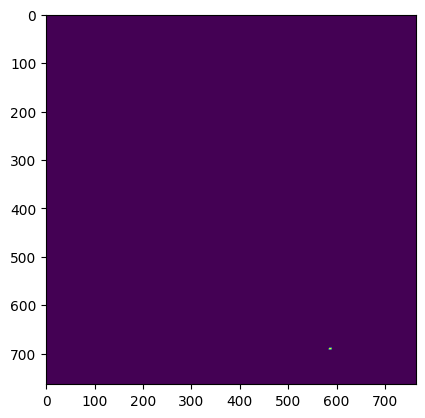

3521.0


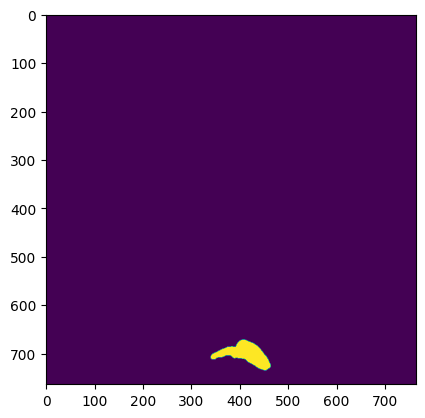

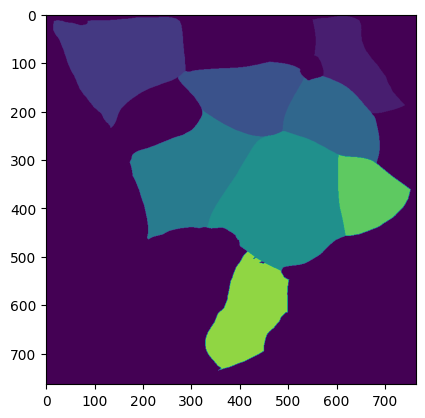

897.0


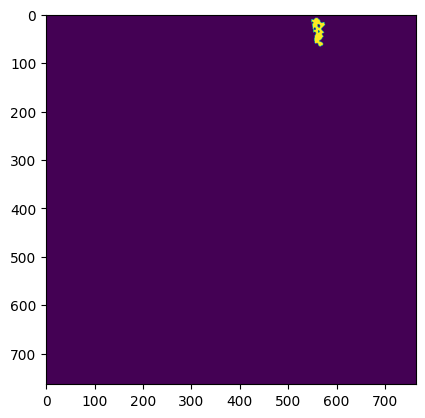

112.0


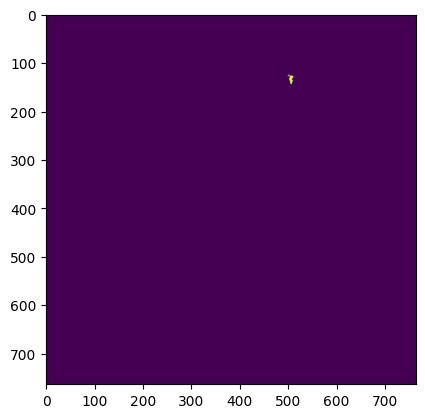

163.0


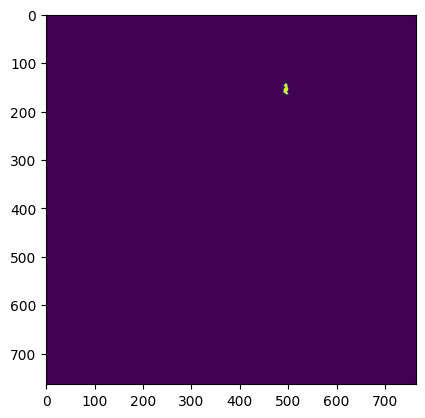

1486.0


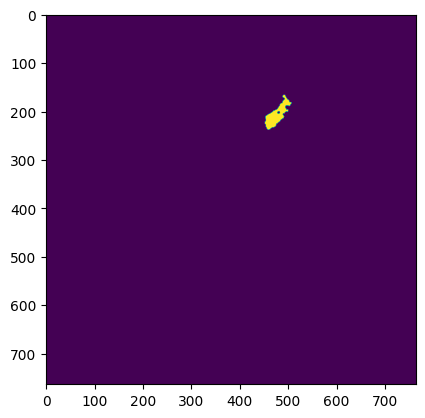

159.0


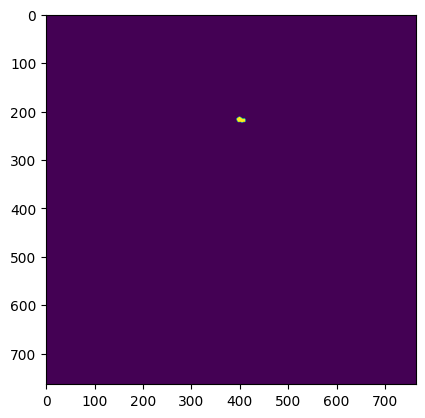

139.0


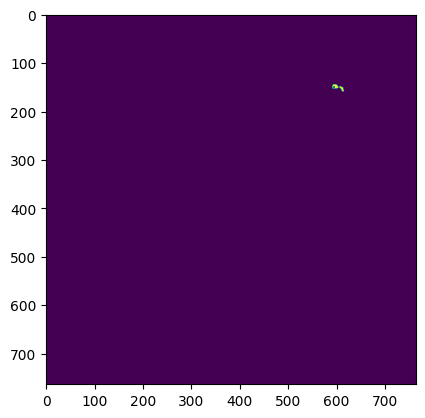

22.0


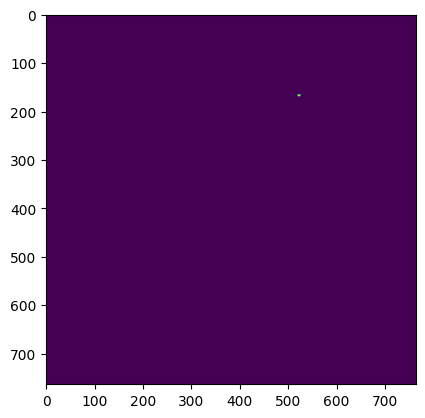

43.0


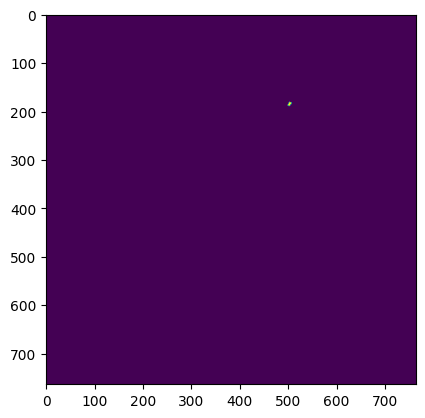

151.0


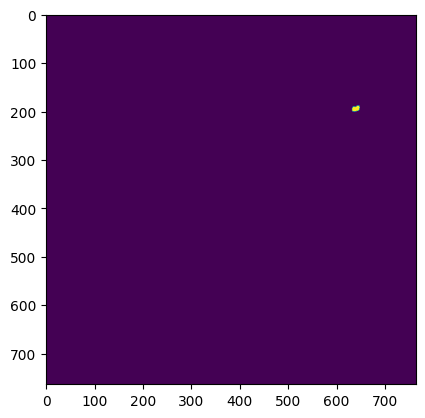

32.0


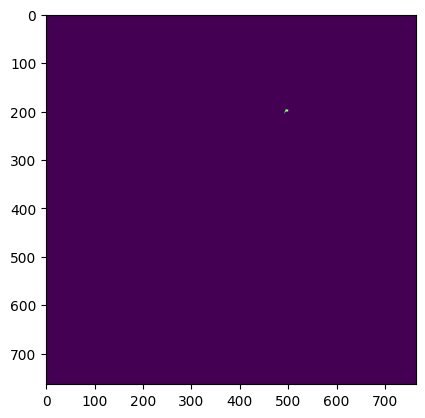

36.0


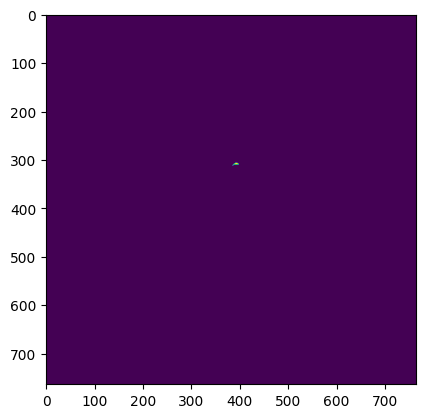

188.0


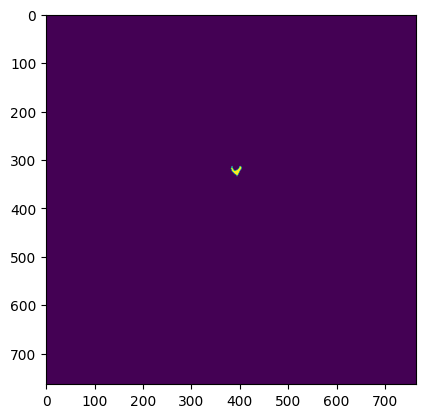

712.0


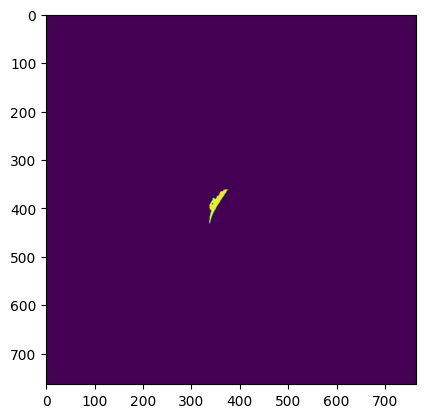

1238.0


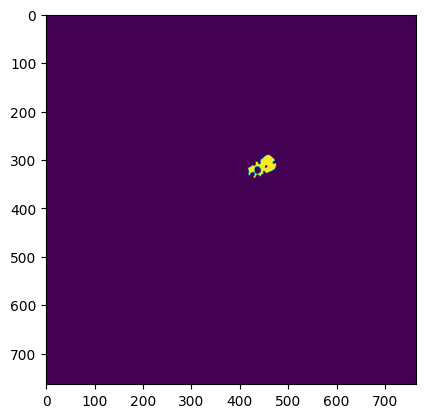

318.0


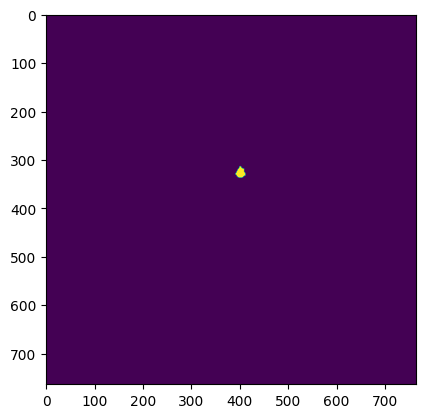

127.0


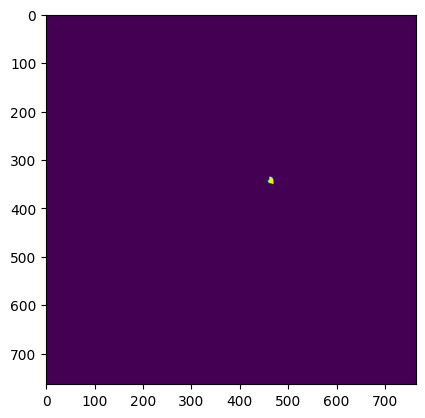

632.0


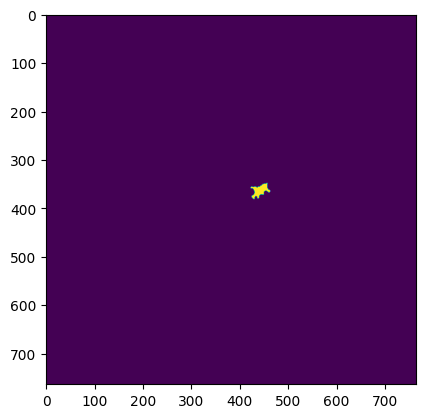

6614.0


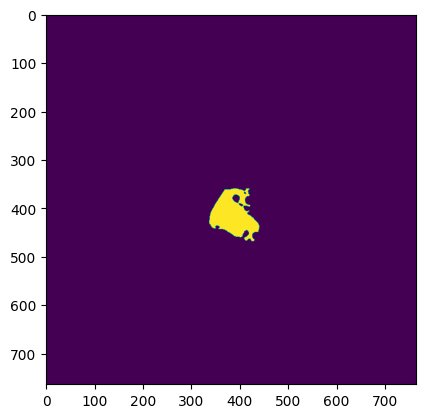

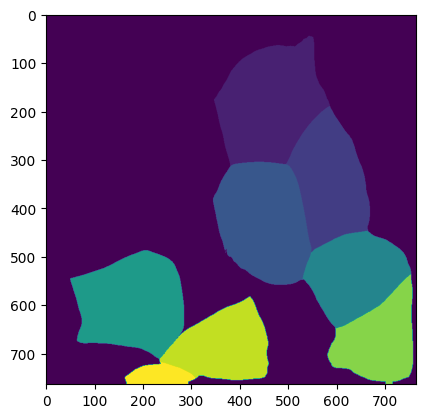

125.0


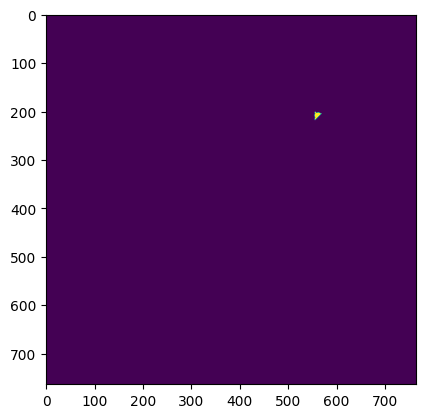

964.0


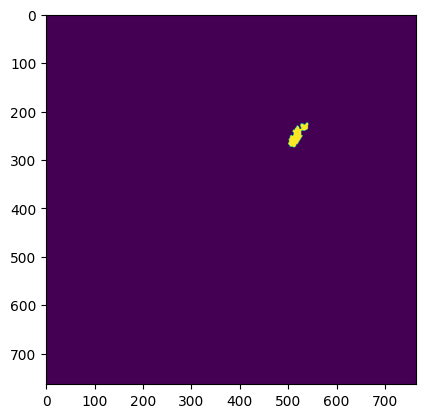

82.0


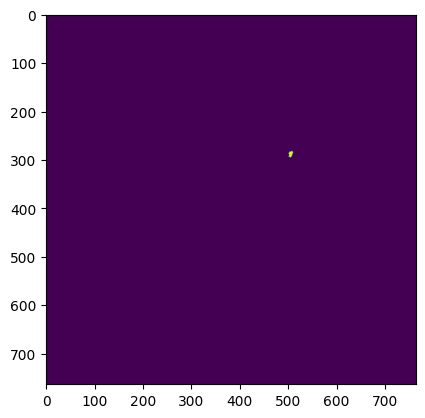

205.0


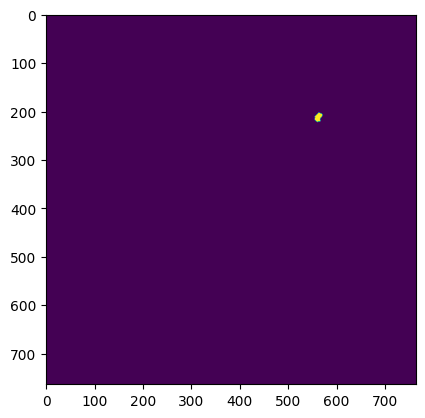

69.0


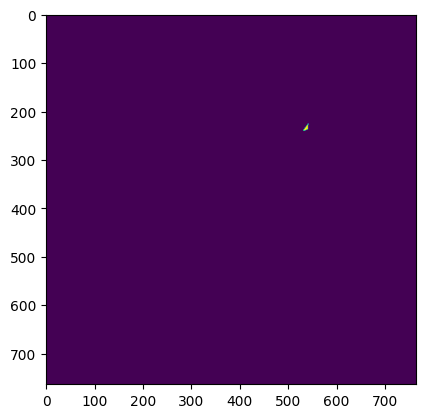

338.0


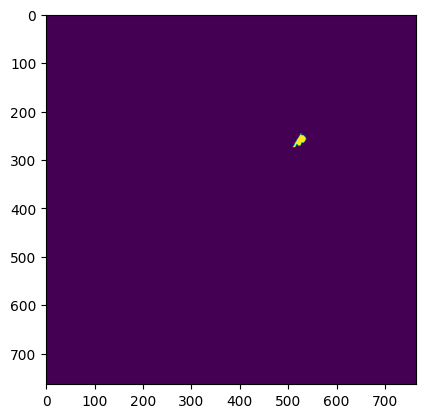

172.0


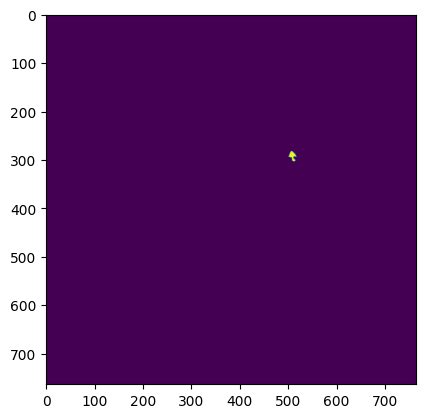

1955.0


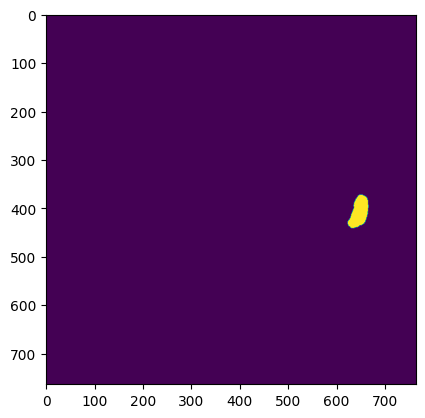

18.0


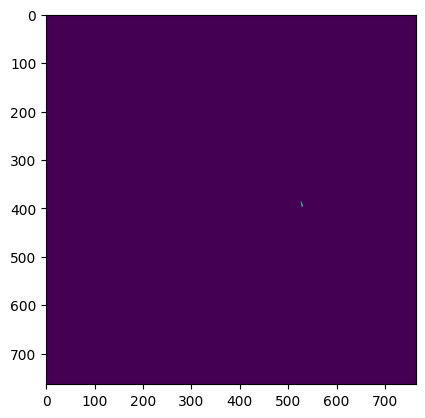

765.0


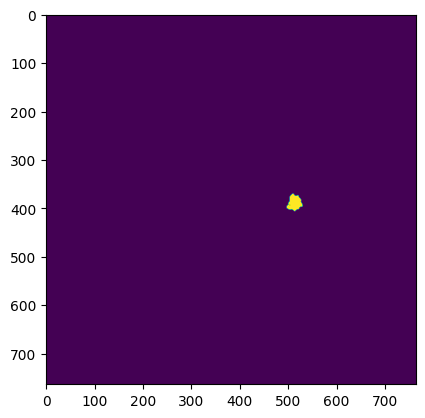

87.0


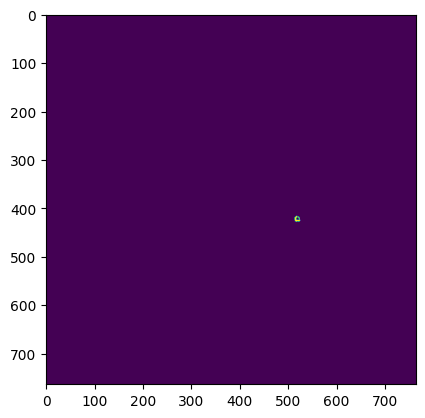

36.0


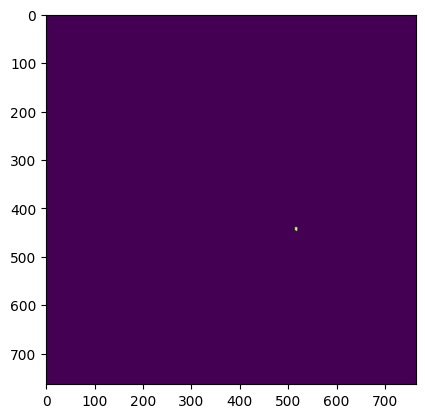

281.0


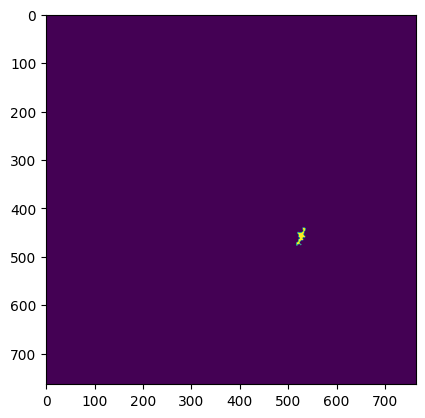

37.0


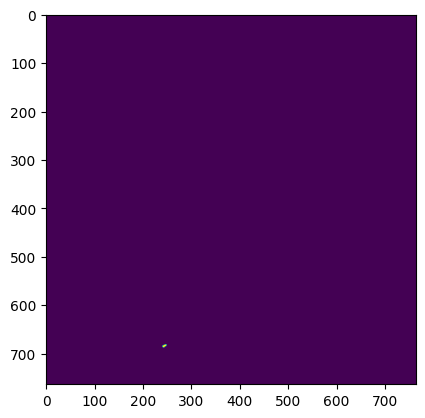

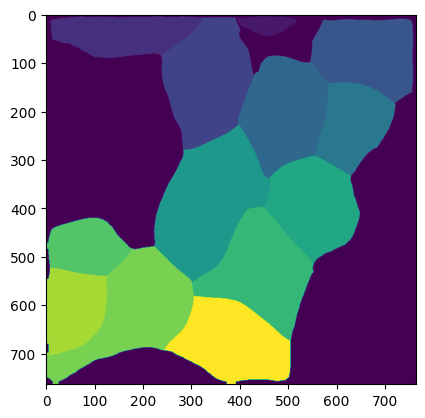

70.0


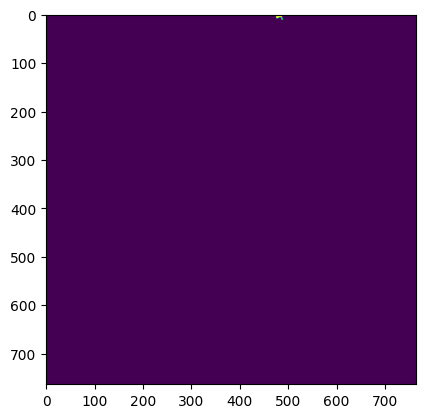

540.0


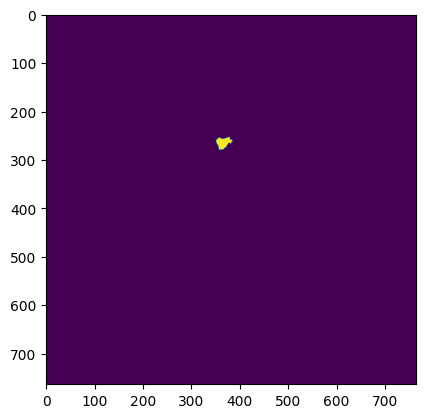

626.0


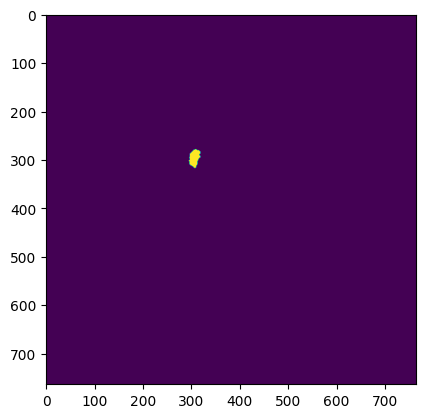

1190.0


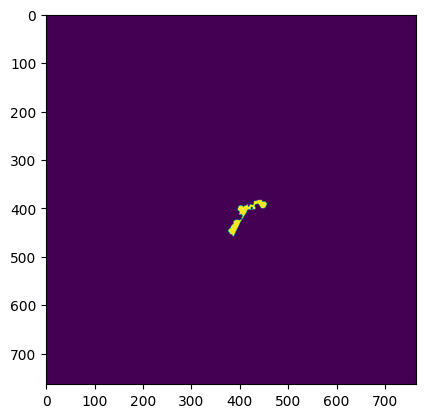

532.0


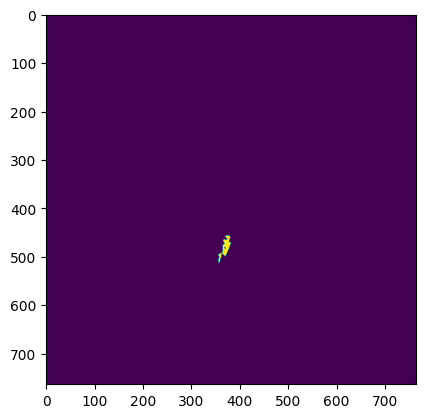

1363.0


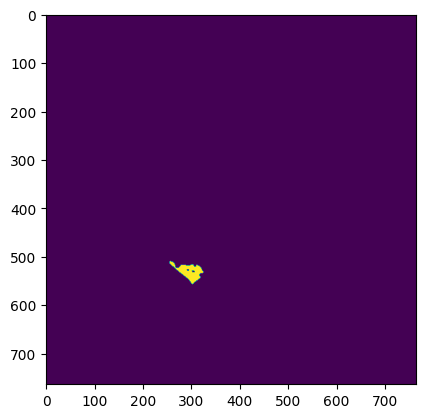

21.0


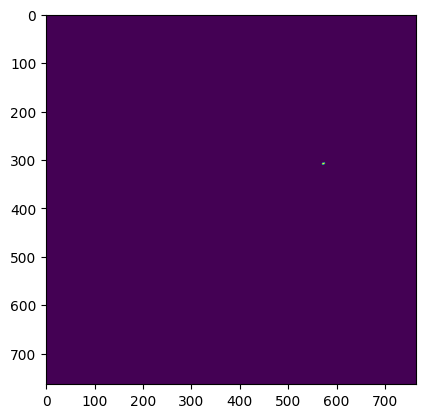

224.0


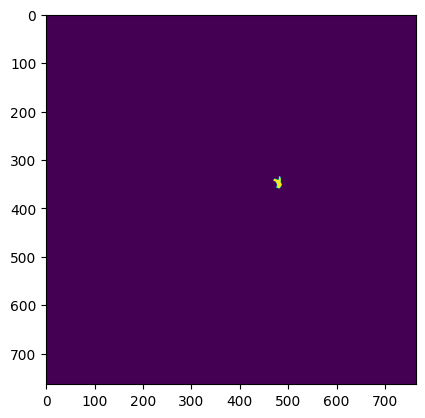

152.0


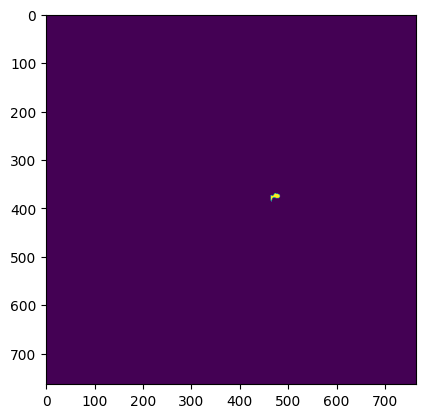

226.0


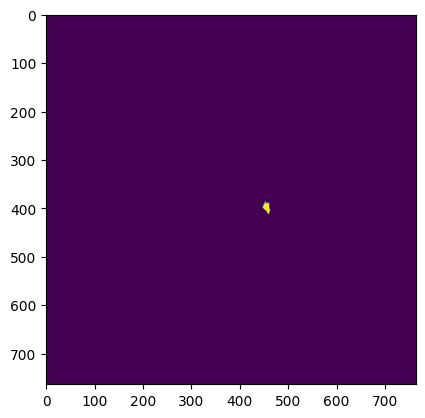

343.0


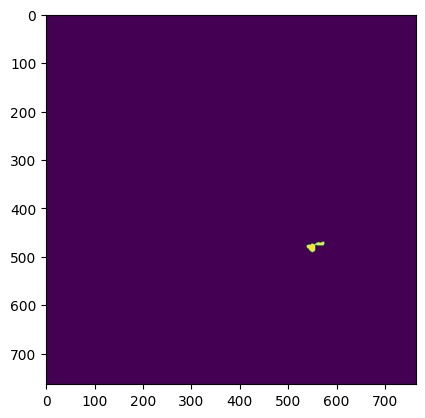

1530.0


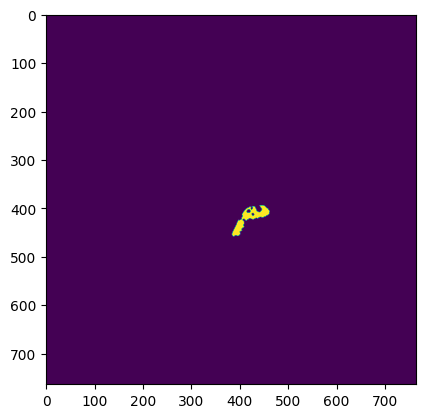

357.0


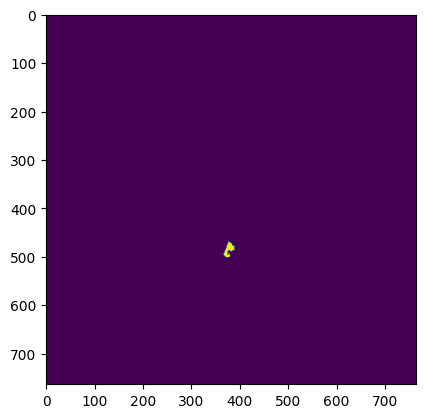

126.0


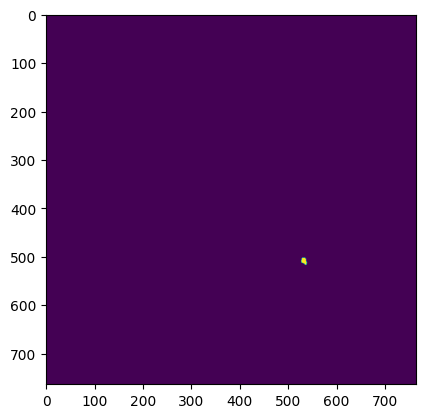

524.0


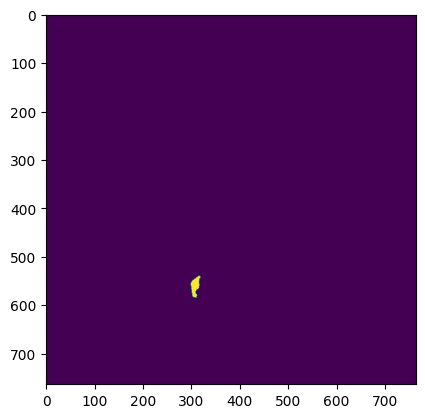

1951.0


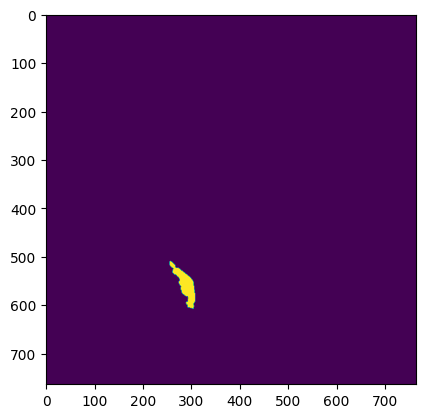

23.0


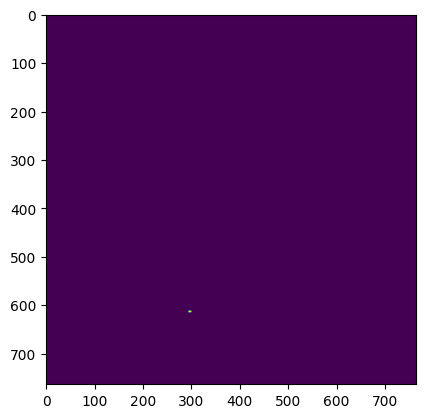

224.0


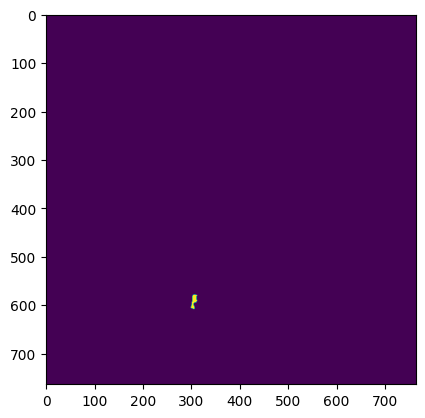

13.0


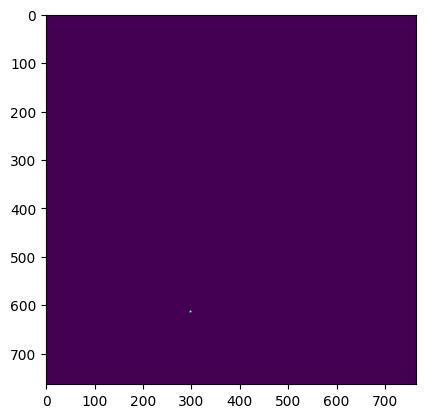

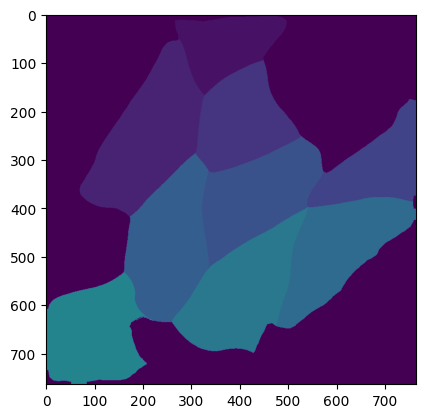

1766.0


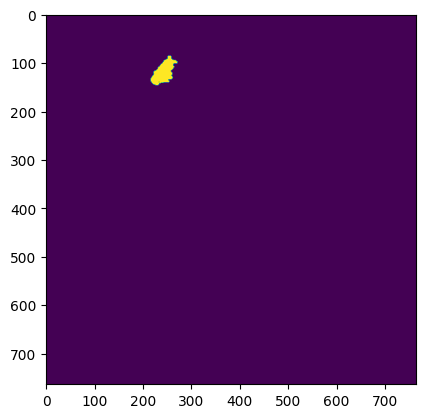

303.0


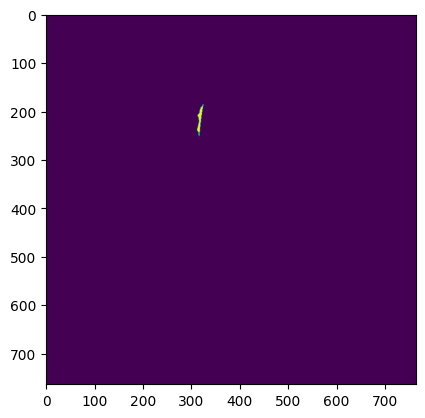

65.0


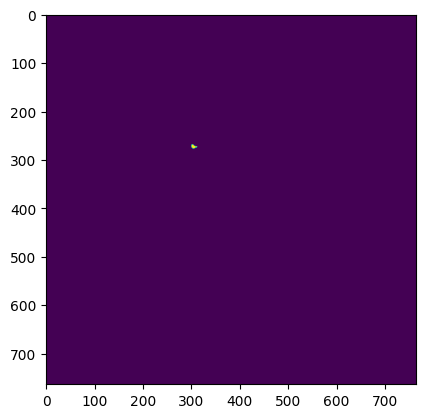

85.0


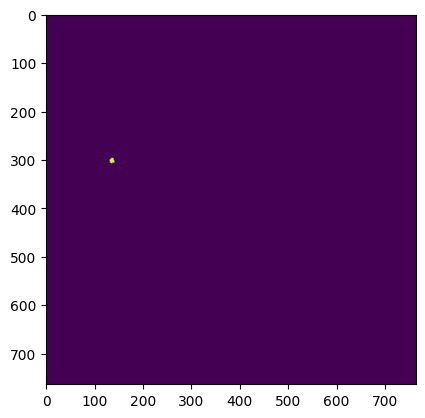

146.0


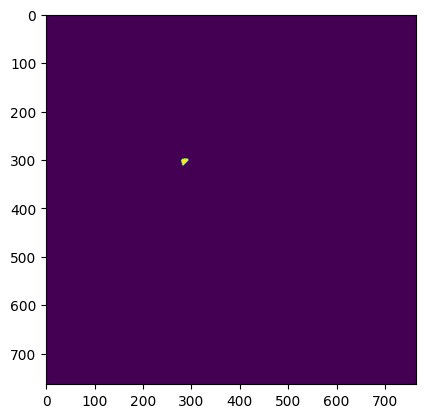

434.0


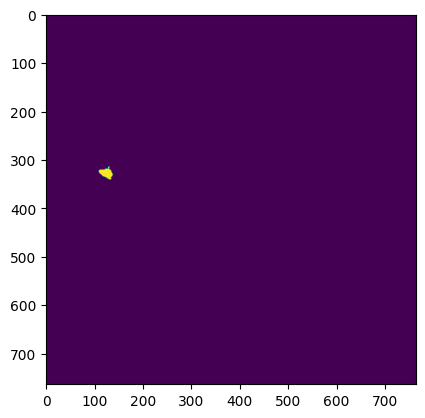

5892.0


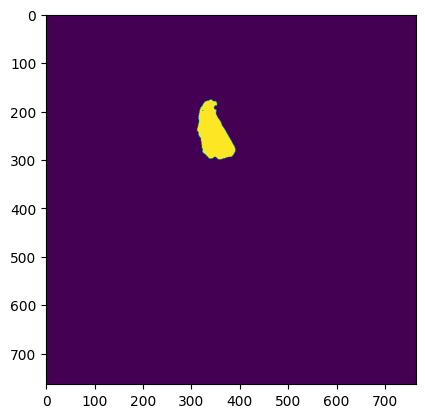

20.0


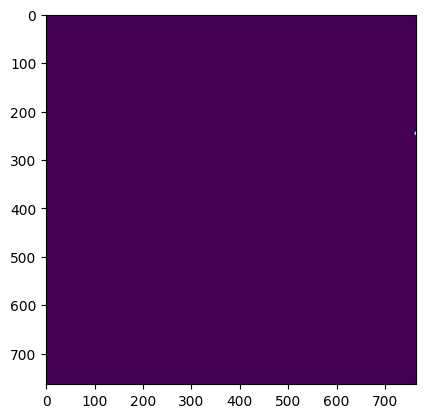

127.0


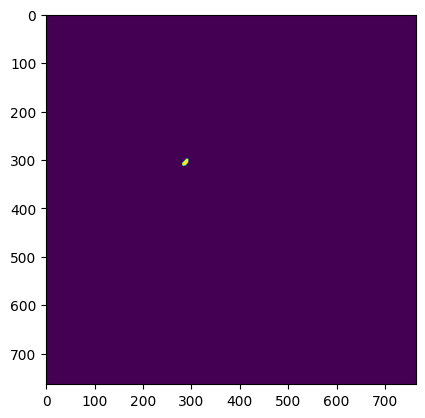

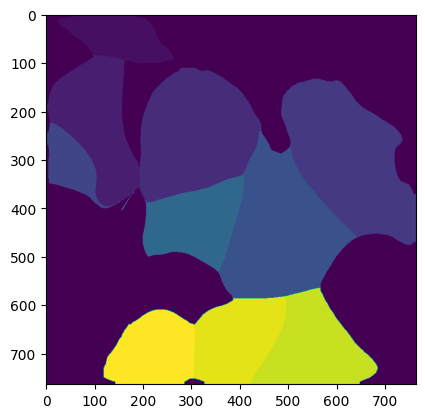

26.0


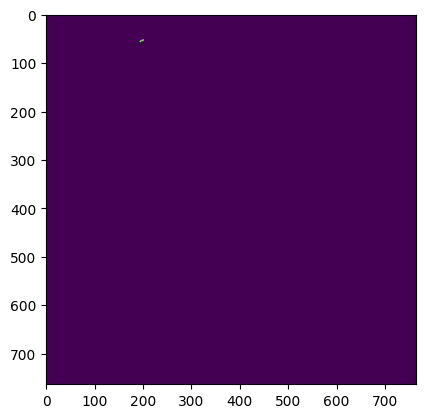

94.0


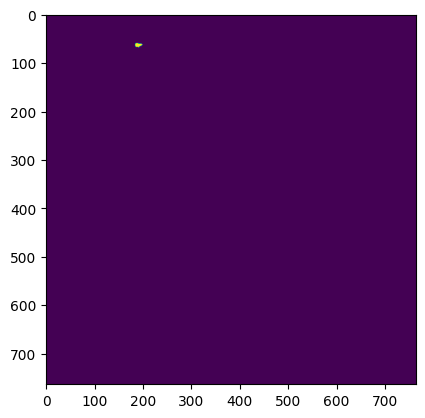

404.0


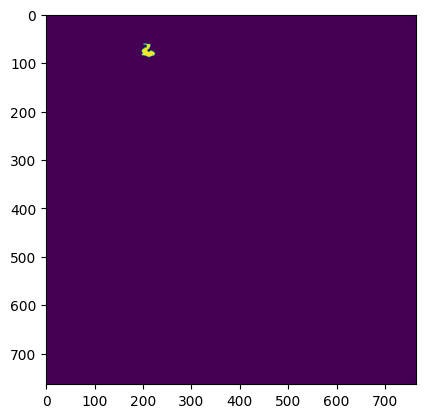

202.0


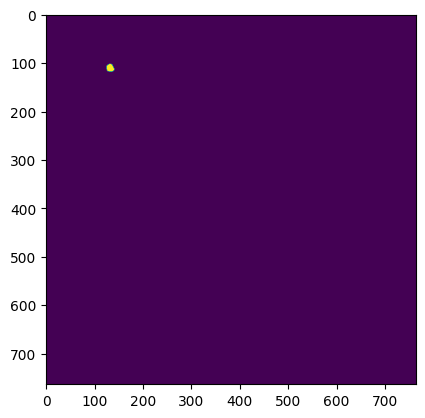

186.0


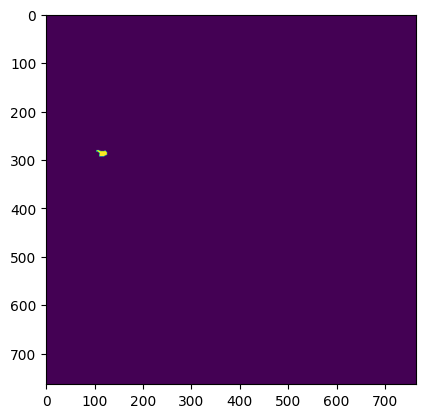

17.0


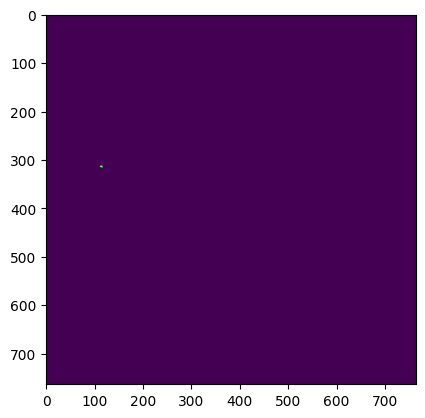

657.0


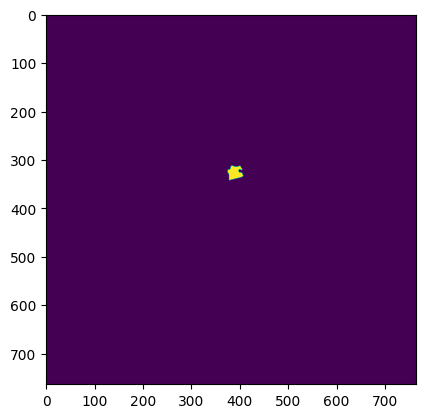

174.0


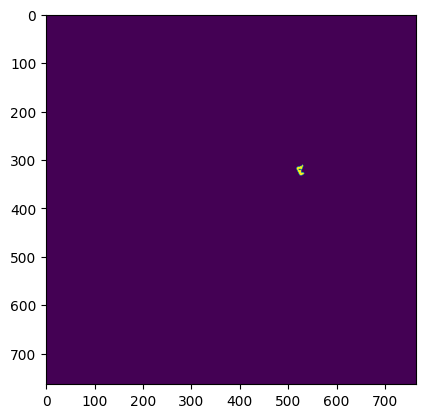

149.0


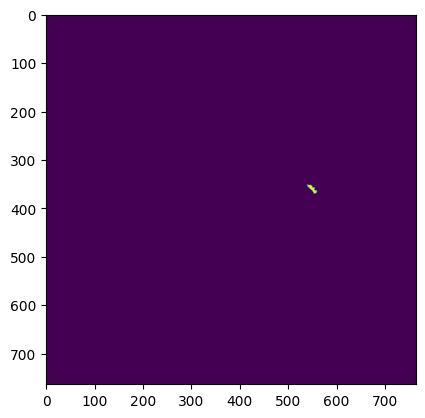

670.0


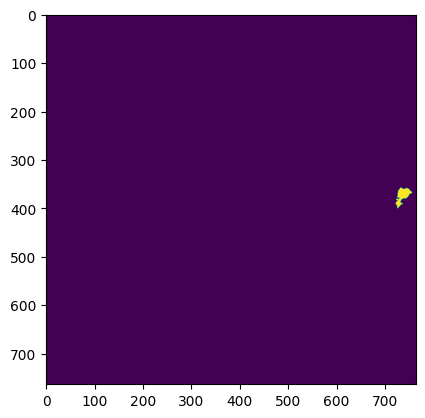

55.0


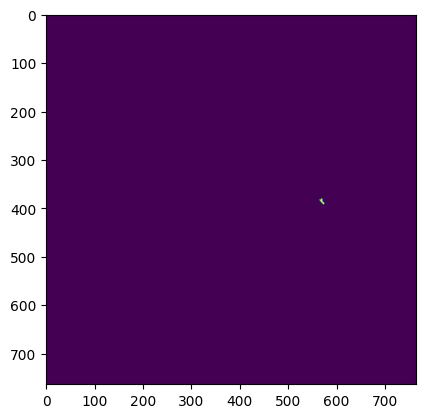

21.0


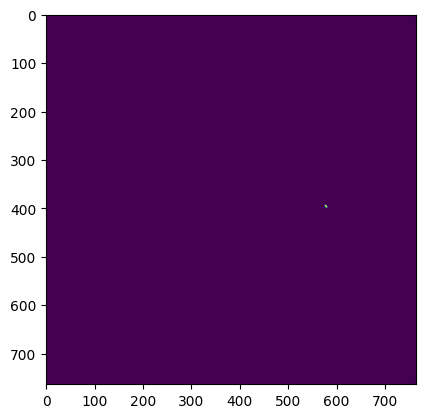

117.0


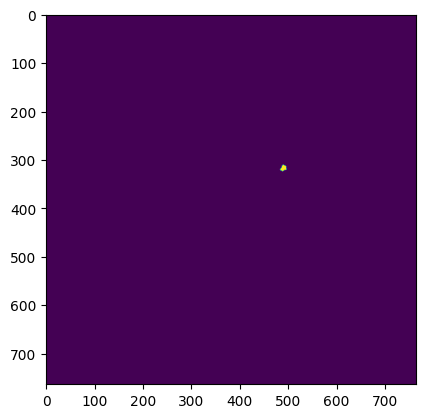

118.0


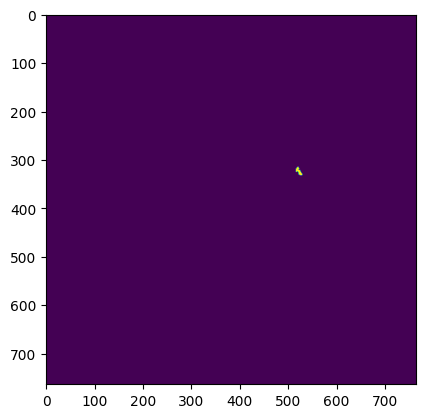

674.0


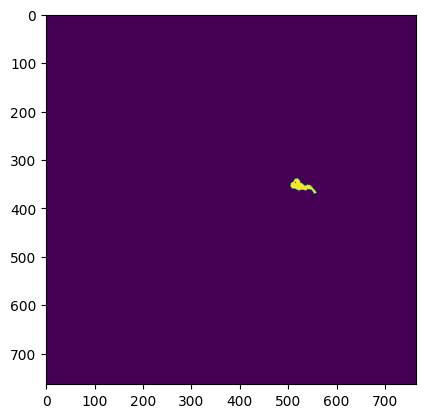

155.0


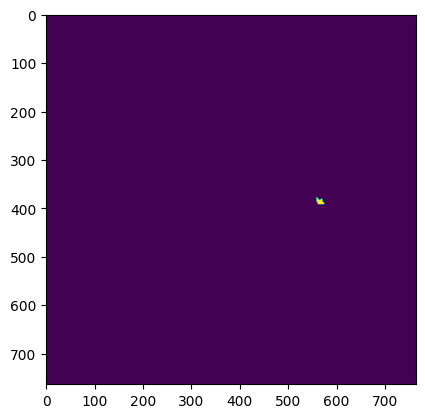

36.0


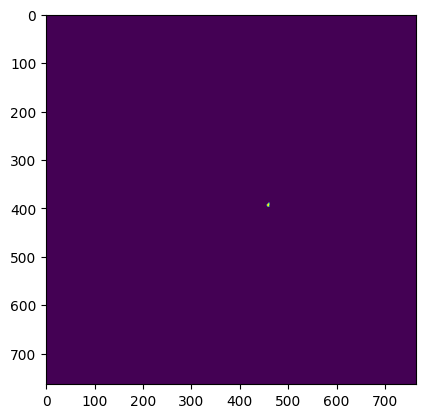

33.0


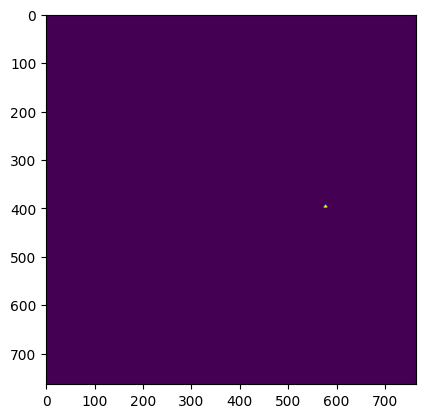

15.0


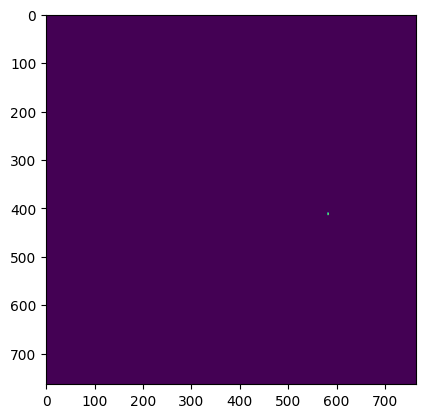

185.0


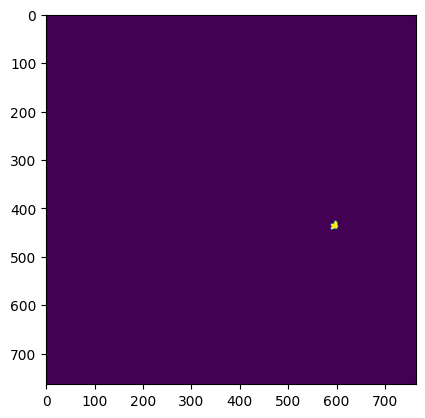

100.0


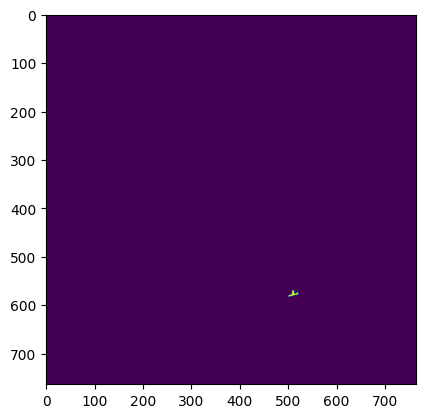

256.0


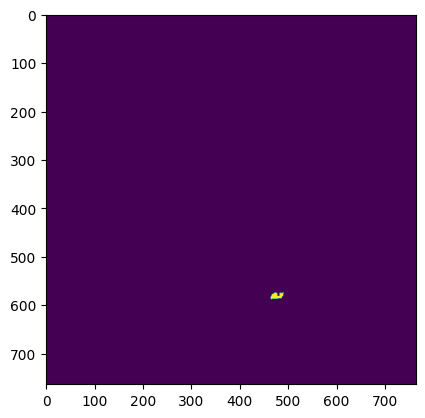

17.0


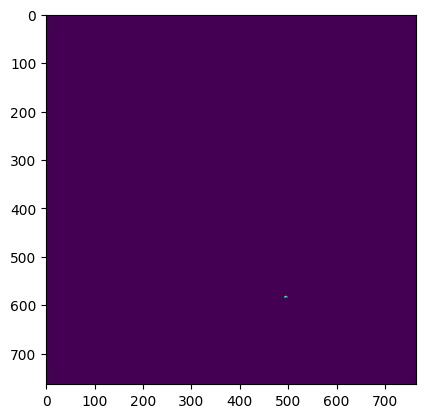

506.0


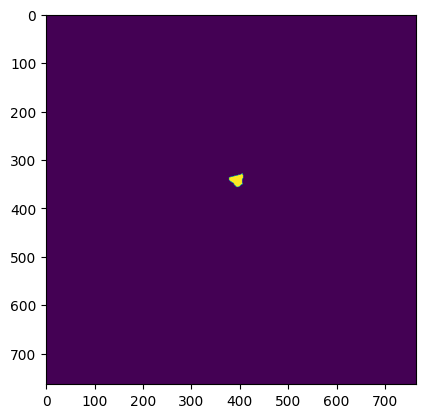

1302.0


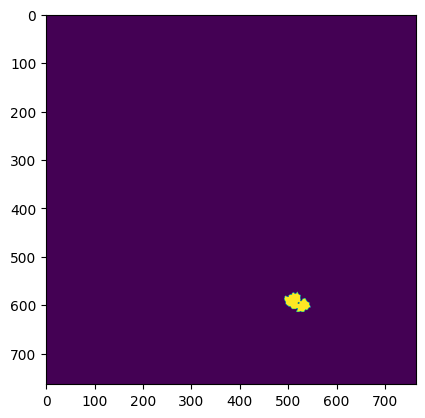

192.0


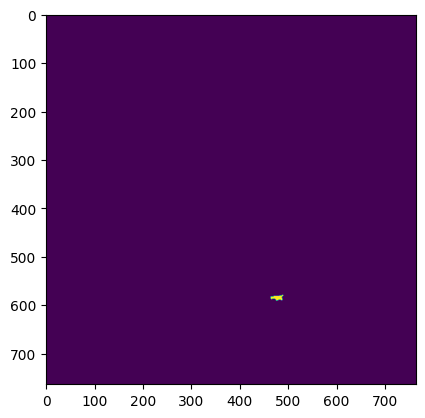

100.0


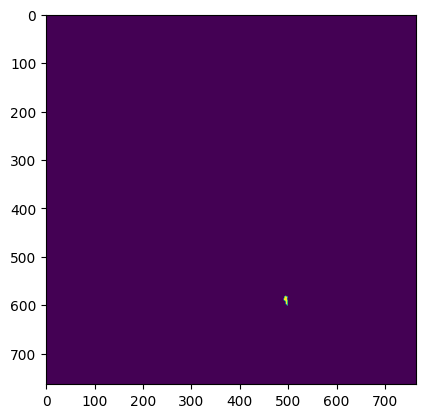

1536.0


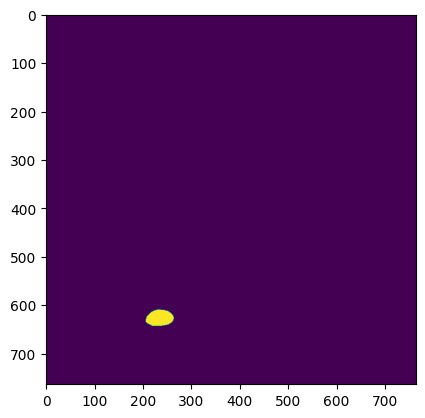

2618.0


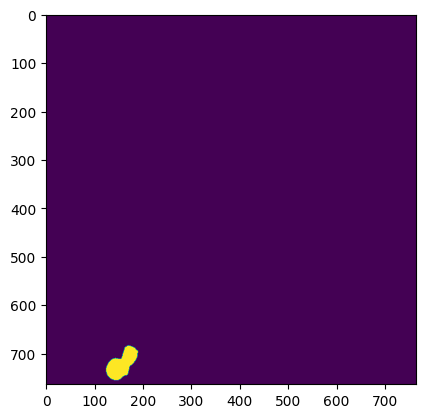

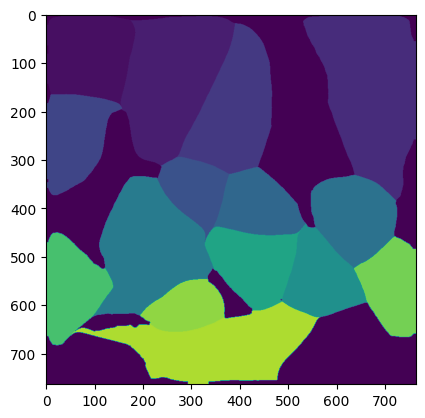

76.0


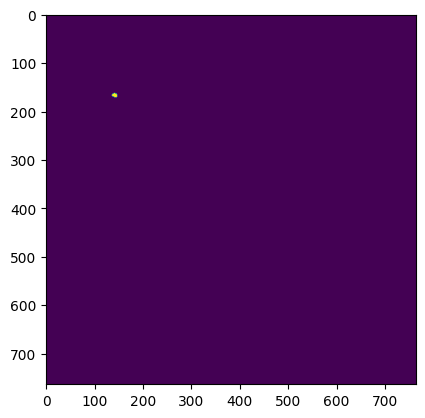

4256.0


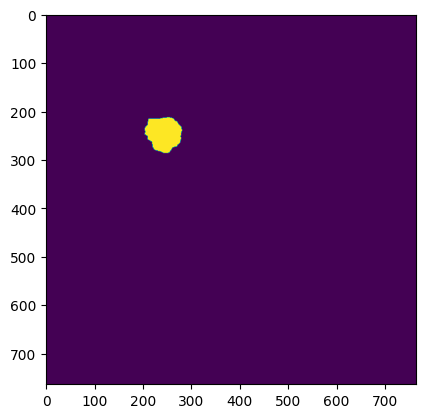

25.0


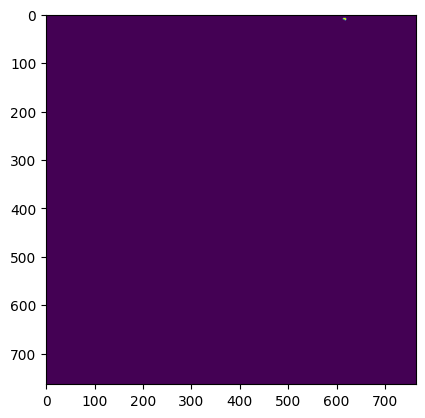

51.0


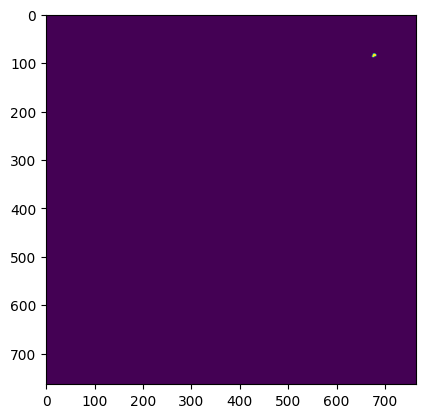

18.0


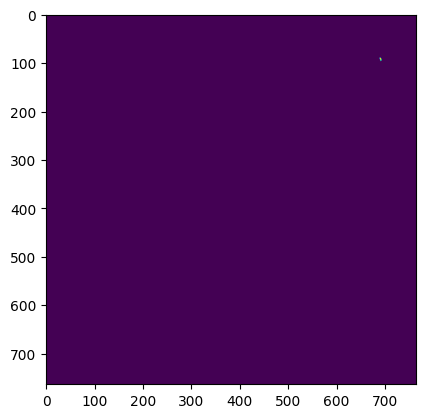

820.0


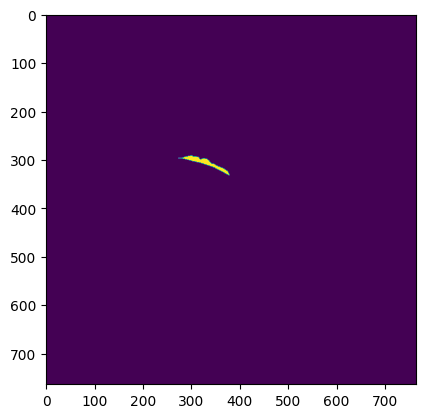

1183.0


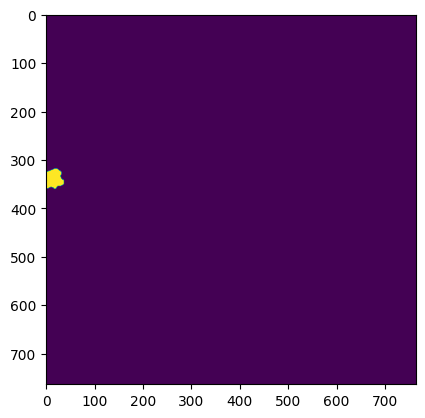

5634.0


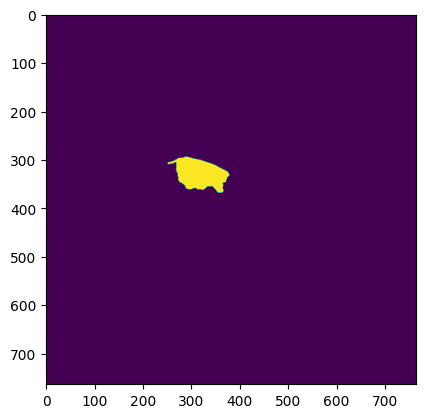

387.0


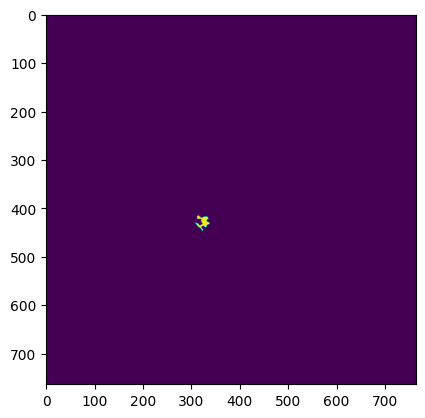

36.0


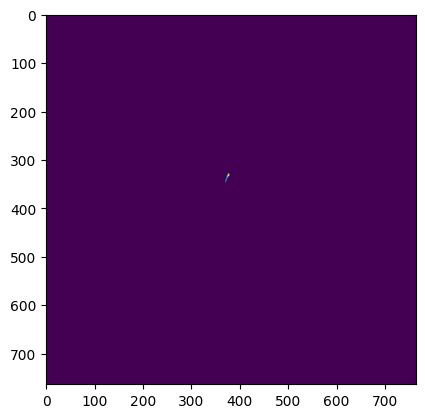

31.0


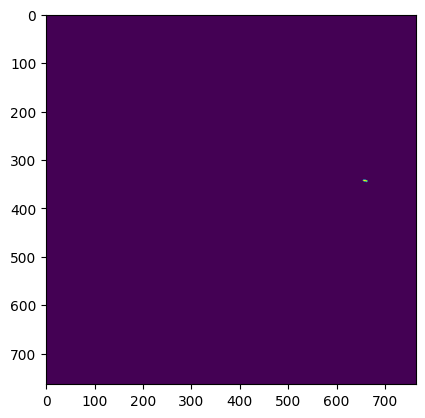

1601.0


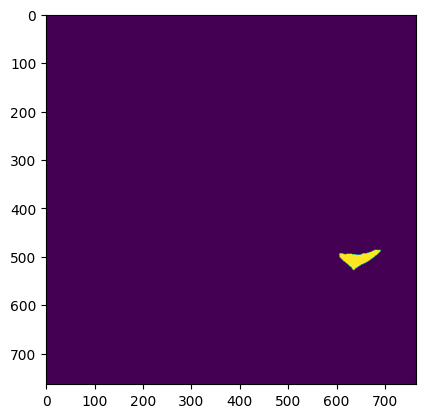

788.0


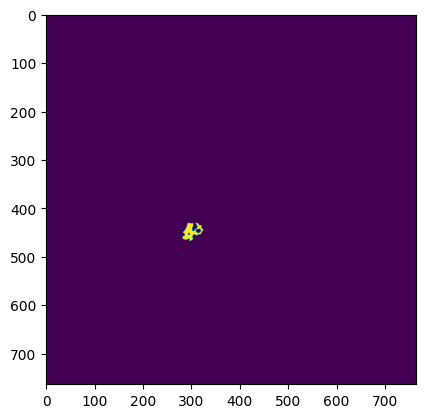

1074.0


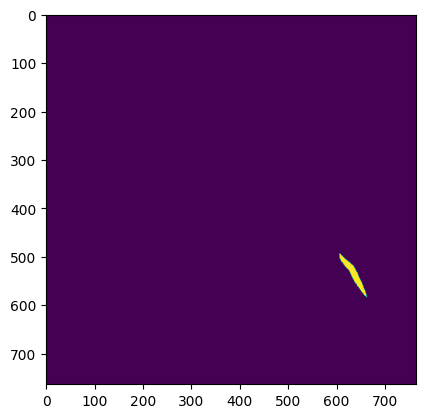

394.0


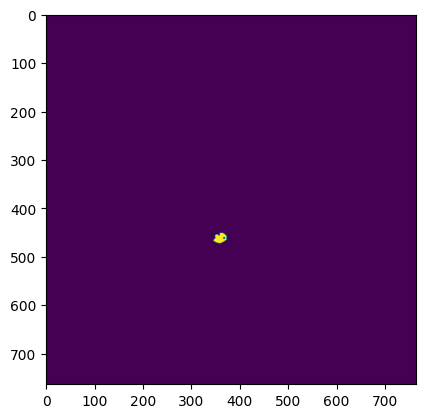

3254.0


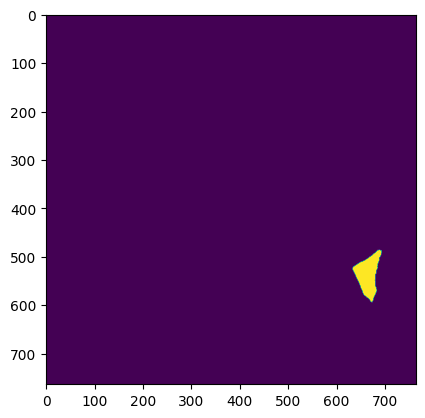

52.0


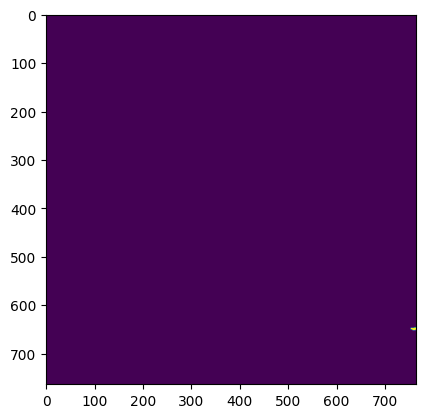

1083.0


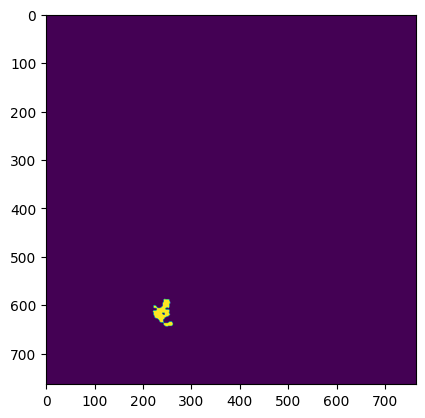

46.0


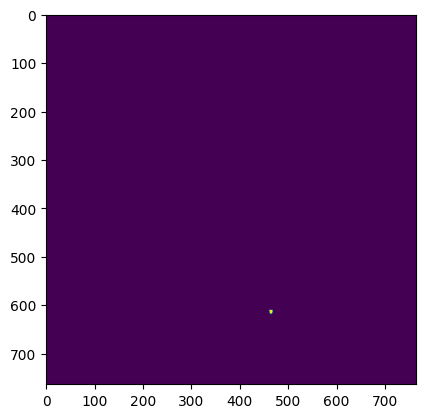

209.0


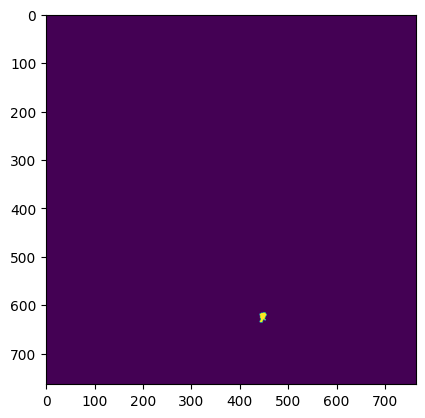

146.0


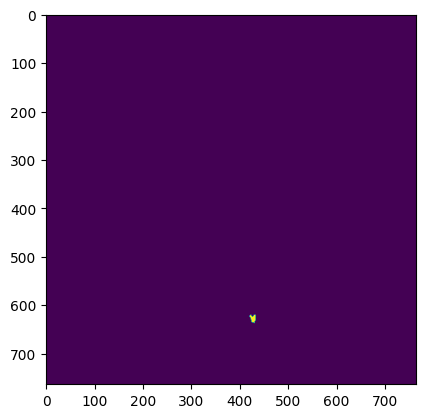

2101.0


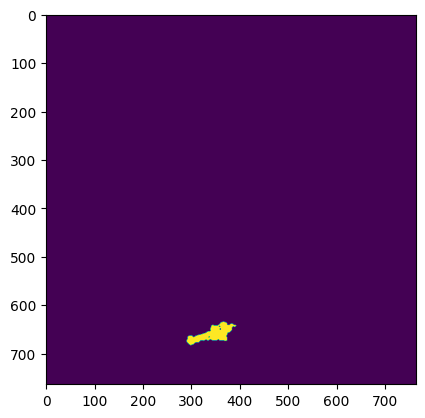

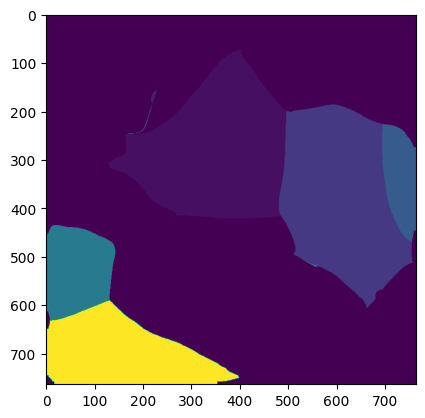

15.0


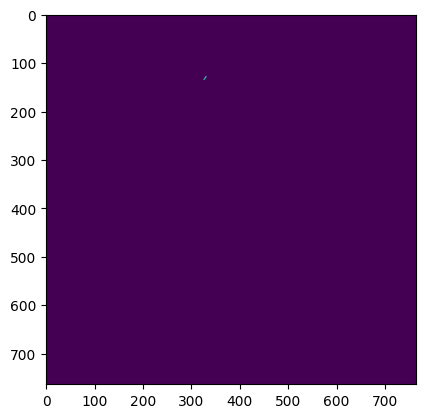

25.0


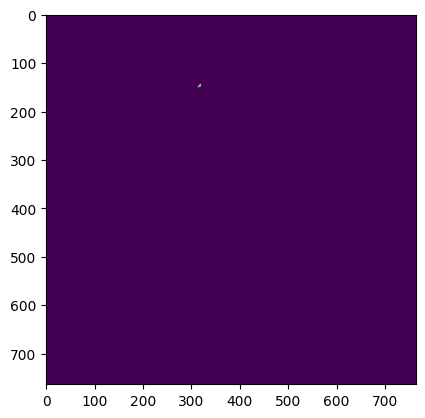

353.0


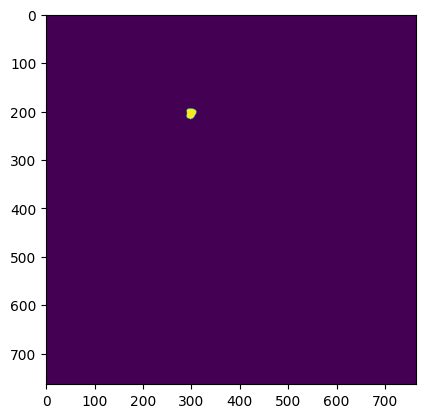

4117.0


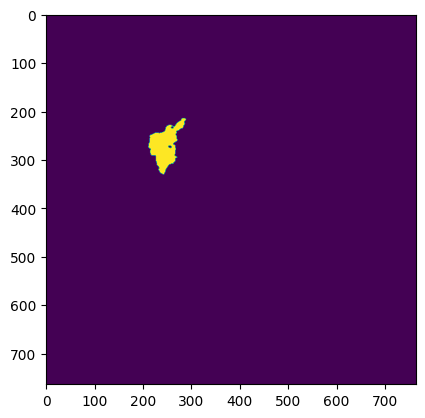

1665.0


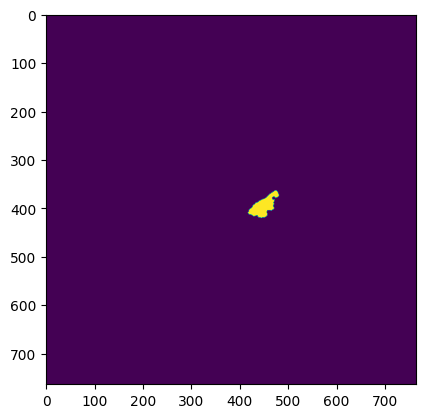

91.0


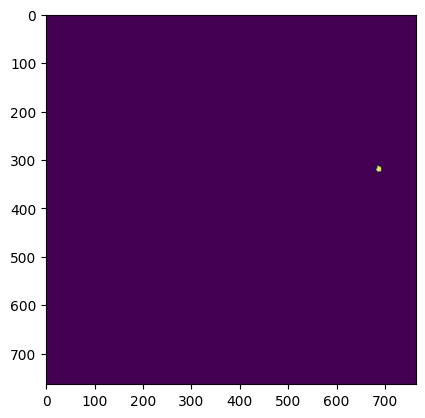

795.0


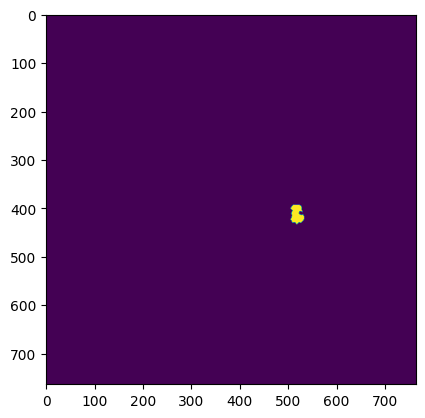

993.0


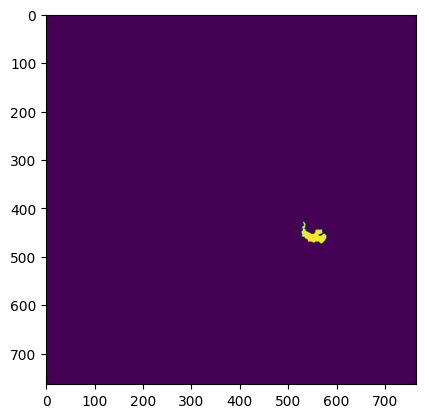

37.0


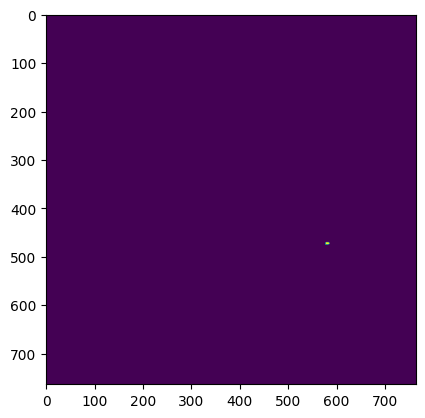

25.0


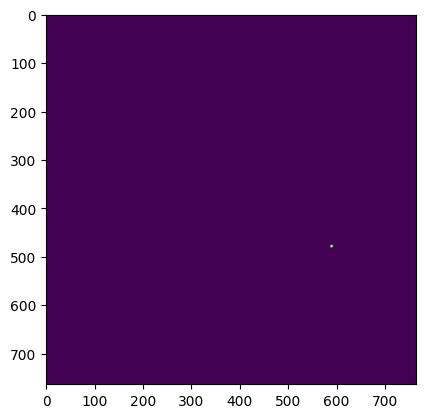

1160.0


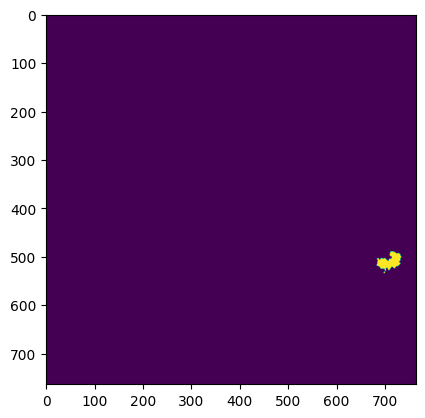

112.0


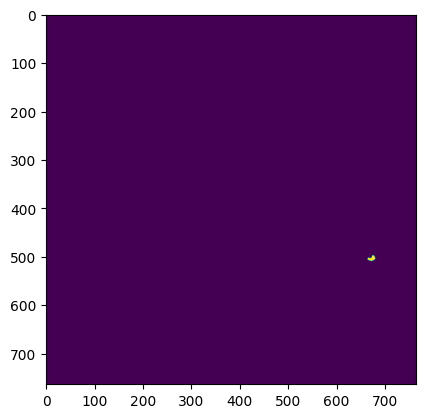

21.0


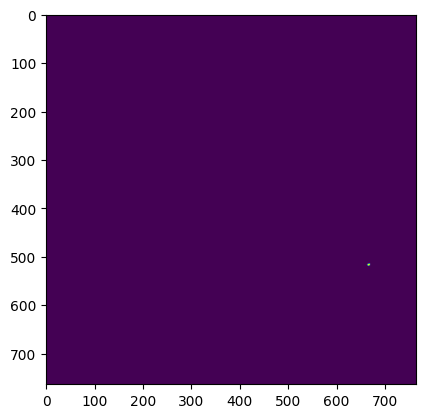

76.0


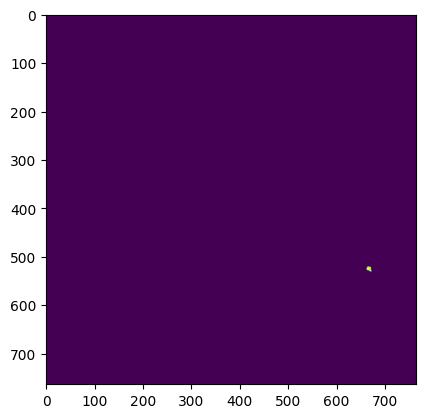

12.0


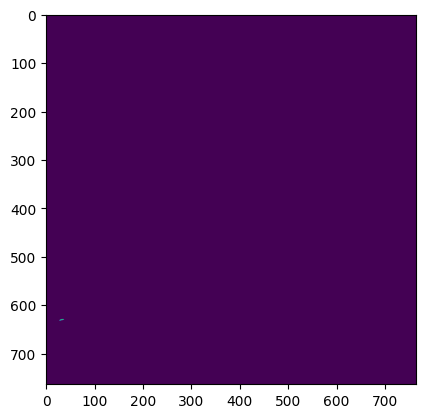

23.0


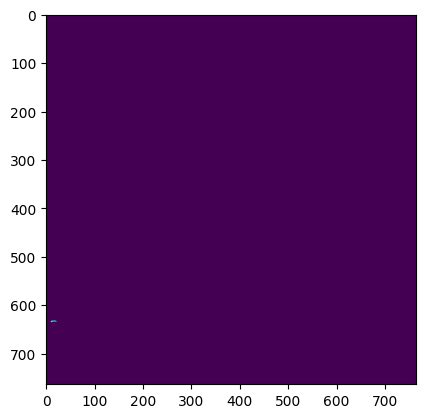

1055.0


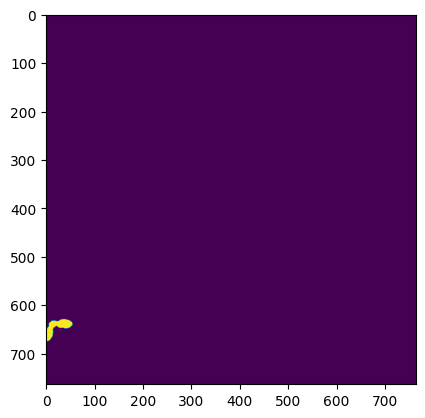

15.0


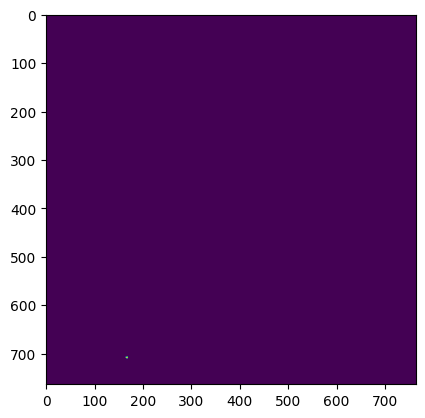

1155.0


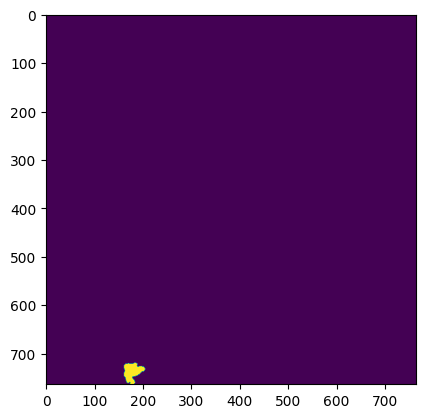

In [4]:
all_data = []
folder_path = r"C:\Users\jm2503\Box\LAB\Lab Folder\EXPERIMENTS\CONFOCAL EXPERIMENTS\780_lipids\Katelyn lipids\CH_OA_LIVE CELLS\CH Live Cells 80224"
for well_image in os.listdir(folder_path):
    if well_image.lower().endswith(".czi"):  # Filter for CZI files
        well_image_path = os.path.join(folder_path, well_image)
        well_image_base_name = os.path.basename(well_image)[:-4]
        try:
            df = analyze_image(well_image_path, well_image_base_name)
            all_data.append(df)
        except:
            continue

combined_df = pd.concat(all_data, ignore_index=True)

# Save the combined DataFrame to a single CSV
combined_csv_path = os.path.join(folder_path, 'jiya_analysis', "OA_CH_Live_analysis.xlsx")
combined_df.to_excel(combined_csv_path, index=False)

#filled in the cytoplasm

# look at the mfi of the lipids, and the proportion of the surface area taken up by then

In [5]:
display(df)

Filename  Cell  Cell_Size  Num_Inclusions  Solid_Inclusion_Count  \
0  OA_noCH_08     0    78481.0              11                      6   
1  OA_noCH_08     3    75656.0              11                      2   
2  OA_noCH_08     6    12827.0               0                      0   
3  OA_noCH_08     9    22710.0               2                      0   
4  OA_noCH_08    23    42298.0               5                      2   

   Swiss_Inclusion_Count  Average_Inclusion_Area  \
0                      5              578.636364   
1                      9              319.545455   
2                      0                     NaN   
3                      2               17.500000   
4                      3              456.800000   

   Average_Swiss_Inclusion_Area  Average_Solid_Inclusion_Area  \
0                   1235.000000                     31.666667   
1                    367.777778                    102.500000   
2                           NaN                           NaN   
3                     17.500000                           NaN   
4                    741.666667                     29.500000   

   Portion of Lipids Associated with Inclusions  \
0                                      0.585143   
1                                      0.175571   
2                                      0.000000   
3                                      0.000000   
4                                      0.221093   

   Portion of Inclusions Associated with Lipids  MFI Lipids in Cytoplasm  \
0                                      0.984626                 0.819625   
1                                      0.991471                 0.819625   
2                                      0.000000                 0.819625   
3                                      0.000000                 0.819625   
4                                      0.993109                 0.819625   

   Portion of Cytoplasm Surface Area occupied by Diffuse Lipids  \
0                                           0.789245              
1                                           0.698657              
2                                           0.662941              
3                                           0.972503              
4                                           0.799872              

   Portion of Cytoplasm Surface Area occupied by Droplet Lipids  Num_Lipids  \
0                                           0.196130                      8   
1                                           0.255550                     20   
2                                           0.171382                      4   
3                                           0.015759                      5   
4                                           0.180375                     13   

   Average_Lipid_Area  
0          779.500000  
1          434.900000  
2          336.750000  
3            5.400000  
4          288.923077

In [6]:
# all_data = []

# folder_path = r"C:\Users\jm2503\Box\LAB\Lab Folder\EXPERIMENTS\CONFOCAL EXPERIMENTS\780_lipids\Katelyn lipids\robert\041624_OA_Autophagy_overnight_p43"
# for well_image in os.listdir(folder_path):
#     if well_image.lower().endswith(".czi"):  # Filter for CZI files
#         well_image_path = os.path.join(folder_path, well_image)
#         well_image_base_name = os.path.basename(well_image)[:-4]
#         if "no" in well_image_base_name.lower():
#             if "oa" in well_image_base_name.lower():
#                 df = analyze_image(well_image_path, well_image_base_name)
#                 all_data.append(df)

# combined_df = pd.concat(all_data, ignore_index=True)

# # Save the combined DataFrame to a single CSV
# combined_csv_path = os.path.join(folder_path, 'jiya_analysis', "cell_selection_lipids_analysis.xlsx")
# combined_df.to_excel(combined_csv_path, index=False)